# Sparkify

## Introduction

### Project Overview

*Sparkify* is an imaginary music streaming service of Udacity to emulate a real streaming service like Spotify. The Sparkify users can stream the music using the free subscription plan with ads or paid subscription plan without ads. Apart from using the service to listen to the music, users can thumb up or down, add songs to playlists, or add friends. Users are free to change their subscription plan by *upgrading* from free to paid, by *downgrading* from paid to free, or to entirely stop using the service by *cancelling* the subscription. 

Any user interaction with the service triggers a certain log event that represents our data. A log contains information about the event time, identifies the session and the user, includes some of user attributes, subscription plan, user interaction type etc. 

There are 2 datasets with event log information available for our project: 
 - **full** (big) dataset of 12GB available on Amazon EMR cluster, 
 - **mini** (sample) dataset available on local machine. 
 
We'll use the mini dataset to get used to our data and to carry out all the necessary preparation work before moving to Amazon EMR cluster where the "real" job will be done. Since we are working with huge amount of data we'll be using **Apache Spark** analytics engine for processing large datasets with Spark SQL query language for structured data processing.

### Problem statement

Business-wise, the word "**churn**" is used to refer to customers that leave the company’s service over a given time period. The businesses strive to identify the potential users who are likely to leave *before* they actually leave the service in order to take actions to retain them. Some estimate that it may costs five or six times as much to acquire a new customer than it does to retain the ones you have (https://baremetrics.com/academy/churn).

Our churned users are defined as those who **downgrade** or **cancel** the subscription. For the reasons explained later on *we will not mix* users who cancelled the subscription with users who downgraded. We’ll separately address these two churn types of users.

The identification of potential churned users is a **binary classification problem**: either a user is *churned* or *non-churned*. In order to be able to properly classify users we will perform exploratory data analysis against sample data, then we’ll engineer the features that we will find important for churn classification, and finally, we’ll exercise modelling with selected features using various learning methods. 

The solution of our problem is to create a **machine learning model** that can provide prediction results achieving the *project goal* according to the chosen metrics as described in the next section.

### Metrics

Choosing the right metrics is essential for the machine learning model evaluation. Our full dataset has *22,278* users out of which *5,003* are cancelled users (*22.46%*). If we use **accuracy** to measure the prediction quality of our model and our model identifies every users as a *non-churned* we achieve accuracy of *77.54%* which is pretty high value for a blind model that always predicts 0. 

The problem we have is that the class of churned users is **imbalanced** due to its unequal distribution in the dataset. In case of imbalanced classes the accuracy is misleading and shouldn't be used. 

We will use the **precision-recall** metrics instead. The *precision* tells us the proportion how many churned users we successfully identified among all users that we identified as churned while the *recall* tells us the proportion how many churned users we successfully identified among all churned users:

> precision = $\frac{TP}{TP+FP}$

> recall = $\frac{TP}{TP+FN}$

*TP* are *true positives* or correctly identified churned users, *FP* are *false positives* or non-churned users incorrectly identified as churned users, and *FN* are *false negatives* or churned users incorrectly identified as non-churned users.

Normally, the classes are *not perfectly distributed*. Not in all cases we can clearly separate all points of a possitive class from all points of a negative class, so there will always be a certain grey zone where classes are mixed together. The inevitable consequence is an *inverse relationship* between the precision and recall: by increasing one parameter (precision or recall) the other parameter decreases (recall or precision). This is known as **precision-recall tradeoff**. 

Due to a high level of abstraction that we persue in this study we cannot focus on a specific business situation with a clear posture towards the precision-recall tradeoff. Our study is not focused on businesses that are willing to reduce churn at any cost no matter how many non-churned users we indentify as churned (*low precision*) as long as we include all churned users (*high recall*). In similar but opposite sense we are not focused on businesses that want to pinpoint with *high precision* the churned users minimizing the presence of non-churned users in the target and so investing less money in churn reduction even if some churned users are left out of the target (*lower recall*).  

In other words, we want to achieve a **balanced result** between the both precision-recall metrics. We don't want to have neigher too many false positives nor too many false negatives. For that reason we will use **F1-score** as our *principal metric* defined as:

> F1 = $2 * \frac{precision*recall}{precision+recall}$

F1 is the harmonic mean of precision and recall, it combines both metrics in a single metric giving an *equal weight* to both of them - which is precisely what we need.

### Environment Setup

In [15]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, from_unixtime, split, min, max, lit, mean
from pyspark.sql.functions import sum as Fsum, abs as Fabs, round as Fround
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, TimestampType
import datetime
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring

import math
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sb

In [16]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .config("spark.sql.autoBroadcastJoinThreshold", "10485760000") \
    .getOrCreate()

23/05/29 14:01:57 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [17]:
# Set time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

# MongoDB Spark Connect

Step1: Connect to MongoDB instances\
Step2: Start Spark Shell from the command line
    
    pyspark --conf "spark.mongodb.read.connection.uri=mongodb://127.0.0.1/test.sparkify1200" \
              --conf "spark.mongodb.write.connection.uri=mongodb://127.0.0.1/test.sparkify1200" \
              --packages org.mongodb.spark:mongo-spark-connector_2.12:10.1.1

Step3: Create a SparkSession Object, specified the spark.mongodb.input.uri and spark.mongodb.output.uri configuration options. Use SparkSession.builder and specify different configuration options to create your own SparkSession object.

- The spark.mongodb.input.uri specifies the MongoDB server address (127.0.0.1), the database to connect (test), and the collection (myCollection) from which to read data, and the read preference.
- The spark.mongodb.output.uri specifies the MongoDB server address (127.0.0.1), the database to connect (test), and the collection (myCollection) to which to write data. Connects to port 27017 by default.
- The packages option specifies the Spark Connector's Maven coordinates, in the format groupId:artifactId:version.

### Uncomment below code to use MongoDB

In [18]:
# from pyspark.sql import SparkSession
# spark = SparkSession \
#     .builder \
#     .appName("myApp") \
#     .config("spark.mongodb.input.uri", "mongodb://@127.0.0.1:27017/test.sparkify1200") \
#     .config("spark.mongodb.output.uri", "mongodb://@127.0.0.1:27017/test.sparkify1200") \
#     .getOrCreate()

# #load data
# data = spark.read.format("mongodb").option("header","true").option('escape','"').load()
# original_count = data.count()
# data.take(1)

23/05/29 14:01:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


[Row(_id='644967732663046b5b33e785', artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Time For Miracles', status=200, ts=1538352394000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data

In [5]:
# Load dataset
path = "data/sampled_sparkify_event_data.csv"
data = spark.read.option("header","true").option('escape','"').csv(path)
original_count = data.count()
data.take(1)

[Row(userId='1221593.0', status='200', gender='M', length='194.61179', firstName='Jackson', level='free', lastName='Thompson', registration='1533310680000.0', ts='1538352172000', auth='Logged In', page='NextSong', sessionId='6800', location='Los Angeles-Long Beach-Anaheim, CA', itemInSession='51', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', song='Still Light', artist='The Knife', method='PUT')]

### Data set size and schema

In [19]:
# Dataset size
print(f'Row count: {original_count}')
print(f'Column count: {len(data.columns)}')

Row count: 286500
Column count: 19


In [20]:
# Schema
data.printSchema()

root
 |-- _id: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: integer (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



artist: 用户正在收听的艺术家\
userId」: 用户标识符\
sessionId: 标识用户在一段时间内的唯一ID，多个用户可以使用相同的sessionId标记会话\
firstName: 用户的名字\
lastName: 用户的姓\
gender: 用户的性别;2类(M和F)\
location: 用户的位置\
userAgent: 用户用于访问流媒体服务的代理;有57个不同类别\
registration: 用户的注册时间戳\
level (non-static): 订阅级别;两类(免费和付费)\
page: 生成此事件时用户正在访问的页面。

### Columns description

In [21]:
def unique(data, column):
    """Return unique values with row count of a given column in the data set.
    
    Args:
        data (DataFrame): The data set. 
        column (str): The name of a target column.

    Returns:
        DataFrame: A dataframe query sorted by count descending.
    """
    return data.groupby(column).count().sort(desc('count'))

**artist**: Interpreter(s) of a song. Is given only when the music is played (on *NextSong* event).

**auth**: The authentication level

In [22]:
unique(data, 'auth').show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



**firstName**: The first name of a user

**gender**: The gender of a user

In [23]:
unique(data, 'gender').show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



**itemInSession**: The zero-based index of a log event in a session

In [24]:
data.where(data.sessionId == 51).select('ts', 'itemInSession', 'page').sort('ts').show(5)

+-------------+-------------+--------+
|           ts|itemInSession|    page|
+-------------+-------------+--------+
|1538482755000|            0|NextSong|
|1538482756000|            1|  Logout|
|1538482981000|            2|    Home|
|1538482982000|            3|   Login|
|1538483069000|            4|    Home|
+-------------+-------------+--------+
only showing top 5 rows



**lastName**: The last name of a user

**length**: The length of a song (in seconds)

**level**: The subscription level of a user

In [25]:
unique(data, 'level').show()

+-----+------+
|level| count|
+-----+------+
| paid|228162|
| free| 58338|
+-----+------+



**location**: The location of a user (containing *city*, *state*)

In [26]:
unique(data, 'location').show(5, False)

+-------------------------------------+-----+
|location                             |count|
+-------------------------------------+-----+
|Los Angeles-Long Beach-Anaheim, CA   |30131|
|New York-Newark-Jersey City, NY-NJ-PA|23684|
|Boston-Cambridge-Newton, MA-NH       |13873|
|Houston-The Woodlands-Sugar Land, TX |9499 |
|null                                 |8346 |
+-------------------------------------+-----+
only showing top 5 rows



**method**: The http request method

In [27]:
unique(data, 'method').show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



**page**: The type of a user interaction\
The action to focus on: downgrade and cancel

In [28]:
unique(data, 'page').show(30, False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Home                     |14457 |
|Thumbs Up                |12551 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Login                    |3241  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Help                     |1726  |
|Settings                 |1514  |
|About                    |924   |
|Upgrade                  |499   |
|Save Settings            |310   |
|Error                    |258   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
|Register                 |18    |
|Submit Registration      |5     |
+-------------------------+------+



**registration**: The timestamp of a user registration

**sessionId**: The identifier of a user session

**song**: The name of a song

In [29]:
unique(data.where(data.userId == 1221593.0), 'song').show(5, False)

+----+-----+
|song|count|
+----+-----+
+----+-----+



**status**: The http response status code

In [30]:
unique(data, 'status').show(5, False)

+------+------+
|status|count |
+------+------+
|200   |259812|
|307   |26430 |
|404   |258   |
+------+------+



**ts**: The timestamp of an event log

**userAgent**: The user's agent used to access the streaming service 

**userId**: The identifier of a user

### Duplicate rows

In [31]:
print(f'Duplicate rows: {data.count() - data.dropDuplicates().count()}')

Duplicate rows: 0


### Missing values

In [32]:
def filter_missing(data, column):
    """Returns rows with missing values for a given column where a missing value
    is either null or empty string.
    
    Args:
        data (DataFrame): The data set.
        column (str): The name of a target column.    
        
    Returns:
        DataFrame: A dataframe query with missing values.
    """
    return data.where((col(column).isNull()) | (col(column) == ''))

def show_missing(data):
    """Shows the count of missing values for every column in a given data set.
    
    Args:
        data (DataFrame): The data set.
        
    Returns:
        None
    """
    for field in data.schema:
        print(f'{field.name}: {filter_missing(data, field.name).count()}')

In [33]:
show_missing(data)

_id: 0
artist: 58392
auth: 0
firstName: 8346
gender: 8346
itemInSession: 0
lastName: 8346
length: 58392
level: 0
location: 8346
method: 0
page: 0
registration: 8346
sessionId: 0
song: 58392
status: 0
ts: 0
userAgent: 8346
userId: 8346


Check if missing values in the user-related columns (*firstName*, *gender*, *lastName*, *location*, *registration*, *userAgent*, *userId*) belong to the same rows:

In [34]:
class Missing:
    """A helper class to simplify filtering the missing values.  
    
    Attributes:
        missing_data: A dataframe query that is built by filter_missing function.   
    """
    missing_data = None
    
    def __init__(self, data):
        self.missing_data = data
        
    def filter_missing(self, name):
        """A method that filters the missing values.
        
        We can use this method in a consecutive manner.
        
        Args:
            name (str): The name of a column to filter.
            
        Returns:
            DataFrame: A dataframe query with missing values.
        """
        self.missing_data = filter_missing(data, name) 
        return self  

In [22]:
m = Missing(data) \
    .filter_missing('userId') \
    .filter_missing('firstName') \
    .filter_missing('lastName') \
    .filter_missing('gender') \
    .filter_missing('location') \
    .filter_missing('registration') \
    .filter_missing('userAgent')
print(f'Missing count: {m.missing_data.count()}')

Missing count: 0


As the filtering criterion contains the logical conjunction of all user-related columns and the count result of missing values is the same as when a single user-related column is filtered we may conclude that the missing values occur **in the same rows**. This behaviour is in tune with the logic which tells us that if a user identifier is missing then also all related user attributes should be missing too. 

**What kind of a user has missing attributes?**

In [23]:
filter_missing(data, 'userId').select('auth').dropDuplicates().show()

+----+
|auth|
+----+
+----+



In [24]:
filter_missing(data, 'userId').select('page').dropDuplicates().show()

+----+
|page|
+----+
+----+



In [25]:
# Remove rows with the missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))
show_missing(data) 

userId: 0
status: 0
gender: 0
length: 293596
firstName: 0
level: 0
lastName: 0
registration: 0
ts: 0
auth: 0
page: 0
sessionId: 0
location: 0
itemInSession: 0
userAgent: 0
song: 293596
artist: 293596
method: 0


In [26]:
# Check count of deleted rows
original_count - data.count()

0

#### Remove unrelevant columns

We identify 2 columns that are not relevant for our analysis: *firstName* and *lastName*. The combination of this two columns would be the user's candidate key (which is actually the case with our mini data set - check below). However, we already have the unique identifier of a user - **userId**, so this two columns do not deliver any new information relevant for our analysis that is not already contained in the *userId* attribute.

In [27]:
# How many different keys (firstName, lastName) exist in our dataset?
data.select('firstName', 'lastName').dropDuplicates().count()

1199

In [28]:
# Check if a composite key firstName-lastName is associated to exactly one userId
data.select('firstName', 'lastName', 'userid') \
    .dropDuplicates() \
    .groupby('firstName', 'lastName') \
    .count() \
    .where(col('count') > 1) \
    .count()

1

In [29]:
# Drop redundant columns
data = data.drop('firstName')
data = data.drop('lastName')

#### Add *tsDate* and *date* columns

In [30]:
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data = data.withColumn('date', to_date('tsDate'))
data.take(1)

[Row(userId='1221593.0', status='200', gender='M', length='194.61179', level='free', registration='1533310680000.0', ts='1538352172000', auth='Logged In', page='NextSong', sessionId='6800', location='Los Angeles-Long Beach-Anaheim, CA', itemInSession='51', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', song='Still Light', artist='The Knife', method='PUT', tsDate=datetime.datetime(2018, 10, 1, 8, 2, 52), date=datetime.date(2018, 10, 1))]

#### Split *location* column into *city* and *state* columns

The location column contains *place* and *state*. Let's split the composed information into 2 features and drop the original column.

In [31]:
data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

In [32]:
# Schema after the cleaning is done
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- status: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- itemInSession: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- song: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- method: string (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)



# Exploratory Data Analysis

In [33]:
# Set plot's figure size
def set_plot_size(width, height):
    """Set plot's figure size.
    
    This function does not contribute anything special to the code here.
    (It is just a small coding simplification that I myself find useful.)
    
    Args:
        width (int): The width of a figure.
        height (int): The height of a figure.
        
    Returns:
        Figure: The figure instance.
    """
    return plt.figure(figsize = [width, height]);

def get_categories(data, column):
    """Creates a list of column's categories.
    
    Args:
        data (DataFrame): The data set. 
        column (str): The name of a target column.

    Returns:
        list: A list of column categories. 
    """   
    return [str(row[column]) for row in unique(data, column).collect()]

## Preliminary Analysis

In [34]:
# Count of unique users
data.select('userId').dropDuplicates().count()

1200

In [35]:
# Count of unique sessions
data.select('sessionId').dropDuplicates().count()

18003

In [36]:
# Total observation period
data.select(to_date(min('tsDate')).alias('MinDate'), to_date(max('tsDate')).alias('MaxDate')).show()

+----------+----------+
|   MinDate|   MaxDate|
+----------+----------+
|2018-10-01|2018-12-01|
+----------+----------+



### Log level
A *log level* is a level without any aggregation. All rows of our dataset concerning the information level belong to the log level.

#### *level*, *status*

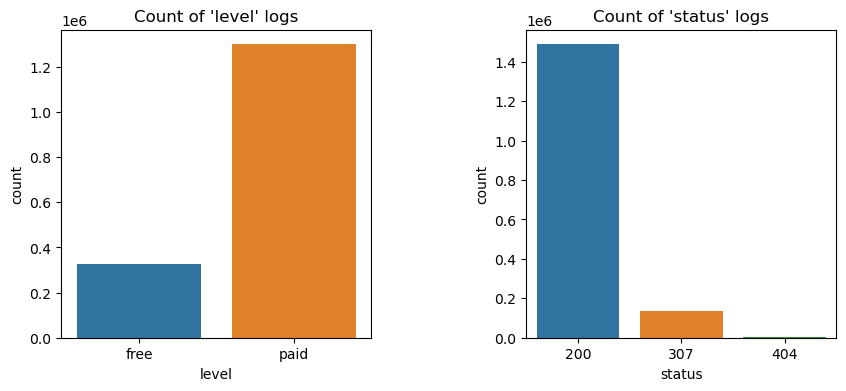

In [37]:
fig = set_plot_size(10, 4);
plt.subplots_adjust(wspace=0.5)

# 1. Count log events by level attribute (paid, free) 
df = data.select('level').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df, x = 'level');
ax = plt.gca()
ax.set_title("Count of 'level' logs");

# 2. Count log events by status categories
df = data.select('status').toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df, x = 'status');
ax = plt.gca()
ax.set_title("Count of 'status' logs");

#### *page*

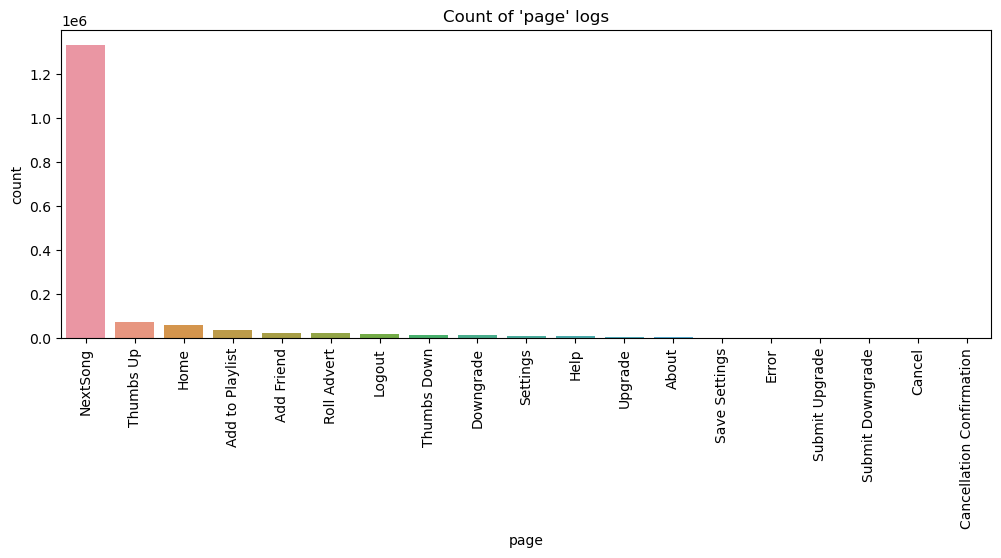

In [38]:
set_plot_size(12, 4)
df = data.select('page').toPandas()
sb.countplot(data = df, x = 'page', order = df['page'].value_counts().index);
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title("Count of 'page' logs");

### User level
A *user level* is a level where data is aggregated by *userId*. We have already met the *user-related* columns which are *userId*-dependent since their value does not change if a log event changes unless the *userId* attribute changes. 

In [39]:
def plot_hist_with_boxplot(df, column, title, bins=15, ):
    """Plots a histogram with boxplot.
    
    Args:
        df (pandas DataFrame): The data set.
        column (str): The name of a target column.  
        title (str): The title of a plot.
        bins (int, optional): The number of histogram's bins.
        
    Returns:
        None
    """
    # Output statistics 
    print(df.describe())
    
    fig = set_plot_size(12, 4);
    spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[5, 1])
    plt.subplots_adjust(hspace=0.3)

    # Plot histogram + boxplot
    ax0 = fig.add_subplot(spec[0])
    ax0.hist(df[column], bins=15)
    ax0.set_title(title);
    plt.xlabel(column)
    plt.ylabel('frequency')
    ax1 = fig.add_subplot(spec[1])
    ax1.boxplot(df[column])

    plt.show()

#### *gender*

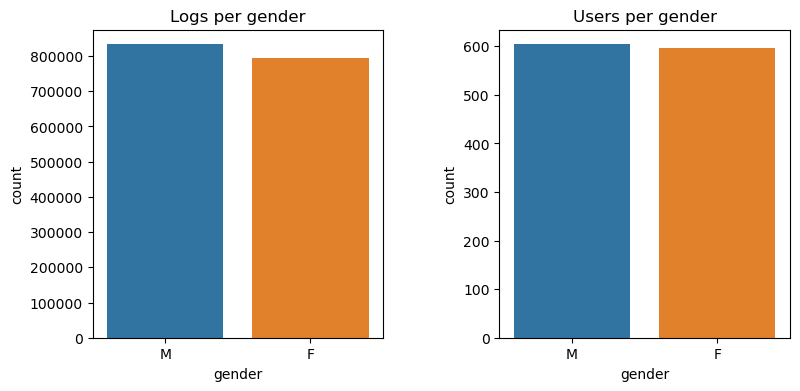

In [40]:
set_plot_size(9, 4);
plt.subplots_adjust(wspace=0.4)

# 1. Count logs per gender
df_gender_logs = data.select('gender').toPandas()
plt.subplot(1, 2, 1)
sb.countplot(data = df_gender_logs, x = 'gender', order = ['M','F']).set_title('Logs per gender');

# 2. Count users per gender
df_gender_users = data.groupby('userId', 'gender').count().toPandas()
plt.subplot(1, 2, 2)
sb.countplot(data = df_gender_users, x = 'gender', order = ['M','F']).set_title('Users per gender');

Male users are more active.

##### state

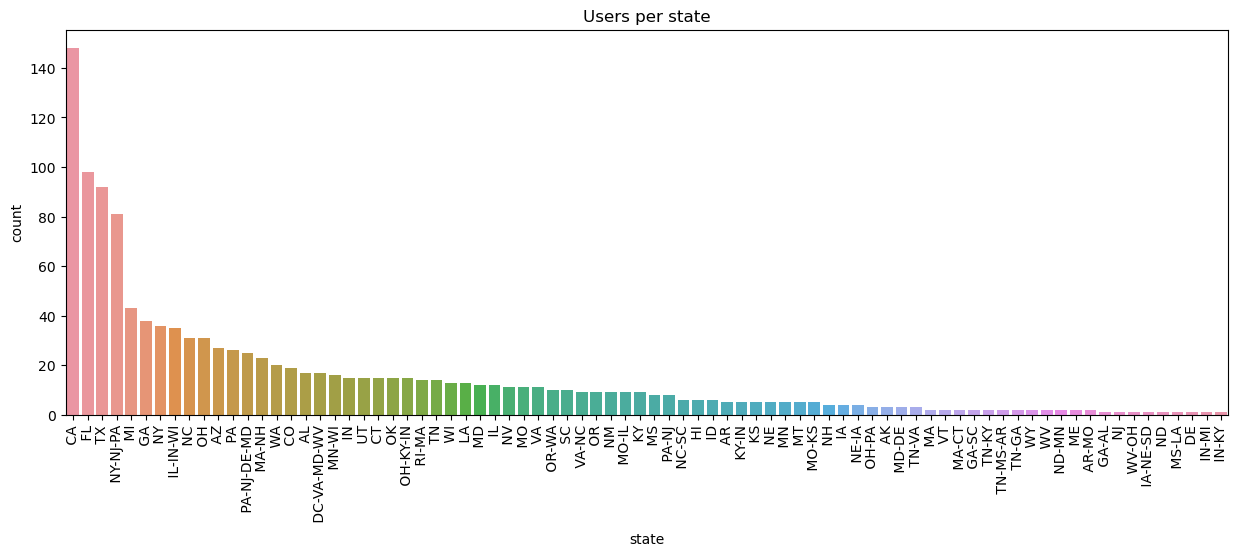

In [41]:
# Count users per state
df_user_state = data.select('userId', 'state').dropDuplicates().toPandas()

set_plot_size(15, 5);
data_order = df_user_state['state'].value_counts().index
sb.countplot(data = df_user_state, x = 'state', order = data_order).set_title('Users per state')
plt.xticks(rotation = 90);
plt.show()

##### Logs per user

              count
count   1200.000000
mean    1354.821667
std     1385.181513
min       10.000000
25%      430.750000
50%      914.500000
75%     1834.250000
max    13591.000000


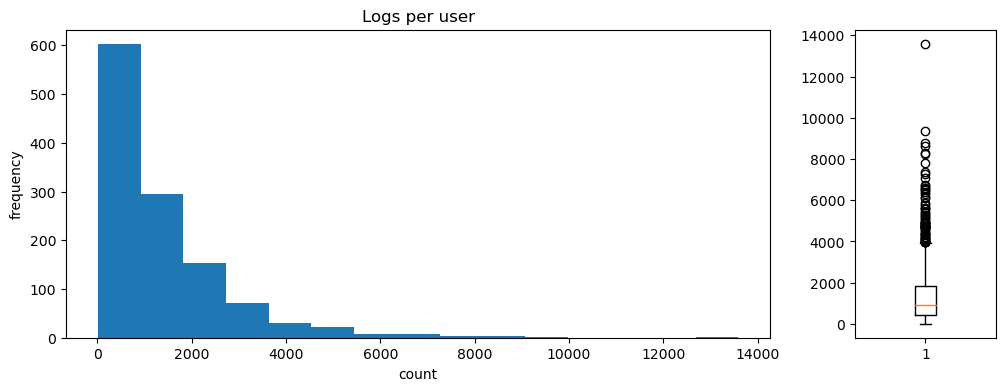

In [42]:
df_user_logs = data.groupby('userId').count().toPandas()
plot_hist_with_boxplot(df_user_logs, 'count', 'Logs per user')

The distribution of logs per user is **right-skewed**. Some extreme outliers can be detected. In general, we may expect that our statistical model will be negatively affected by these outliers.

#### User level: *Sessions per user*

             count
count  1200.000000
mean     15.376667
std      13.479906
min       1.000000
25%       6.000000
50%      12.000000
75%      20.000000
max     125.000000


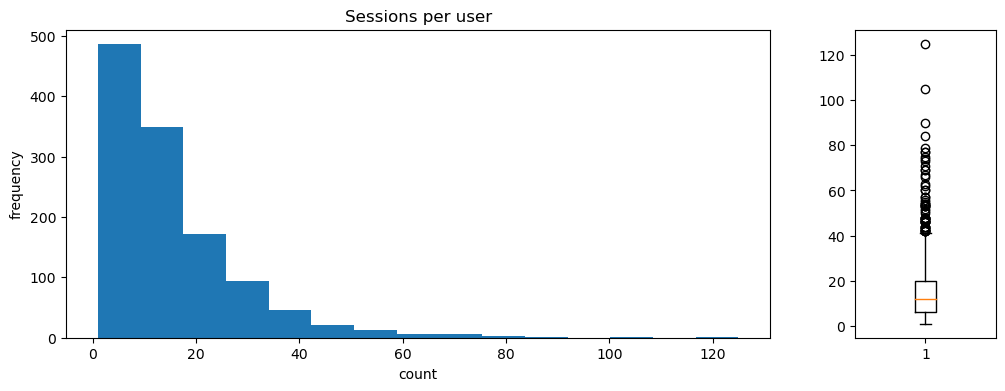

In [43]:
df_user_sessions = data.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().toPandas()
plot_hist_with_boxplot(df_user_sessions, 'count', 'Sessions per user')

The distribution of sessions per user is similar to the distribution of logs per user - *right-skewed*. It is not surprising,  both distributions has a *lower bound* and the data with a lower bound tends to be right-skewed.

### Session level
A *session level* is a level where data is aggregated by *userId*, *sessionId*. Note that the *sessionId* attribute is not a unique identifier of a session; it is unique only for a single user, therefore, as alone cannot be used in a cross-user context.

In [44]:
# Check if two or more users can share the same sessionId - YES
data \
    .select('userId', 'sessionId').dropDuplicates() \
    .groupby('sessionId').count() \
    .where(col('count') > 1) \
    .show(5)

+---------+-----+
|sessionId|count|
+---------+-----+
|    20158|    2|
|    28102|    2|
|    10272|    2|
|     2917|    2|
|    20546|    2|
+---------+-----+
only showing top 5 rows



##### Session duration (in min)

           duration
count  18452.000000
mean     305.014332
std      378.786851
min        0.000000
25%       61.145833
50%      170.075000
75%      398.995833
max     4061.316667


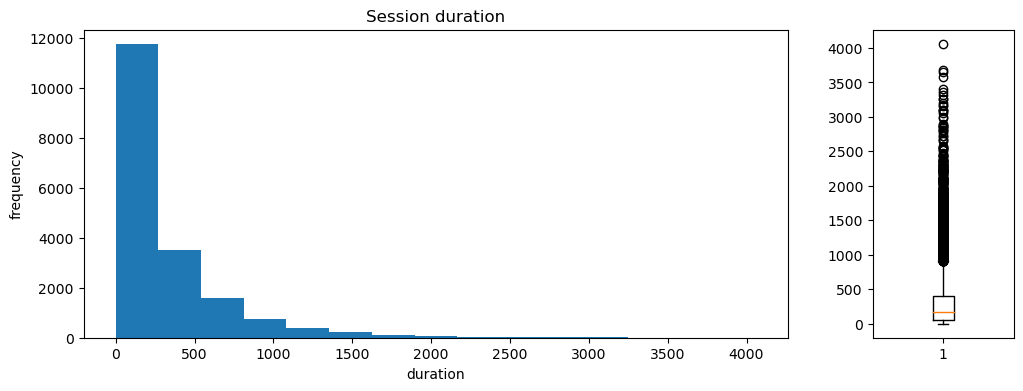

In [45]:
df_session_duration = data.groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .select('duration').toPandas()
plot_hist_with_boxplot(df_session_duration, 'duration', 'Session duration')

### Define Churn

Once we've done some preliminary analysis, create a column `Churn` to use as the label for your model. We use the `Cancellation Confirmation` events to define churn, which happen for both paid and free users. As a extra task, we can also look into the `Downgrade` events.

In [46]:
# Check count of cancelled users
cancelled = data.where(data.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
cancelled.count()

267

In [47]:
# Check count of downgraded users
downgraded = data.where(data.page == 'Submit Downgrade').select('userId').dropDuplicates()
downgraded.count()

331

In [48]:
# Check count of users that downgrade AND cancel the subscription
downgraded.intersect(cancelled).count()

64

#### Decision: Churn type separation

We have **1200** users in total. There are **267** users that cancelled the subscription and **331** users that downgraded. **64** users did both things. Already the number of all users is low, but with so small number of churned users it will be very difficult to create a reliable statistical model that will predict similarly in cases of different random data splits (different *seeds*). 

It could help us if the two churn types can be observed as a *single type*. In that case we would almost duplicate the churn sample. However, before unite both types we have to check if the *cancelled* and *downgraded* users share the **similar statistics**  relevant for our model.

             count
count   267.000000
mean   1185.546816
std    1161.658084
min      24.000000
25%     425.500000
50%     857.000000
75%    1543.000000
max    8274.000000


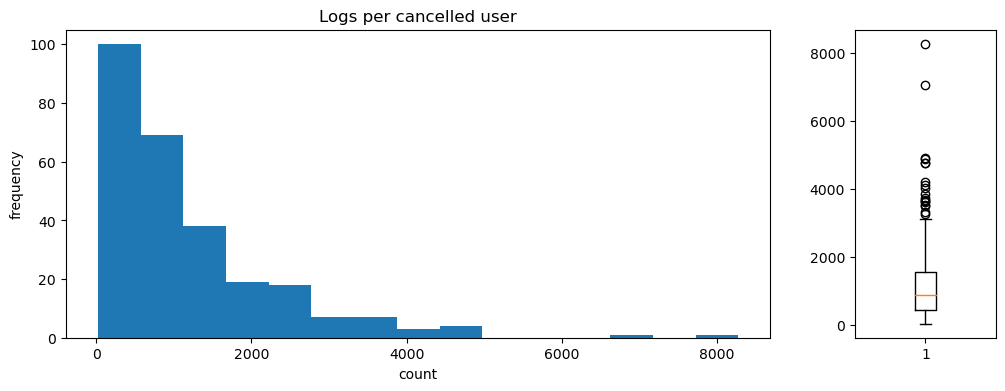

              count
count    331.000000
mean    2269.235650
std     1818.010901
min      177.000000
25%      984.500000
50%     1736.000000
75%     3047.000000
max    13591.000000


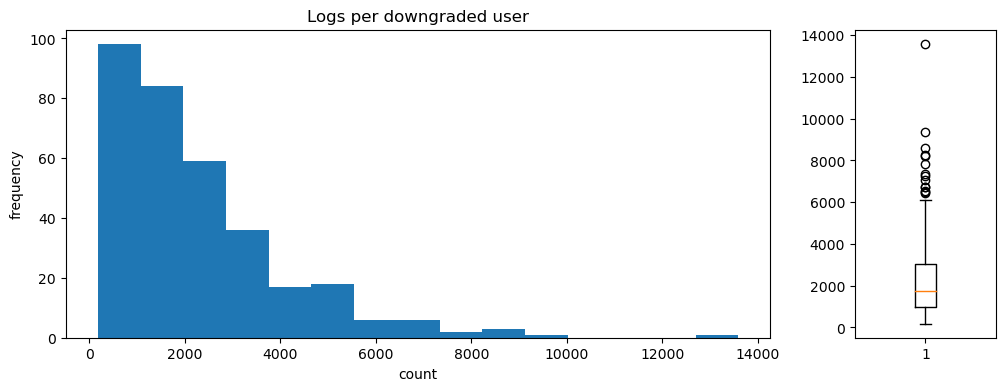

In [49]:
df_user_logs_cancelled = data \
    .where(data.userId.isin([row.userId for row in cancelled.collect()])) \
    .groupby('userId').count().toPandas()

df_user_logs_downgraded = data \
    .where(data.userId.isin([row.userId for row in downgraded.collect()])) \
    .groupby('userId').count().toPandas()
           
plot_hist_with_boxplot(df_user_logs_cancelled, 'count', 'Logs per cancelled user')
plot_hist_with_boxplot(df_user_logs_downgraded, 'count', 'Logs per downgraded user')

Well, the *logs per user* statistics of both churn types *differs considerebly*. All the statisticals values shows huge discrepancies: the *cancelled* users have **1186** logs on average, the *downgraded* users generates much more logs:  **2269** on average which is **1.91** times higher value. The similar behaviour can be found with other statistical values.

The **log count statistics** using the *unaggregated* source data is the most basic statistics we can do. If the two types of churned users do not share the same basic statistics then it is very likely that we face the discrepancies on certain aggregation levels. As we persue a goal to predict well we opt **not to unite both types**. 

We will follow the Udacity suggestion to focus on the first type - the **cancelled** users.

In [50]:
def get_users(churn):
    """Returns unique users of a specified churn group.
    
    Args:
        churn (int): The churn column with Boolean values (0 - non-churned, 1 - churned).
        
    Returns:
        DataFrame: A dataframe query.
    """
    return data.where(data.churn == churn).select('userId').dropDuplicates()

#### Churn of cancelled users

We'll label the *churned* users by **1**, and the *non-churned* users by **0**. Similarly, the variables with the suffix "1" will represent the *churned* users while the variables with the suffix "0" will represent the *non-churned* users. 

According to our terminology, the term "**churn group/class**" which stands for our classification target (*churned*, *non-churned*) shouldn't be confused with the term "**churn type**" which refers to two supposedly distinctive target groups of *cancelled* and *downgraded* users which require separate modelling.

In [51]:
# Label churned (canceled) users
cancelled_uids = [row.userId for row in cancelled.collect()];
set_churn = udf(lambda x: 1 if x in cancelled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))
print(f"Churned users who cancelled subscription: {get_users(1).count()}")

Churned users who cancelled subscription: 267


In [52]:
# Add [userRowId] column that assigns a 1-based index to every user's log ordered by [ts]
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# Add [userRowDescId] column that assigns a 1-based index to every user's log ordered by [ts] descending.
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

In [53]:
# Add lastLevel column
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))
data.take(1)

[Row(userId='1034806.0', status='200', gender='F', length=None, level='free', registration='1533614637000.0', ts='1539745898000', auth='Logged In', page='Roll Advert', sessionId='5227', itemInSession='260', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', song=None, artist=None, method='GET', tsDate=datetime.datetime(2018, 10, 17, 11, 11, 38), date=datetime.date(2018, 10, 17), city='Auburn', state=' NY', churn=0, userRowId=268, userRowDescId=1, lastLevel='free')]

### Explore Data
Once we've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

<a id="section-general-statistical-method"></a>
### General statistical method
Let us describe the *general statistical method* with its simple mathematics that will be used in any exploratory analysis throughout the project.

A certain **feature** $f$ of a user $x$

> $f(x)$

can be important for our learning model only if it can serve us to "distinguish well" between the two churn groups (*churned*, *non-churned*). We use a certain *aggregation* (or **group**) function $g$ like *mean*

> $g(f, y)$  

where *y* is a **churn group** (1 or 0) to determine if the feature $f$ "distinguish well" between the two churn groups. The group function is applied over the subset of users that belong to a specified group *y*. If the absolute value of a difference between the aggregation values is "big enough"

> diff = $|g(f, 1) - g(f, 0)|$ 

we can say that the feature $f$ "distinguish well". However, in order to determine if the value *diff* is "big enough" we have to normalize it. Let

> $g_1$ = $g(f, 1)$ 

and 

> $g_2$ = $g(f, 0)$

Then a **ratio** of *churned* users (for a given feature $f$) is:

> $r_1$ = $\frac{g_1}{g_1 + g_0}$  

Similarly, a *ratio* of *non-churned* users is

> $r_0$ = $\frac{g_0}{g_1 + g_0}$  

Now, let us calculate the difference ($\Delta$) between the both ratios:

> $\Delta$ = $r_1$ - $r_0$ = $\frac{g_1 - g_0}{g_1 + g_0}$ 

which gives us a **ratio difference** with absolute values between 0 and 1. Note that we do not express the ratio difference as an *absolute value* since we want to preserve the sign which will tell as, if **positive**, that the feature $f$ for a group of churned users gives, on average (if *g* is a *mean* function), *higher values* than the same feature $f$ for a group of non-churned users, and, if **negative**, it gives *lower values*.
   
##### Delta threshold
Using the *delta* as a decisive factor for a feature selection is based on the idea that a certain feature is important for our model if and only if it can distinguish "well enough" beetwen the two churn groups. According to some preliminary tests we made with the sample dataset we have seen that a feature can work well for our learning model if the **delta threshold** is set to

> $|\Delta| > 0.10$

which means that there should be **at least 10% of difference** between the churn group ratios in order **to select the feature for our learning model**. 

In [54]:
# Set the delta threshold
delta_threshold = 0.10

# List of churn groups (for bar plots)
churn_groups = ['churned', 'non-churned']

# Reverse list of churn groups (for histogram plots)
churn_groups_reverse = ['non-churned', 'churned']

#### $g$ function

> - The group function $g$ that we'll use in our project calculates the **mean** per churn group. 

In [55]:
def has_attribute(df):
    """Returns true if the data set contains attribute.
    
    Args:
        df (DataFrame): The data set.  
    
    Returns:
        bool: True if df contains an atribute or False if not. 
    """
    return 'attribute' in df.columns

In [56]:
def get_attribute(data, attribute):
    """Collects all unique values of a specified attribute.
    
    Args:
        data (DataFrame): The data set.
        attribute (str): The attribute column name.
        
    Returns:
        attribute (str): The attribute column name 
        list: The list of all unique values of an attribute.
    """
    attr_dict = dict()
    attr_dict['column'] = attribute
    attr_dict['values'] = [row[attribute] for row in unique(data, attribute).collect()]
    return attr_dict

In [57]:
def get_g(f, agg_method='avg'):
    """Gets the group function that returns the aggregated g-values of a feature per churn group. 
    By default the group function calculates mean.
    
    Args:
        f (DataFrame): The feature function dataframe which must contain the following columns:
                           - userId: user identifier
                           - churn: 1-churned, 0-non-churned
                           - f-value: value of an observing feature
                           - attribute (optional): value of an attribute
        agg_method (str, optional): Aggregation method of a g function. The default is 'avg' (mean).
        
    Returns:
        DataFrame: The group function result containing:
                       - churn: 1-churned, 0-non-churned
                       - g-value: value of a group function
                       - attribute (optional): value of an attribute column
    """
    if has_attribute(f) == True:
        return f \
            .groupby('churn', 'attribute') \
            .agg({'f-value': agg_method}) \
            .select('churn', 'attribute', col(f'{agg_method}(f-value)').alias('g-value')) \
            .sort('attribute', desc('churn'))
    else:
         return f \
            .groupby('churn') \
            .agg({'f-value': agg_method}) \
            .select('churn', col(f'{agg_method}(f-value)').alias('g-value')) \
            .sort(desc('churn'))

In [58]:
def calc_delta(g):
    """Calculates the ratios and delta of a feature. If an attribute is given the delta is calculated
    per attribute value.
    
    Args:
        g (DataFrame): The group function which should contain:
                         - churn: 1-churned, 0-non-churned users
                         - g-value: value of a group function
                         - attribute (optional): value of an attribute
        
    Returns:
        deltaset (DataFrame): The statistical result set with the following columns:
                                - churn: 1-churned, 0-non-churned
                                - g-value: result of a group function
                                - ratio: ratio of a feature
                                - delta: delta of a feature
                                - candidate: Is a candidate feature for the learning model?  
                                             (true if delta > delta_threshold; else false)
    """
    if has_attribute(g) == True:
        total = g.groupby('attribute').sum('g-value')
        deltaset = g.alias("g") \
            .join(total.alias("total"), col('g.attribute') == col('total.attribute'), 'inner') \
            .select(col('g.churn'), col('g.attribute'), col('g.g-value'), col('total.sum(g-value)')) \
            .withColumn('ratio', col('g-value')/col('sum(g-value)')) \
            .withColumn('delta', when(col('churn') == 1, 2 * (col('ratio') - 0.5)) \
                                 .otherwise(2 * (0.5 - col('ratio')))) \
            .withColumn('candidate', Fabs(col('delta')) > delta_threshold) \
            .drop('sum(g-value)') \
            .sort(col('attribute'), desc('churn'))        
    else:   
        total = g.groupby().sum('g-value').first()['sum(g-value)']
        deltaset = g \
            .withColumn('ratio', col('g-value')/lit(total)) \
            .withColumn('delta', when(col('churn') == 1, 2 * (col('ratio') - 0.5)) \
                             .otherwise(2 * (0.5 - col('ratio')))) \
            .withColumn('candidate', Fabs(col('delta')) > delta_threshold) \
            .sort(desc('churn'))

    return deltaset

In [59]:
def plot_delta(deltaset, attr_dict=None, title='Analysis per churn group'
               , loc=1, width=None, height=None, rotation=0):
    """Plots the deltaset (bar plot).
    
    Args:
        deltaset (pandas DataFrame): The statistical data with g-values, ratios, and delta. 
        attr_dict (dict, optional): The attribute dictionary with column and values keys.
        title (str): The plot's title.
        loc (int, optional): The location of the plot's legend.
        width (int, optional): The plot width.
        height (int, optional): The plot height.
        rotation (int, optional): The label rotation of the plot's legend.
    Returns:
        None
    """             
    # Convert deltaset to pandas DataFrame and sort values by churn
    df = deltaset.toPandas().sort_values(by='churn', ascending=False)    
    w = 0.35
        
    if attr_dict == None:
        # split dataset into 2 churn subsets
        df1 = df[df.churn == 1]
        df0 = df[df.churn == 0]
        
        # Default width, height
        if width == None:
            width = 4
            height = 4

        set_plot_size(width, height)       
        labels = churn_groups
        plt.xticks([], [])
        plt.xlabel('')       
        middle_line_factor = 0.3
    else:  
        # Split dataset into 2 churn subsets
        df1 = df[df.churn == 1].sort_values(by='attribute')
        df0 = df[df.churn == 0].sort_values(by='attribute')
    
        # Default width, height
        if width == None:
            width = 8
            height = 4
    
        set_plot_size(width, height)    
        labels = attr_dict['values']
        plt.xticks(range(len(labels)), df1['attribute'])
        plt.xlabel(attr_dict['column'])  
        middle_line_factor = 0.9
    
    plt.ylabel('ratio')
    plt.bar(np.arange(len(df1)), df1['ratio'], width=w, color='orange')
    plt.bar(np.arange(len(df0)) + w, df0['ratio'], width=w)
    plt.xticks(rotation=rotation);   
    ax = plt.gca()
    ax.set_title(title);    
    plt.legend(churn_groups, loc=loc) 
     
    # Mark middle line with delta threshold lines
    plt.axhline(y=0.5, xmin=0, xmax=1, color='grey', linestyle=':', linewidth=1)
 
    plt.show()

In [60]:
def analyse(g, attr_dict=None, title='Analysis per churn group', loc=1, width=None, height=None, rotation=0):
    """Analyses a specified feature calculating the g-values, ratios, delta, and plots the statistics.
    
    Args:
        g (DataFrame): The group function which should contain:
                         - churn: 1-churned, 0-non-churned users
                         - g-value: value of a group function
                         - attribute (optional): value of an attribute
        attr_dict (dict, optional): The attribute dictionary with column and values keys.
        title (str): The plot's title.
        loc (int, optional): The location of the plot's legend.
        width (int, optional): The plot width.
        height (int, optional): The plot height.
        rotation (int, optional): The label rotation of the plot's legend.       
    Returns:
        delta_df (pandas DataFrame): The statistical result set with the following columns:
                                         - churn: 1-churned, 0-non-churned
                                         - g-value: result of a group function
                                         - ratio: ratio of a feature
                                         - delta: delta of a feature
                                         - over_threshold: true if delta > delta_threshold; else false        
    """
    if has_attribute(g) == True:
        deltaset = calc_delta(g).select('churn', 'attribute' \
                                   , Fround('g-value', 6).alias('g-value') \
                                   , Fround('ratio', 6).alias('ratio') \
                                   , Fround('delta', 6).alias('delta') \
                                   , 'candidate') \
        
    else:
        deltaset = calc_delta(g).select('churn' \
                                   , Fround('g-value', 6).alias('g-value') \
                                   , Fround('ratio', 6).alias('ratio') \
                                   , Fround('delta', 6).alias('delta') \
                                   , 'candidate') \
        
    deltaset.show(100, False)
    plot_delta(deltaset, attr_dict, title, loc, width, height, rotation)
    return deltaset

In [61]:
def plot_hist(f, attr_dict=None, title=None, bins=15, width=15, height=3):
    """Plots a histogram of f-values for each churn group.
    
    Args:
        f (DataFrame): The feature function dataframe which must contain the following columns:
                         - userId: user identifier
                         - churn: 1-churned, 0-non-churned
                         - f-value: value of an observing feature
                         - attribute (optional): value of an attribute
        attr_dict (dict, optional): The attribute dictionary with column and values keys.
        title (str, optional): The title of a histogram.
        bins (int, optional): The number of histogram's bins.
        width (int, optional): The plot width.
        height (int, optional): The plot height.
        
    Returns:
        None
    """
    # Get pandas DataFrame
    df = f.toPandas()
    
    # Split by churn
    df1 = df[df.churn == 1]
    df0 = df[df.churn == 0]
    column = 'f-value'
        
    fig = set_plot_size(width, height);
    
    # Plot a single histogram
    if attr_dict == None:
        spec = gridspec.GridSpec(ncols=1, nrows=1)
        ax = fig.add_subplot(spec[0])
        ax.hist(df0[column], bins=15)
        ax.hist(df1[column], bins=15, color='orange')       
        if title != None:
            ax.set_title(title);           
        plt.xlabel(column)
        plt.ylabel('frequency')
        plt.legend(churn_groups_reverse, loc=1) 
        plt.show()
        return
    
    # Plot multiple histograms, each per attribute distict value
    n_subplots = len(attr_dict['values'])
    ncols = 3
    nrows = math.ceil(n_subplots/ncols)   
    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, hspace=0.4)

    i = 0
    for value in attr_dict['values']:
        # Filter f-values by attribute
        df1_attr = df1[df1['attribute'] == value]
        df0_attr = df0[df0['attribute'] == value]

        ax = fig.add_subplot(spec[i])
        ax.hist(df0_attr[column], bins=15)
        ax.hist(df1_attr[column], bins=15, color='orange')
        ax.set_title(f'Log distribution of {attr_dict["column"]}={value}');
        plt.xlabel(column)
        plt.ylabel('frequency')    
        plt.legend(churn_groups_reverse, loc=1) 
        i += 1

    plt.show()

### Log level

##### Log count
> - The feature function $f$ returns the **log count** per user. 
> - The group function $g$ returns the **average log count** per churn group.

+-----+-----------+-------+---------+---------+
|churn|g-value    |ratio  |delta    |candidate|
+-----+-----------+-------+---------+---------+
|1    |1185.546816|0.45795|-0.084099|false    |
|0    |1403.263666|0.54205|-0.084099|false    |
+-----+-----------+-------+---------+---------+



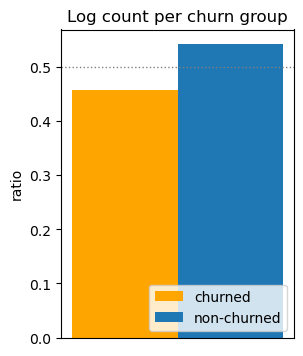

In [62]:
# Define f function and analyse it
f_LogCount = data \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g = get_g(f_LogCount)

analyse(g, None, title='Log count per churn group', loc=4, width=3, height=4);

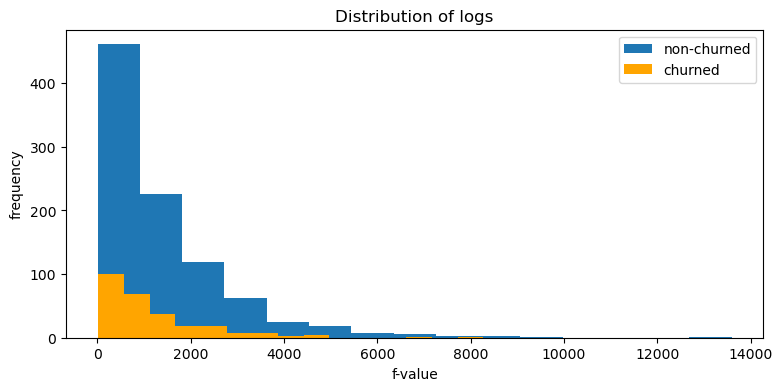

In [63]:
# Show distribution of f-values
plot_hist(f_LogCount, None, 'Distribution of logs', width=9, height=4)

##### Log attribute count
> - The feature function $f$ returns the **log attribute count** per user. 
> - The group function $g$ return the **average log attribute count** per churn group.

In [64]:
def get_f_LogAttributeCount(data, attribute):
    """Returns the feature function for log attribute count statistics.
    
    Args:
        data (DataFrame): The data set.
        attribute (str): The attribute column name.
    """
    return data \
        .groupby('userId', 'churn', col(attribute).alias('attribute')) \
        .agg(count(attribute).alias('f-value'))

##### gender

+-----+---------+-----------+--------+---------+---------+
|churn|attribute|g-value    |ratio   |delta    |candidate|
+-----+---------+-----------+--------+---------+---------+
|1    |F        |1134.984962|0.450101|-0.099799|false    |
|0    |F        |1386.639309|0.549899|-0.099799|false    |
|1    |M        |1235.731343|0.46537 |-0.069259|false    |
|0    |M        |1419.640426|0.53463 |-0.069259|false    |
+-----+---------+-----------+--------+---------+---------+



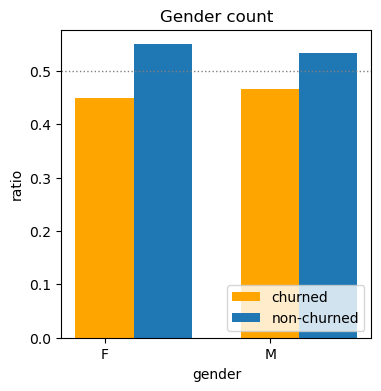

In [65]:
#spark.sql.analyzer.failAmbiguousSelfJoin = False
# Get f function by attribute and analyse it
f_GenderCount = get_f_LogAttributeCount(data, 'gender')

# Get g function
g = get_g(f_GenderCount)

# Define attribute
attr_dict = get_attribute(data, 'gender')

analyse(g, attr_dict=attr_dict, title='Gender count', loc=4, width=4, height=4);

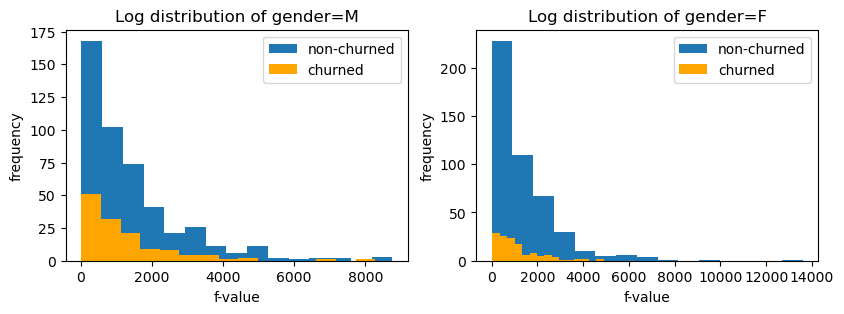

In [66]:
# Show distribution of f-values
plot_hist(f_GenderCount, attr_dict, 'Distribution of logs')

##### method

+-----+---------+-----------+--------+---------+---------+
|churn|attribute|g-value    |ratio   |delta    |candidate|
+-----+---------+-----------+--------+---------+---------+
|1    |GET      |94.134831  |0.480761|-0.038477|false    |
|0    |GET      |101.66881  |0.519239|-0.038477|false    |
|1    |PUT      |1091.411985|0.456084|-0.087832|false    |
|0    |PUT      |1301.594855|0.543916|-0.087832|false    |
+-----+---------+-----------+--------+---------+---------+



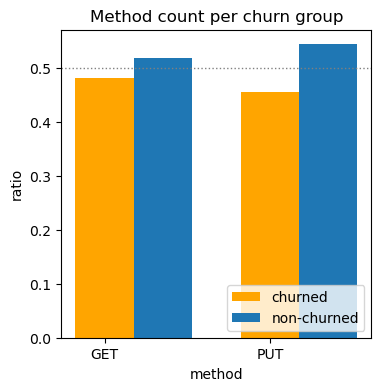

In [67]:
# Get f function by attribute and analyse it
f_MethodCount = get_f_LogAttributeCount(data, 'method')

# Get g function
g = get_g(f_MethodCount)

# Define attribute
attr_dict = get_attribute(data, 'method')

analyse(g, attr_dict=attr_dict, title='Method count per churn group', loc=4, width=4, height=4);

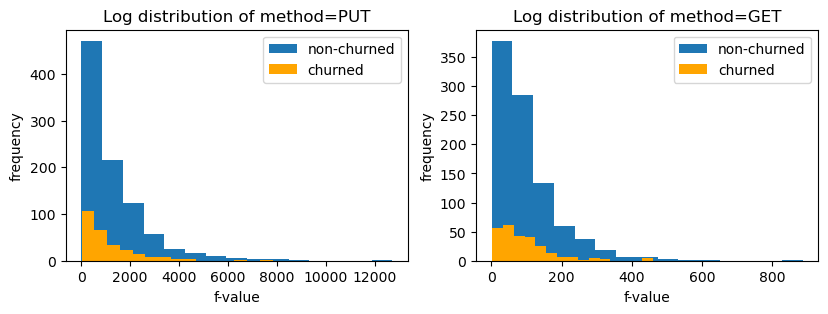

In [68]:
# Show distribution of f-values
plot_hist(f_MethodCount, attr_dict, 'Distribution of method logs', 'method')

##### status

+-----+---------+-----------+--------+---------+---------+
|churn|attribute|g-value    |ratio   |delta    |candidate|
+-----+---------+-----------+--------+---------+---------+
|1    |200      |1087.044944|0.458365|-0.083271|false    |
|0    |200      |1284.527331|0.541635|-0.083271|false    |
|1    |307      |97.307116  |0.453109|-0.093783|false    |
|0    |307      |117.447425 |0.546891|-0.093783|false    |
|1    |404      |2.14094    |0.479506|-0.040987|false    |
|0    |404      |2.323944   |0.520494|-0.040987|false    |
+-----+---------+-----------+--------+---------+---------+



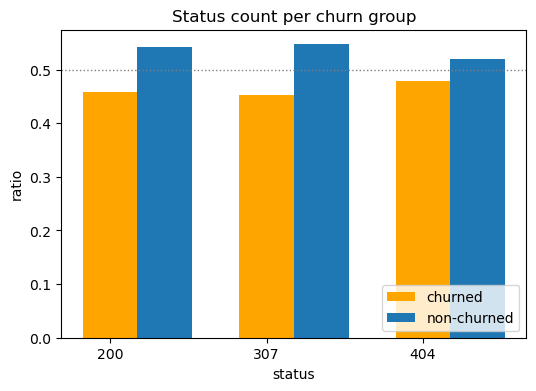

In [69]:
# Get f function by attribute and analyse it
f_StatusCount = get_f_LogAttributeCount(data, 'status')

# Get g function
g = get_g(f_StatusCount)

# Define attribute
attr_dict = get_attribute(data, 'status')

analyse(g, attr_dict=attr_dict, title='Status count per churn group', loc=4, width=6, height=4);

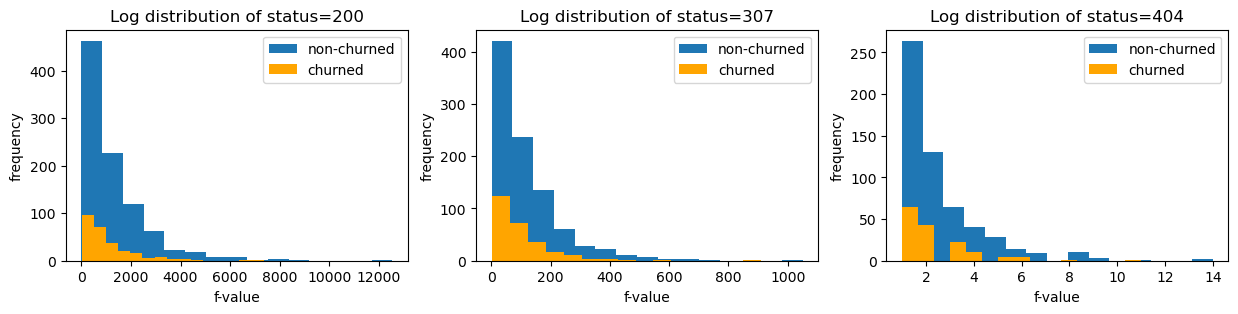

In [70]:
# Show distribution of f-values
plot_hist(f_StatusCount, attr_dict, 'Distribution of status logs', bins=15, width=15, height=3)

### User level

In [71]:
# Get churn group count
count1 = get_users(1).count()
count0 = get_users(0).count()
count1, count0

(267, 933)

In [72]:
def get_f_UserAttribute(data, attribute):
    """Returns the feature function of a user attribute.
    
    Args:
        data (DataFrame): The data set.
        attribute (str): The attribute column name.
    """
    return data \
        .select('userId', 'churn', col(attribute).alias('attribute')) \
        .dropDuplicates() \
        .withColumn('f-value', lit(1)) # the user attribute has f-value of 1 (counts as 1)

def get_g_UserAttribute(f, attribute):
    """Returns the group function of a user attribute.
    
    Args:
        data (DataFrame): The data set.
        attribute (str): The attribute column name.
    """
    return f \
        .withColumn('total', when(col('churn') == 1, count1).otherwise(count0)) \
        .groupby('churn', 'total', 'attribute') \
        .agg(Fsum('f-value')/col('total')) \
        .select('churn', 'total', 'attribute', col('(sum(f-value) / total)').alias('g-value')) \
        .sort('attribute', desc('churn'))

##### gender
> - The feature function $f$ returns the **f-value of 1 per user**.
> - The group function $g$ returns the **gender ratio per churn**. 

+-----+---------+--------+--------+---------+---------+
|churn|attribute|g-value |ratio   |delta    |candidate|
+-----+---------+--------+--------+---------+---------+
|1    |F        |0.498127|0.500945|0.001889 |false    |
|0    |F        |0.496249|0.499055|0.001889 |false    |
|1    |M        |0.501873|0.499066|-0.001868|false    |
|0    |M        |0.503751|0.500934|-0.001868|false    |
+-----+---------+--------+--------+---------+---------+



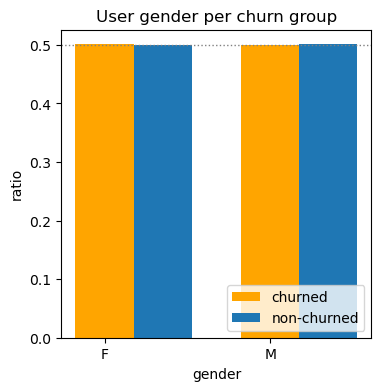

In [73]:
# Get f function
f_UserGender = get_f_UserAttribute(data, 'gender')

# Get g function
g_UserGender = get_g_UserAttribute(f_UserGender, 'gender')

# Define attribute
attr_dict = get_attribute(data, 'gender')

analyse(g_UserGender, attr_dict=attr_dict, title='User gender per churn group', loc=4, width=4, height=4);

##### Last level
> - The feature function $f$ returns the **f-value of 1 per user**.
> - The group function $g$ returns the **last level ratio per churn**.

+-----+---------+--------+--------+---------+---------+
|churn|attribute|g-value |ratio   |delta    |candidate|
+-----+---------+--------+--------+---------+---------+
|1    |free     |0.258427|0.431241|-0.137517|true     |
|0    |free     |0.340836|0.568759|-0.137517|true     |
|1    |paid     |0.741573|0.529416|0.058833 |false    |
|0    |paid     |0.659164|0.470584|0.058833 |false    |
+-----+---------+--------+--------+---------+---------+



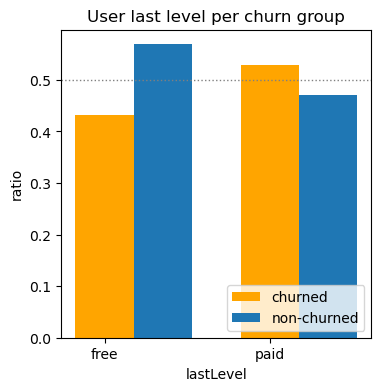

In [74]:
# Get f function
f_UserLastLevel = get_f_UserAttribute(data, 'lastLevel')

# Get g function
g_UserLastLevel = get_g_UserAttribute(f_UserLastLevel, 'lastLevel')

# Define attribute
attr_dict = get_attribute(data, 'lastLevel')

analyse(g_UserLastLevel, attr_dict=attr_dict, title='User last level per churn group', loc=4, width=4, height=4);

##### level per day

The subscription level (*free*, *paid*) is **user-time** dependent. It belongs to a user and the user can change it in time.

*Helper functions:*

In [75]:
def convert_to_date(date_str):
    """Converts date string to date object.
    
    Args:
        date_str (str): The date string in format YYYY-mm-dd.
        
    Returns:
        datetime: The datetime object.
    """
    return datetime.datetime.strptime(date_str, '%Y-%m-%d').date()

def get_date_str(month, day):
    """Gets date string from month and day parameter. 
    Note: The default observation year 2018 is used.
    
    Args:
        month (int): The month value.
        day (int): The day value.
        
    Returns:
        str: The date string.
    """
    return '2018-' + str(month).zfill(2) + '-' + str(day).zfill(2)

def get_date(month, day):
    """Gets date object.
    
    Args:
        month (int): The month value.
        day (int): The day value.
        
    Returns:
        date: The date object.
    """
    try:
        date_str = get_date_str(month, day)
        return datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
    except ValueError:
        return None   

def validate_date(month, day):
    """Validates the date.
    
    Args:
        month (int): The month value.
        day (int): The day value.
        
    Returns:
        bool: True, if the date string built of month, day parameters is a valid date; else false.
    """
    try:
        date_str = get_date_str(month, day)
        datetime.datetime.strptime(date_str, '%Y-%m-%d')
        return True
    except ValueError:
        return False   
    
def get_dates_gen(date1, date2):
    """Gets date generator that returns (month, day) tuple between date1 and date2. 
    
    Args:
        date1 (date): The date1 value.
        date1 (date): The date2 value.
        
    Returns:
        date: Fetches the next date value.
    """    
    for m in range(date1.month, date2.month+1):
        for d in range(1, 31+1):
            date = get_date(m, d)
            if date == None or date <= date1 or date >= date2:
                continue                      
            yield date    

def get_ut_row(userId, date, level):
    """Gets user per time matrix row.
    
    Args:
        userId (str): The userId value.
        date (date): The date value.
        level (str): The level value.
        
    Returns:
        object: The object with userId, date, and level values.
    """        
    return {
        'userId': userId,
        'date': date,
        'level': level
    }

def get_default_date():
    """
    Gets the date from the beginning of the observation period.
    """          
    return datetime.datetime.strptime('2018-09-30', '%Y-%m-%d').date()


*Extract user-time distinct rows with level value:*

In [76]:
extracted = data \
    .groupby('userId', 'date') \
    .agg(max('userRowId').alias('rowid')) \
    .select(col('userId').alias('uid'), 'date', 'rowid')
    
# Note: if a user has more than 1 different level per day, then we take the last level
user_time_rows = extracted.alias("extracted") \
    .join(data.alias("data"), (col("extracted.uid") == col("data.userId")) & (col("extracted.rowid") == col("data.userRowId")), how='inner') \
    .select(col("data.userId"), col("extracted.date"), col("data.level")) \
    .sort('userId', 'date') \
    .collect()

*Add missing user-time rows:*

In [77]:
# Observation period
data.agg(min('date'), max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-01|
+----------+----------+



In [78]:
# Build the user-time dimension matrix for the whole observation period from Oct 1, 2018 to Dec 1, 2018.
# Important: if in time t2 the user has no user_time row, then it holds:
#    level(user, t2) = level(user, t1)

# User set
users = {row.userId for row in user_time_rows}

# User-time dimension matrix
ut_matrix = []

# Current user-time level - fill it with default (None) values 
current_levels = dict()
for userId in users:
    current_levels[userId] = None

# Convert user_time rows into pandas dataframe (for easier filtering)
utdf = pd.DataFrame(user_time_rows)
utdf.columns = ['userId', 'date', 'level']

# Current dimension variables - defaults are set on Sept 30
last_userId, last_date = '-1', get_default_date()

# Loop through the user-time rows sorted by userId, month, day
for row in user_time_rows:
    
    userId = row.userId
    
    # Reset last date when user changes
    if userId != last_userId:
        last_date = get_default_date()
    
    # Get current user level
    last_level = current_levels[userId]
    
    # Add missing dimensions (up till current row date)
    #   level := last_level
    # Note: we skip None levels that represent missing logs before the first user log.
    if last_level != None:
        for date in get_dates_gen(last_date, row.date):
            ut_matrix.append(get_ut_row(userId, date, last_level))
        
    # Add level for current row date
    ut_matrix.append(get_ut_row(userId, row.date, row.level))
       
    # Handle history variables
    last_date = row.date       
    last_userId = userId
    current_levels[userId] = row.level

*Calculate the level ratio per churn group, for each day in the observation period:*

In [79]:
# Prepare churn data
churn_df = data.select('userId', 'churn').dropDuplicates().toPandas()

# Convert user_time matrix to pandas framework
ut_df = pd.DataFrame(ut_matrix)
ut_df = ut_df[['userId', 'date', 'level']]

# Add churn indicator
ut_df = ut_df.merge(churn_df, on='userId')

In [80]:
# Prepare agg totals per day and churn group
level_totals_df = ut_df \
    .groupby(['churn', 'date']) \
    .size() \
    .reset_index(name='count') \
    .rename(columns={'count': 'total'})

# Create level share dataframe
level_ratio_df = ut_df \
    .groupby(['churn', 'date', 'level']) \
    .size() \
    .reset_index(name='count') \
    .merge(level_totals_df, on=['churn', 'date'])
    
# Calc ratio
level_ratio_df['ratio'] = level_ratio_df['count']/level_ratio_df['total']

*Plot total count of level category per day:*

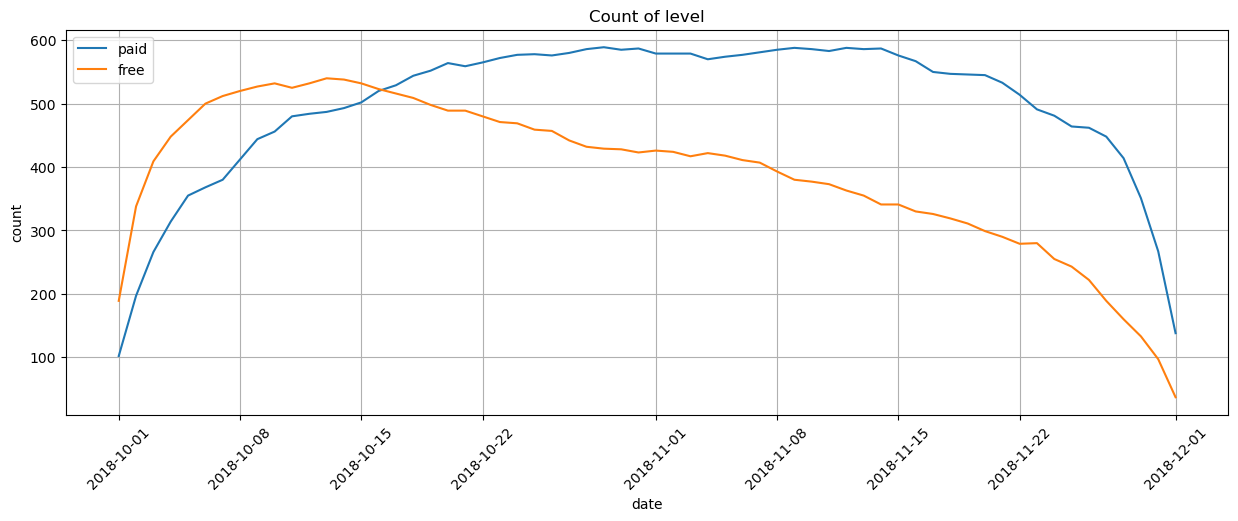

In [81]:
# Prepare agg totals per day and churn group
level_count_df = ut_df \
    .groupby(['level', 'date']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(by=['date'])

# Plot
paid = level_count_df[level_count_df.level == 'paid']['count']
free = level_count_df[level_count_df.level == 'free']['count']
dates_paid = level_count_df[level_count_df.level == 'paid']['date']
dates_free = level_count_df[level_count_df.level == 'free']['date']

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

ax.plot(dates_paid, paid)
ax.plot(dates_free, free)

ax.set(xlabel='date', ylabel='count', title='Count of level')
ax.grid()
plt.legend(['paid', 'free'], loc=2)
plt.xticks(rotation = 45);
plt.show()

*Plot level ratio per churn group per day:*

In [82]:
def plot_level_ratio(df, level):
    """Plots level ratio along day timeline.
    
    Args:
        df (pandas DataFrame): The data set.
        level (str): The level value.
        
    Returns:
        None
    """
    df_ratio = df[(df.level == level)]

    ratios0 = df_ratio[df_ratio.churn == 0]['ratio']
    ratios1 = df_ratio[df_ratio.churn == 1]['ratio']
    dates0 = df_ratio[df_ratio.churn == 0]['date']
    dates1 = df_ratio[df_ratio.churn == 1]['date']

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)

    # plot both lines
    ax.plot(dates0, ratios0)
    ax.plot(dates1, ratios1)

    ax.set(xlabel='date', ylabel='ratio', title="Ratio of level='" + level + "'")
    ax.grid()
    plt.legend(['non-churned', 'churned'], loc=2)
    plt.xticks(rotation = 45);
    plt.show()

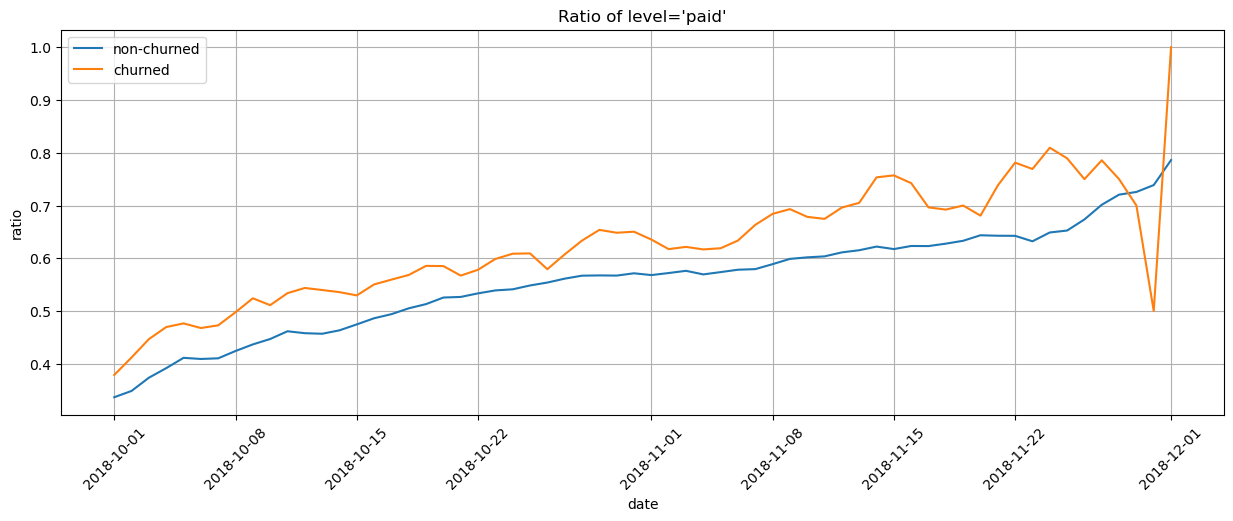

In [83]:
plot_level_ratio(level_ratio_df, 'paid')

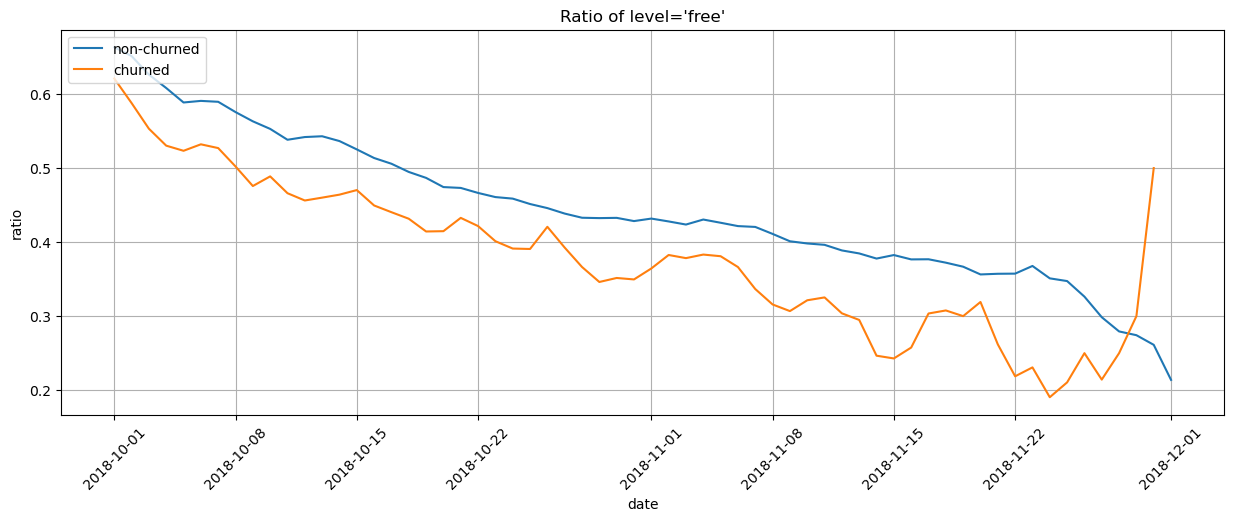

In [84]:
plot_level_ratio(level_ratio_df, 'free')

### Song level

##### Song count
> - The feature function $f$ returns the **song count per user**.
> - The group function $g$ returns the **average song count per churn**.

+-----+-----------+--------+---------+---------+
|churn|g-value    |ratio   |delta    |candidate|
+-----+-----------+--------+---------+---------+
|1    |966.895131 |0.456502|-0.086996|false    |
|0    |1151.156484|0.543498|-0.086996|false    |
+-----+-----------+--------+---------+---------+



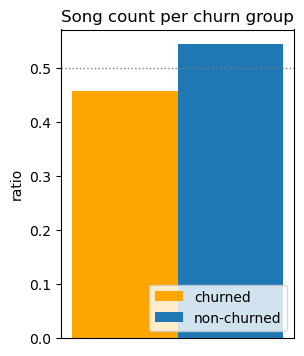

In [85]:
# Define f function - we are using the same function f that was used for the NextSong log page attribute. 
f_SongCount = get_f_LogAttributeCount(data, 'page') \
    .where(col('attribute') == 'NextSong') \
    .select('userId', 'churn', 'f-value')

g_SongCount = get_g(f_SongCount)

analyse(g_SongCount, None, title='Song count per churn group', loc=4, width=3, height=4);

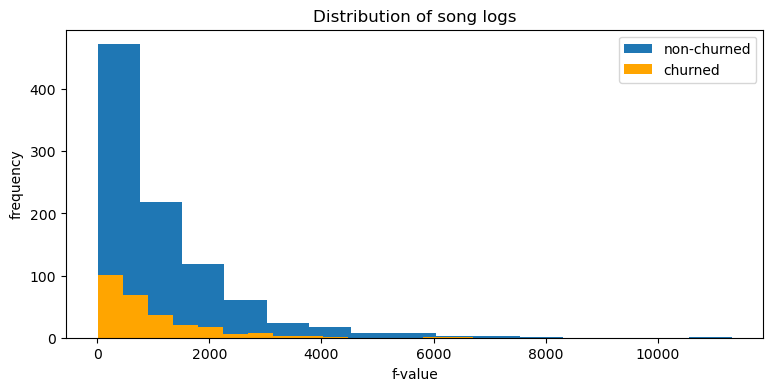

In [86]:
# Show distribution of f-values
plot_hist(f_SongCount, None, 'Distribution of song logs', bins=15, width=9, height=4)

In [87]:
def plot_timeline(g, title, timeunit, rotation=0):
    """Plots statistical values on a timeline of a specified time unit.
    
    Args:
        g (DataFrame): The group function.
        title (str): The plot's title.
        timeunit (str): The time unit of a timeline.
        rotation (int, optional): The label rotation of the plot's legend. 
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 4)

    # convert g result set to pandas DataFrame and split it by churn
    df = g.toPandas()
    df0 = df[df.churn == 0]
    df1 = df[df.churn == 1]
    
    ax.plot(df0['attribute'], df0['g-value'])
    ax.plot(df1['attribute'], df1['g-value'])
    ax.set(xlabel=timeunit, ylabel='g-value', title=title)
    ax.grid()
    plt.legend(['non-churned', 'churned'], loc=2)
    plt.xticks(rotation = rotation);
    plt.show()

##### "Plain" song count per day

Let us examine first the aggregation result of the **song count per day, per churn** using a "plain" $g$ function without the $f$ function. In other words, the aggregation is not made over the f-values (which are *user-based*) but by counting the observing *song* attribute directly over all members of the churn group. 

In [88]:
# Define the "plain" g function
g_SongCountPerDay_plain = data \
    .where(data.page == 'NextSong') \
    .groupby('churn', 'date') \
    .count() \
    .select('churn', col('date').alias('attribute'), col('count').alias('g-value')) \
    .sort('attribute')

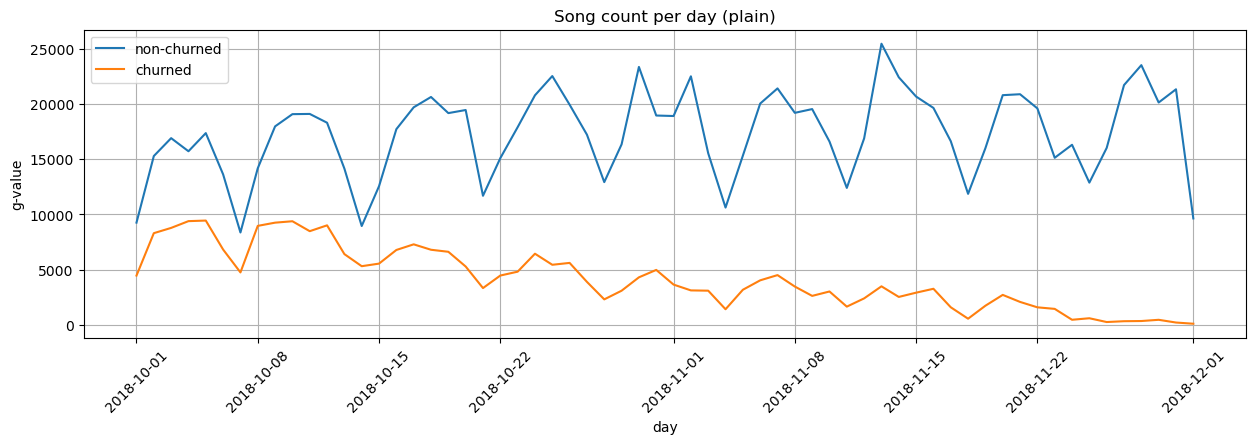

In [89]:
plot_timeline(g_SongCountPerDay_plain, 'Song count per day (plain)', 'day', 45)

##### Song count per day

Now we'll check the aggregation using the corresponding *user-based* $f$ function.

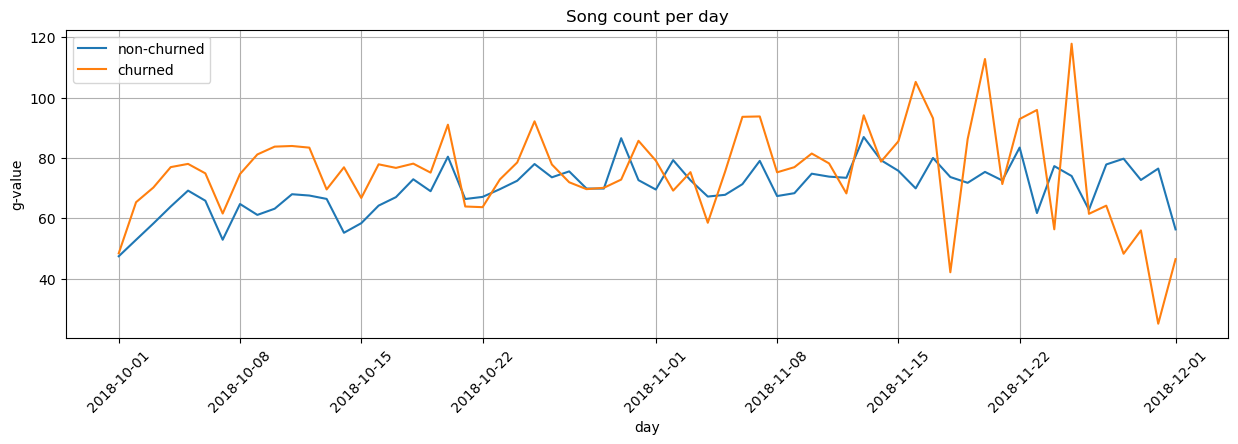

In [90]:
# Define f function
f_SongCountPerDay = data \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', col('date').alias('attribute')) \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerDay = get_g(f_SongCountPerDay)

# Plot it
plot_timeline(g_SongCountPerDay, 'Song count per day', 'day', 45)

While the **plain aggregation** shows substantial difference between the observed *g-values* of the both churn groups, the aggregation of the $f$ function reveals totally different picture: the *g-values* are not clearly separated, on the contrary, their lines swing crossing each other many times.

If we calculate the delta *over the whole observation period* it is even more clear the difference between the two types of aggregations we have made.   

In [91]:
g_plain = g_SongCountPerDay_plain \
    .groupby('churn') \
    .agg(Fsum('g-value').alias('g-value'))
deltaset = calc_delta(g_plain)
deltaset.show()

+-----+-------+------------------+-------------------+---------+
|churn|g-value|             ratio|              delta|candidate|
+-----+-------+------------------+-------------------+---------+
|    1| 258161|0.1937869222858601|-0.6124261554282797|     true|
|    0|1074029|0.8062130777141399|-0.6124261554282797|     true|
+-----+-------+------------------+-------------------+---------+



In [92]:
g = g_SongCountPerDay \
    .groupby('churn') \
    .agg(Fsum('g-value').alias('g-value'))
deltaset = calc_delta(g)
deltaset.show()

+-----+-----------------+------------------+-------------------+---------+
|churn|          g-value|             ratio|              delta|candidate|
+-----+-----------------+------------------+-------------------+---------+
|    1|4672.337472935592|0.5182946965170444|0.03658939303408881|    false|
|    0|4342.490393013716|0.4817053034829556|0.03658939303408881|    false|
+-----+-----------------+------------------+-------------------+---------+



Suppose that each user from both churn groups listen **1** song per day (*f-value*). In case of using the *user-based* $f$ function we calculate the churn average per day which would give us **1** at any date (since every user listens exactly **1** song per day). The graph would be a horizontal line since both lines would perfectly overlap. 

On the other side, the plain aggregation counts the total of song logs per each churn group. If there are 267 churned users and 933 non-churned, then the delta is

> $\Delta$ = $\frac{267-933}{1200}$ = -0.56

which is close to **-0.61** of the plain aggregation. Matematically, we haven't *normalized* our observed values when we applied the plain aggregation. Since the weight of the *non-churned* group is higher due to having more members, this initial difference in weights between the both churn groups must be normalized by the proper preparation of *f-values* which is: 

> **The group function $g$ must always apply aggregation over the feature function $f$ which exposes f-values calculated *per user***. 

##### Song count per week of year

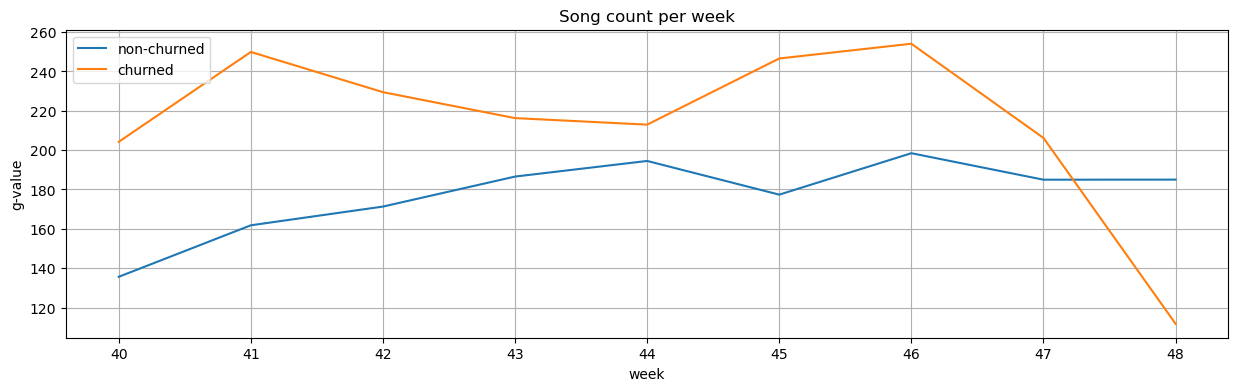

In [93]:
# Define f function
f_SongCountPerWeek = data \
    .withColumn('weekOfYear', date_format(col('tsDate'), "w")) \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', col('weekOfYear').alias('attribute')) \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerWeek = get_g(f_SongCountPerWeek)

# Plot it
plot_timeline(g_SongCountPerWeek, 'Song count per week', 'week')

In [94]:
# Delta over the whole observation period
g = g_SongCountPerWeek \
    .groupby('churn') \
    .agg(Fsum('g-value').alias('g-value'))
deltaset = calc_delta(g)
deltaset.show()

+-----+------------------+-------------------+-------------------+---------+
|churn|           g-value|              ratio|              delta|candidate|
+-----+------------------+-------------------+-------------------+---------+
|    1|1931.3678220519819| 0.5475958946621544|0.09519178932430883|    false|
|    0|1595.6268849546539|0.45240410533784564|0.09519178932430872|    false|
+-----+------------------+-------------------+-------------------+---------+



##### Song count per day of week

In [95]:
# Define f function
f_SongCountPerDayOfWeek = data \
    .withColumn('dayOfWeek', date_format(col('date'), 'E')) \
    .withColumn('dayOfWeekNum', date_format(col('date'), "u")) \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', 'dayOfWeekNum', 'dayOfWeek') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerDayOfWeek = f_SongCountPerDayOfWeek \
    .groupby('churn', 'dayOfWeekNum', 'dayOfWeek') \
    .agg(avg('f-value').alias('g-value')) \
    .sort('dayOfWeekNum')

/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_56832/3480997422.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


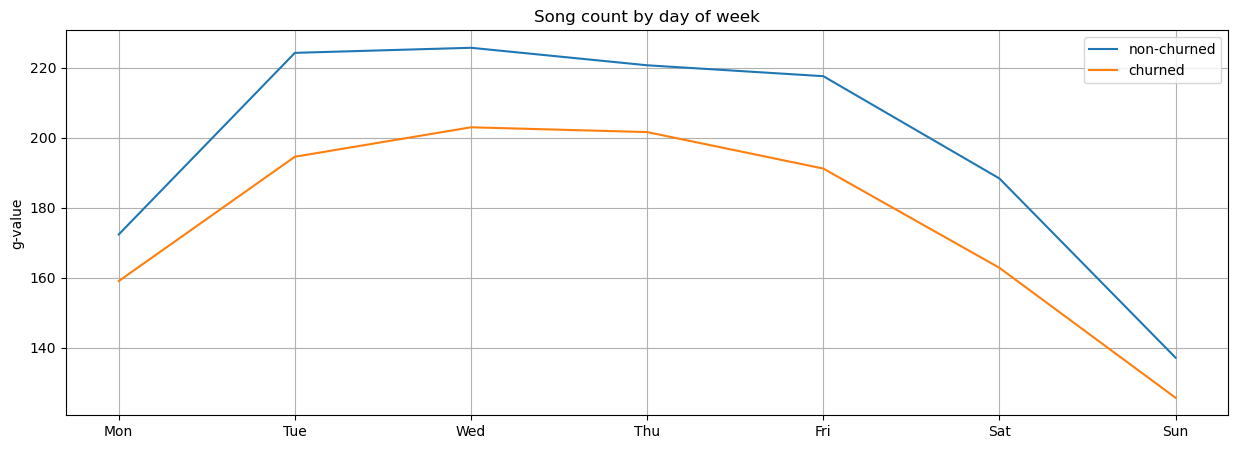

In [96]:
# Plot it
df = g_SongCountPerDayOfWeek.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

# split by churn
df0 = df[df.churn == 0]
df1 = df[df.churn == 1]
ax.plot(df0['dayOfWeekNum'], df0['g-value'])
ax.plot(df1['dayOfWeekNum'], df1['g-value'])

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xticklabels(labels)
ax.grid()
ax.set_ylabel('g-value')
ax.set_title('Song count by day of week')
plt.legend(['non-churned', 'churned'], loc=1)
plt.show()

In [97]:
# Delta over the whole observation period 
# We'll use a proper f function whose f-value represents an average of song count per day of week.
f = f_SongCountPerDayOfWeek \
    .groupby('userId', 'churn') \
    .agg(avg('f-value').alias('f-value'))

g = f.groupby('churn').agg(Fsum('f-value').alias('g-value'))

deltaset = calc_delta(g)
deltaset.show()

+-----+------------------+-------------------+-------------------+---------+
|churn|           g-value|              ratio|              delta|candidate|
+-----+------------------+-------------------+-------------------+---------+
|    1| 42809.47142857143|0.20246685558341315|-0.5950662888331737|     true|
|    0|168629.93333333344|  0.797533144416587|-0.5950662888331739|     true|
+-----+------------------+-------------------+-------------------+---------+



This is now much better, the feature *Song count by day of week* shows a solid difference between the *g-values*.

##### Song count per hour of day
Counts song logs aggregated by hour of day.

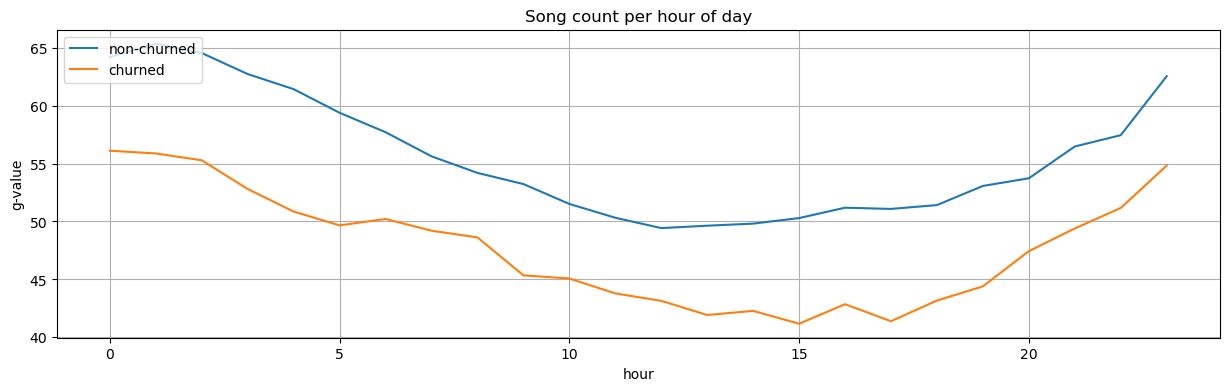

In [98]:
# Define f function
f_SongCountPerHourOfDay = data \
    .withColumn('hour', hour(col('tsDate'))) \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn', col('hour').alias('attribute')) \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SongCountPerHourOfDay = get_g(f_SongCountPerHourOfDay)

# Plot it
plot_timeline(g_SongCountPerHourOfDay, 'Song count per hour of day', 'hour')

In [99]:
# Delta over the whole observation period using a proper f function
f = f_SongCountPerHourOfDay \
    .groupby('userId', 'churn') \
    .agg(avg('f-value').alias('f-value'))

g = f.groupby('churn').agg(Fsum('f-value').alias('g-value'))

deltaset = calc_delta(g)
deltaset.show()

+-----+-----------------+------------------+-------------------+---------+
|churn|          g-value|             ratio|              delta|candidate|
+-----+-----------------+------------------+-------------------+---------+
|    1|11455.40372177665|0.1963258228152253|-0.6073483543695495|     true|
|    0| 46893.5366137902|0.8036741771847746|-0.6073483543695493|     true|
+-----+-----------------+------------------+-------------------+---------+



##### Total song length
Calculates the total length of all song events.

+-----+-------------+--------+---------+---------+
|churn|g-value      |ratio   |delta    |candidate|
+-----+-------------+--------+---------+---------+
|1    |240531.988248|0.456621|-0.086758|false    |
|0    |286233.239081|0.543379|-0.086758|false    |
+-----+-------------+--------+---------+---------+



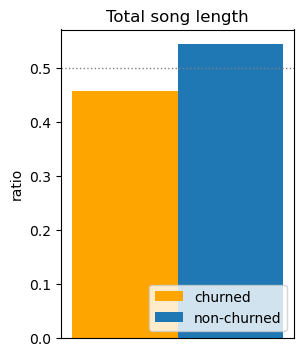

In [100]:
# Define f function
f_TotalSongLength = data \
    .where(data.page == 'NextSong') \
    .groupby('userId', 'churn') \
    .agg(Fsum('length').alias('f-value'))

# Get g function
g_TotalSongLength = get_g(f_TotalSongLength)

analyse(g_TotalSongLength, attr_dict=None, title='Total song length', loc=4, width=3, height=4);

##### Non-song count
Counts non-song page events.

+-----+----------+--------+---------+---------+
|churn|g-value   |ratio   |delta    |candidate|
+-----+----------+--------+---------+---------+
|1    |218.651685|0.464466|-0.071067|false    |
|0    |252.107181|0.535534|-0.071067|false    |
+-----+----------+--------+---------+---------+



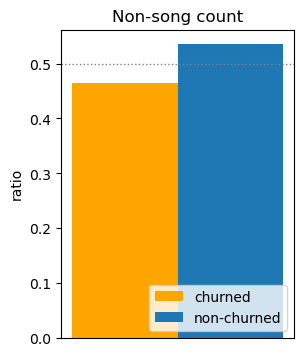

In [101]:
# Define f function
f_NonSongCount = data \
    .where(data.page != 'NextSong') \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_NonSongCount = get_g(f_NonSongCount)

analyse(g_NonSongCount, attr_dict=None, title='Non-song count', loc=4, width=3, height=4);

##### Unique song count
Counts unique songs.

+-----+-----------+--------+---------+---------+
|churn|g-value    |ratio   |delta    |candidate|
+-----+-----------+--------+---------+---------+
|1    |865.247191 |0.460638|-0.078725|false    |
|0    |1013.121115|0.539362|-0.078725|false    |
+-----+-----------+--------+---------+---------+



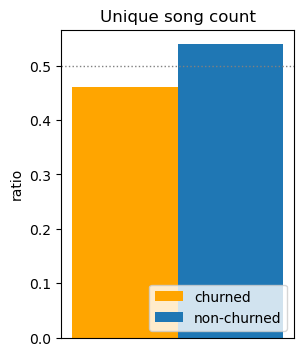

In [102]:
# Define f function
# Note: We use song column to identity the song.
f_UniqueSongCount = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'churn', 'song') \
    .dropDuplicates() \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_UniqueSongCount = get_g(f_UniqueSongCount)

analyse(g_UniqueSongCount, attr_dict=None, title='Unique song count', loc=4, width=3, height=4);

### Session level

##### Session count

+-----+---------+--------+---------+---------+
|churn|g-value  |ratio   |delta    |candidate|
+-----+---------+--------+---------+---------+
|1    |13.430712|0.457383|-0.085234|false    |
|0    |15.933548|0.542617|-0.085234|false    |
+-----+---------+--------+---------+---------+



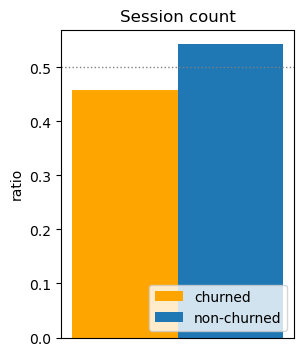

In [103]:
# Define f function
f_SessionCount = data \
    .select( 'userId', 'churn', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('f-value'))

# Get g function
g_SessionCount = get_g(f_SessionCount)

analyse(g_SessionCount, attr_dict=None, title='Session count', loc=4, width=3, height=4);

##### Session count per day

+-----+--------+--------+--------+---------+
|churn|g-value |ratio   |delta   |candidate|
+-----+--------+--------+--------+---------+
|1    |1.233099|0.523765|0.047529|false    |
|0    |1.121201|0.476235|0.047529|false    |
+-----+--------+--------+--------+---------+



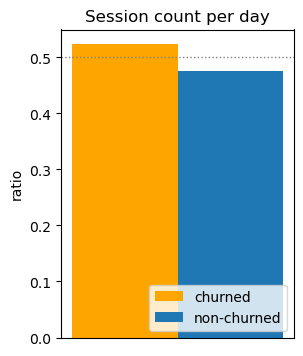

In [104]:
# Define f function
f_SessionCountPerDay = data \
    .select( 'userId', 'churn', 'sessionId', 'date') \
    .dropDuplicates() \
    .groupby('userId', 'churn', 'date') \
    .count() \
    .groupby('userId', 'churn') \
    .agg(avg('count').alias('f-value'))

# Get g function
g_SessionCountPerDay = get_g(f_SessionCountPerDay)

analyse(g_SessionCountPerDay, attr_dict=None, title='Session count per day', loc=4, width=3, height=4);

##### Average session duration

+-----+------------+--------+--------+---------+
|churn|g-value     |ratio   |delta   |candidate|
+-----+------------+--------+--------+---------+
|1    |19212.321476|0.519197|0.038393|false    |
|0    |17791.628398|0.480803|0.038393|false    |
+-----+------------+--------+--------+---------+



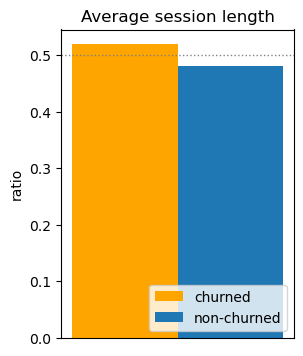

In [105]:
f_AvgSessionLength = data \
    .groupby('userId', 'churn', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('sessionLength')) \
    .groupby('userId', 'churn') \
    .agg(avg('sessionLength').alias('f-value'))

# Get g function
g_AvgSessionLength = get_g(f_AvgSessionLength)

analyse(g_AvgSessionLength, attr_dict=None, title='Average session length', loc=4, width=3, height=4);

##### Average session gap
A *session gap* is a gap of no user activity between the sessions.

We are using the following formula to calculate the average session gap per user:

> average session gap = $\frac{observationTime - sessionTime}{sessionCount - 1}$

The dividend is a **total session gap time** per user and the divisor is the **number of gaps** between the sessions per user which equals the total number of sessions decreased by 1 given that *n* sessions have *n $-$ 1* gaps.

+-----+--------------+--------+--------+---------+
|churn|g-value       |ratio   |delta   |candidate|
+-----+--------------+--------+--------+---------+
|1    |2368939.845674|0.353135|-0.29373|true     |
|0    |4339372.533899|0.646865|-0.29373|true     |
+-----+--------------+--------+--------+---------+



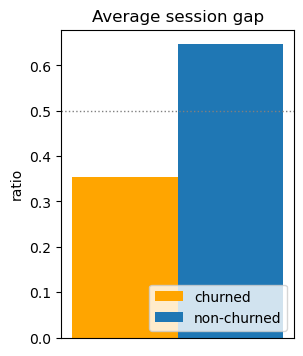

In [106]:
# Define f function
f_AvgSessionGap = data \
    .groupby('userId', 'churn', 'sessionId') \
    .agg(min('ts').alias('startTime'), max('ts').alias('endTime')) \
    .groupby('userId', 'churn') \
    .agg(count('userId').alias('sessionCount'), \
        ((max('endTime') - min('startTime'))/1000).alias('observationPeriodTime'), \
        (Fsum(col('endTime') - col('startTime'))/1000).alias('totalSessionTime')) \
    .where(col('sessionCount') > 1) \
    .select('userId', 'churn', \
            (col('observationPeriodTime') - col('totalSessionTime')/(col('sessionCount') - 1)).alias('f-value'))

# Get g function
g_AvgSessionGap = get_g(f_AvgSessionGap)

analyse(g_AvgSessionGap, attr_dict=None, title='Average session gap', loc=4, width=3, height=4);

### Page level

In [107]:
def filter_page(data, event):
    """Filter page logs by event.
    
    Args:
        data (DataFrame): The data set.
        event (str): The name of an event (or page attribute value).
    """
    return data.where(data.page == event)

*Remark on excluded events:*

We'll check the delta values for each page event except for the *Cancel*, *Cancellation Confirmation*, and *Submit Downgrade* events. The reason why we exclude the *Cancel* and *Cancellation Confirmation* event is that we use the latter to **define** our label - *it is a part of the label definition of cancelled users*, and since the *Cancel* event is its predecessor event we have to exclude it too. The *Submit Downgrade* event is used *to define the label of the downgraded users*. As we opt **not to mix the both churn types** - the *cancelled* and the *downgraded* users - we prefer not to use any feature that is part of the label definition of the other churn type. 



In [108]:
# Check if the predecessor of every Cancellation Confirmation event is the Cancel event 
# and if the predecessor of every Cancellation Confirmation event is the Cancel event.
print(f"Total of Cancel events: {filter_page(data, 'Cancel').count()}")
print(f"Total of Cancellation Confirmation events: {filter_page(data, 'Cancellation Confirmation').count()}")
cancelConfirmationLogs = data.where(data.page == 'Cancellation Confirmation').select(col('userRowId').alias('rowId'))
cancelWithConfirmationLogs = data.where(data.page == 'Cancel') \
    .join(cancelConfirmationLogs, cancelConfirmationLogs.rowId == data.userRowId + 1);
print(f'Total of Cancel -> Cancellation Confirmation events: {cancelWithConfirmationLogs.count()}')

Total of Cancel events: 267
Total of Cancellation Confirmation events: 267


Total of Cancel -> Cancellation Confirmation events: 289


In [109]:
# Exclude events that form part of the label definition (of both churn types)
page_data = data.where(~data.page.isin(['Cancel', 'Cancellation Confirmation', 'Submit Downgrade']))

##### page count

+-----+---------------+-----------+--------+---------+---------+
|churn|attribute      |g-value    |ratio   |delta    |candidate|
+-----+---------------+-----------+--------+---------+---------+
|1    |About          |3.357143   |0.48315 |-0.0337  |false    |
|0    |About          |3.591304   |0.51685 |-0.0337  |false    |
|1    |Add Friend     |17.84556   |0.448181|-0.103639|true     |
|0    |Add Friend     |21.972222  |0.551819|-0.103639|true     |
|1    |Add to Playlist|27.31203   |0.448766|-0.102469|true     |
|0    |Add to Playlist|33.548317  |0.551234|-0.102469|true     |
|1    |Downgrade      |11.678733  |0.467822|-0.064356|false    |
|0    |Downgrade      |13.285311  |0.532178|-0.064356|false    |
|1    |Error          |2.14094    |0.479506|-0.040987|false    |
|0    |Error          |2.323944   |0.520494|-0.040987|false    |
|1    |Help           |6.699153   |0.456578|-0.086844|false    |
|0    |Help           |7.973366   |0.543422|-0.086844|false    |
|1    |Home           |43

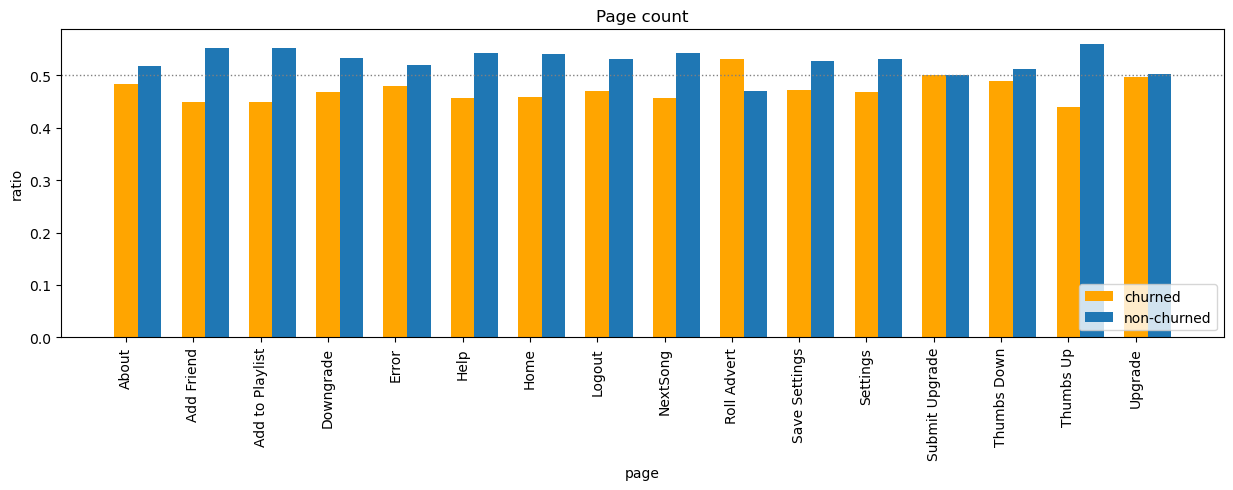

In [110]:
# Get f function by attribute and analyse it
f_PageCount = get_f_LogAttributeCount(page_data, 'page')

# Get g function
g = get_g(f_PageCount)

# Define attribute
attr_dict = get_attribute(page_data, 'page')

analyse(g, attr_dict=attr_dict, title='Page count', loc=4, width=15, height=4, rotation=90);

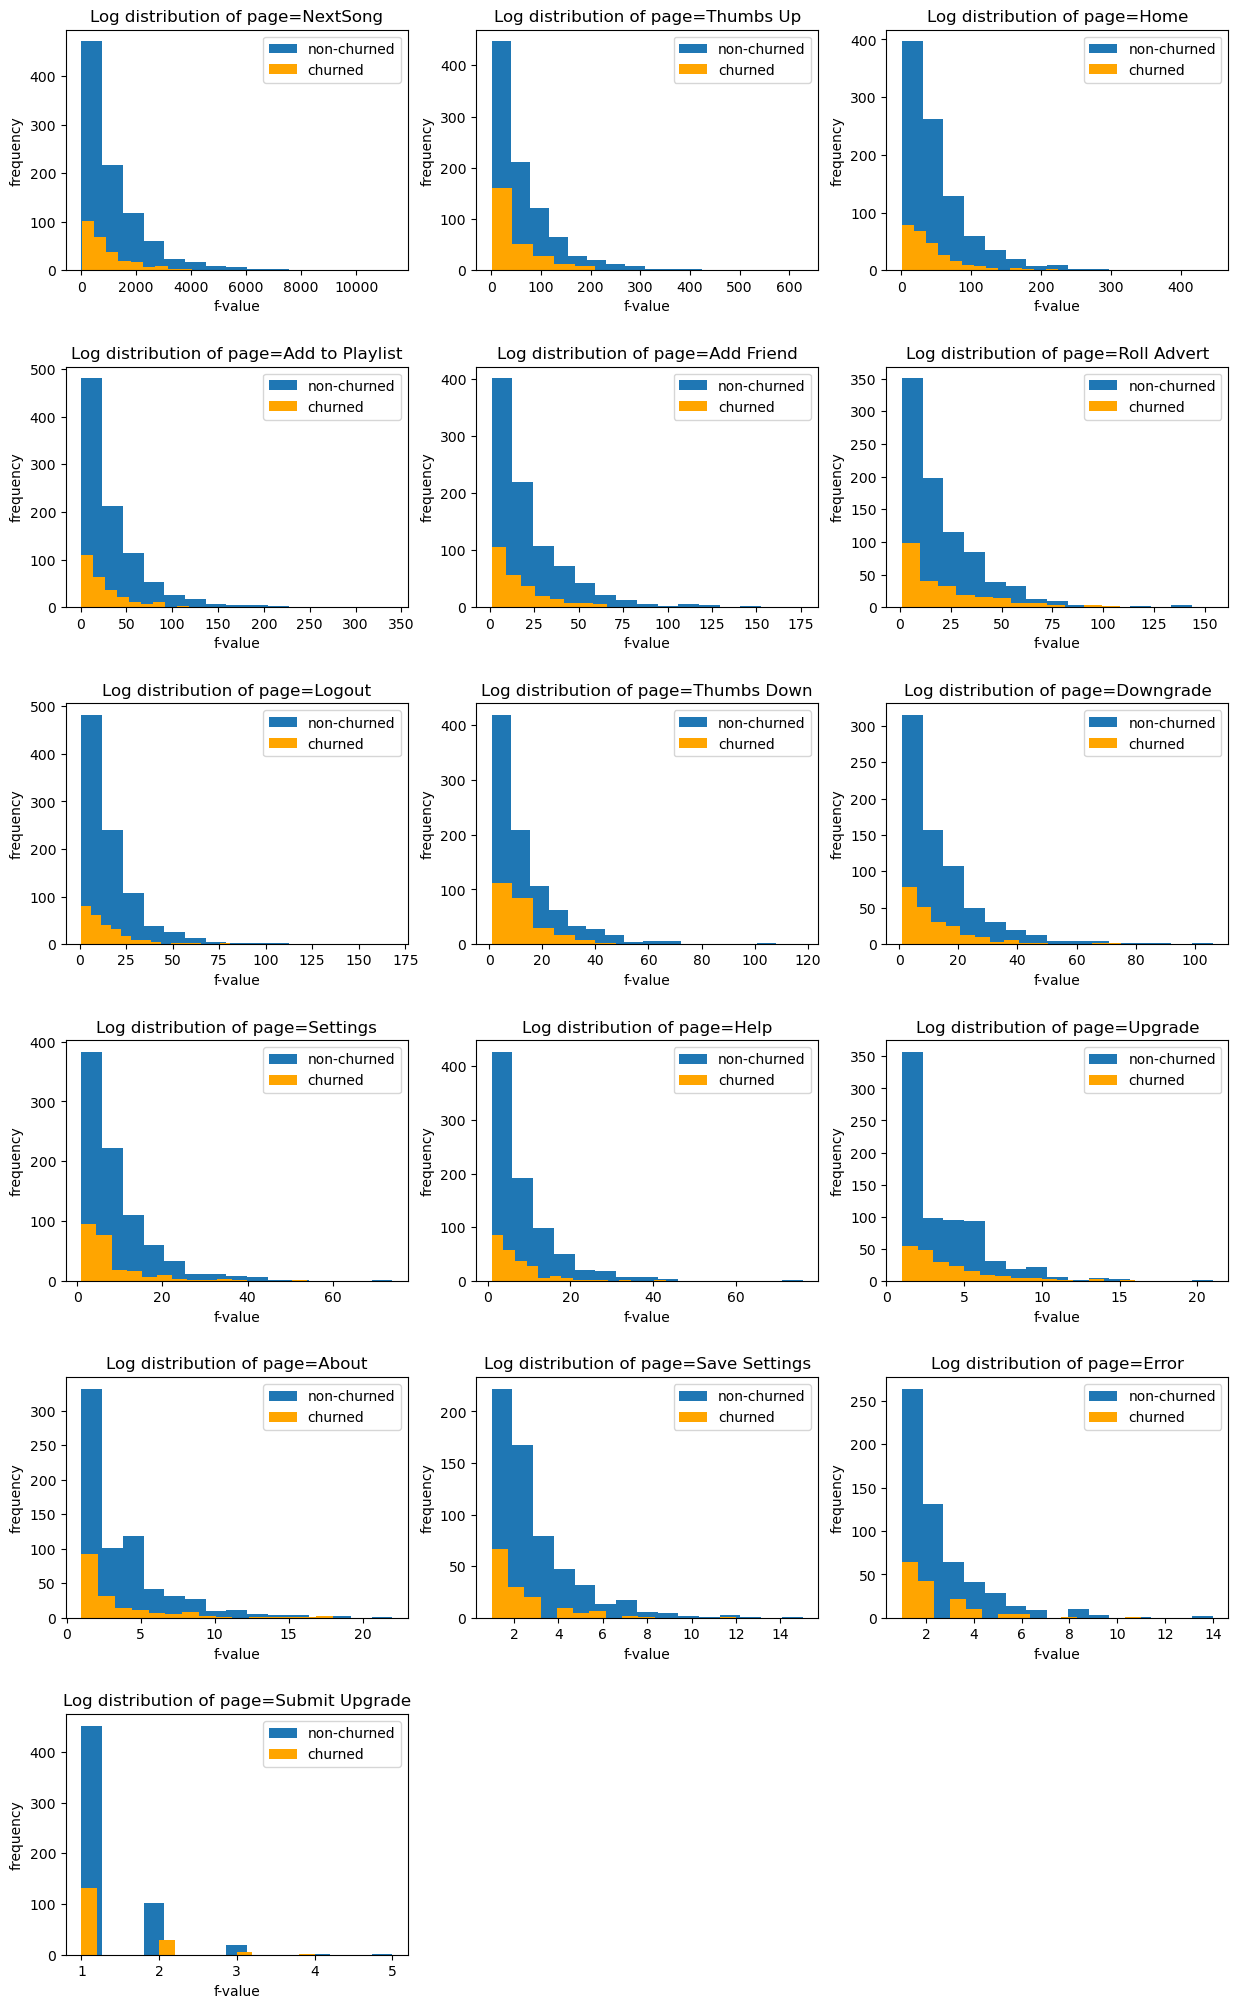

In [111]:
# Show distribution of f-values
plot_hist(f_PageCount, attr_dict, 'Distribution of page logs', bins=15, width=15, height=25)

##### page count per session hour
Counts page events per session hour.

+-----+---------------+---------+--------+---------+---------+
|churn|attribute      |g-value  |ratio   |delta    |candidate|
+-----+---------------+---------+--------+---------+---------+
|1    |About          |1.351238 |0.407288|-0.185424|true     |
|0    |About          |1.966409 |0.592712|-0.185424|true     |
|1    |Add Friend     |8.836059 |0.450758|-0.098485|false    |
|0    |Add Friend     |10.766621|0.549242|-0.098485|false    |
|1    |Add to Playlist|0.68279  |0.48497 |-0.03006 |false    |
|0    |Add to Playlist|0.725111 |0.51503 |-0.03006 |false    |
|1    |Downgrade      |0.654945 |0.598944|0.197888 |true     |
|0    |Downgrade      |0.438555 |0.401056|0.197888 |true     |
|1    |Error          |0.254636 |0.491311|-0.017378|false    |
|0    |Error          |0.263642 |0.508689|-0.017378|false    |
|1    |Help           |4.574832 |0.839486|0.678971 |true     |
|0    |Help           |0.874733 |0.160514|0.678971 |true     |
|1    |Home           |12.441126|0.476089|-0.047821|fal

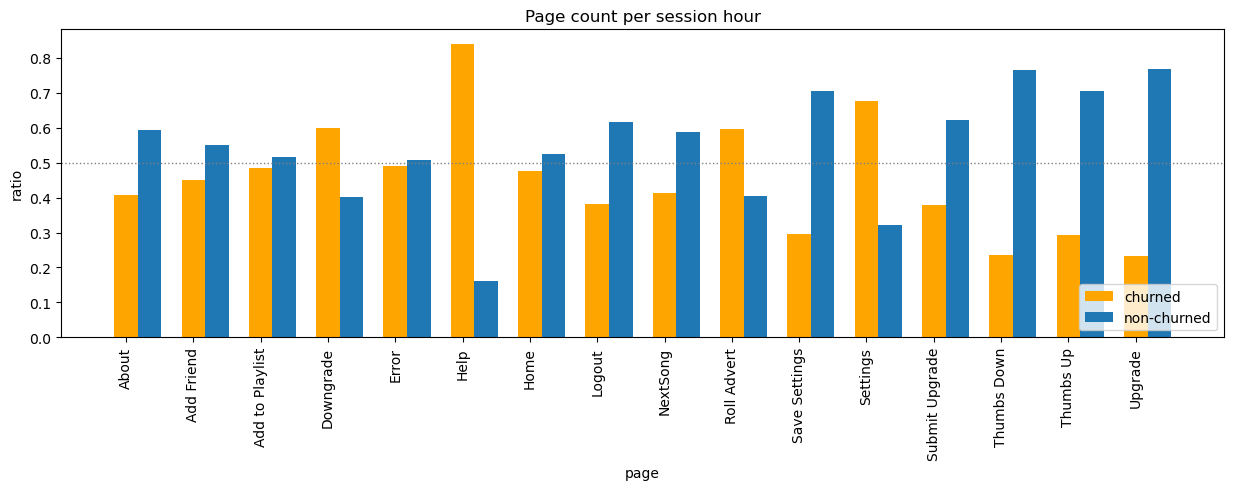

In [112]:
# Define session length (in hours)
sessionLength = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('sessionLength'))

# Define f function
f_PageCountPerSessionHour = page_data \
    .join(sessionLength, on=['userId', 'sessionId'], how='inner') \
    .groupby('userId', 'churn', 'page', 'sessionId', 'sessionLength') \
    .agg((count('userId')/col('sessionLength')).alias('pageCountPerHour')) \
    .groupby('userId', 'churn', 'page') \
    .agg(avg('pageCountPerHour').alias('f-value')) \
    .select('userId', 'churn', col('page').alias('attribute'), 'f-value')

# Get g function
g = get_g(f_PageCountPerSessionHour)

# Define attribute
attr_dict = get_attribute(page_data, 'page')

analyse(g, attr_dict=attr_dict, \
        title='Page count per session hour', loc=4, width=15, height=4, rotation=90);

##### page count per hour
Counts page events per hour (of all sessions).

+-----+---------------+---------+--------+---------+---------+
|churn|attribute      |g-value  |ratio   |delta    |candidate|
+-----+---------------+---------+--------+---------+---------+
|1    |About          |0.046535 |0.499545|-9.1E-4  |false    |
|0    |About          |0.04662  |0.500455|-9.1E-4  |false    |
|1    |Add Friend     |0.270277 |0.481636|-0.036728|false    |
|0    |Add Friend     |0.290888 |0.518364|-0.036728|false    |
|1    |Add to Playlist|0.406497 |0.493778|-0.012444|false    |
|0    |Add to Playlist|0.416741 |0.506222|-0.012444|false    |
|1    |Downgrade      |0.159229 |0.548461|0.096923 |false    |
|0    |Downgrade      |0.13109  |0.451539|0.096923 |false    |
|1    |Error          |0.032064 |0.512669|0.025337 |false    |
|0    |Error          |0.030479 |0.487331|0.025337 |false    |
|1    |Help           |0.103693 |0.50967 |0.01934  |false    |
|0    |Help           |0.099759 |0.49033 |0.01934  |false    |
|1    |Home           |0.707919 |0.496325|-0.00735 |fal

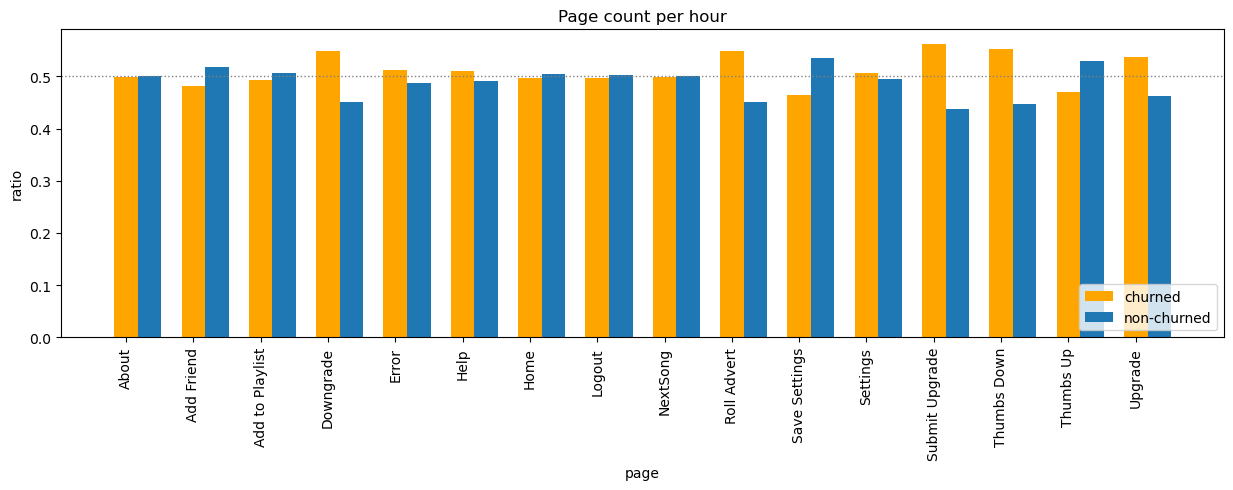

In [113]:
# Define total session length (in hours)
totalSessionLength = sessionLength \
    .groupby('userId') \
    .agg(Fsum('sessionLength').alias('totalSessionLength'))

# Define f function
f_PageCountPerHour = page_data \
    .join(totalSessionLength, 'userId', 'inner') \
    .groupby('userId', 'churn', 'page', 'totalSessionLength') \
    .agg((count('userId')/col('totalSessionLength')).alias('f-value')) \
    .select('userId', 'churn', col('page').alias('attribute'), 'f-value')

# Get g function
g = get_g(f_PageCountPerHour)

# Define attribute
attr_dict = get_attribute(page_data, 'page')

analyse(g, attr_dict=attr_dict, \
        title='Page count per hour', loc=4, width=15, height=4, rotation=90);

##### page count per day

+-----+---------------+---------+--------+---------+---------+
|churn|attribute      |g-value  |ratio   |delta    |candidate|
+-----+---------------+---------+--------+---------+---------+
|1    |About          |1.17766  |0.504298|0.008596 |false    |
|0    |About          |1.157586 |0.495702|0.008596 |false    |
|1    |Add Friend     |2.554626 |0.502538|0.005076 |false    |
|0    |Add Friend     |2.528825 |0.497462|0.005076 |false    |
|1    |Add to Playlist|2.930329 |0.513748|0.027496 |false    |
|0    |Add to Playlist|2.773497 |0.486252|0.027496 |false    |
|1    |Downgrade      |1.922508 |0.505713|0.011426 |false    |
|0    |Downgrade      |1.879072 |0.494287|0.011426 |false    |
|1    |Error          |1.069016 |0.495691|-0.008618|false    |
|0    |Error          |1.087601 |0.504309|-0.008618|false    |
|1    |Help           |1.430592 |0.504626|0.009253 |false    |
|0    |Help           |1.404361 |0.495374|0.009253 |false    |
|1    |Home           |3.626474 |0.520893|0.041786 |fal

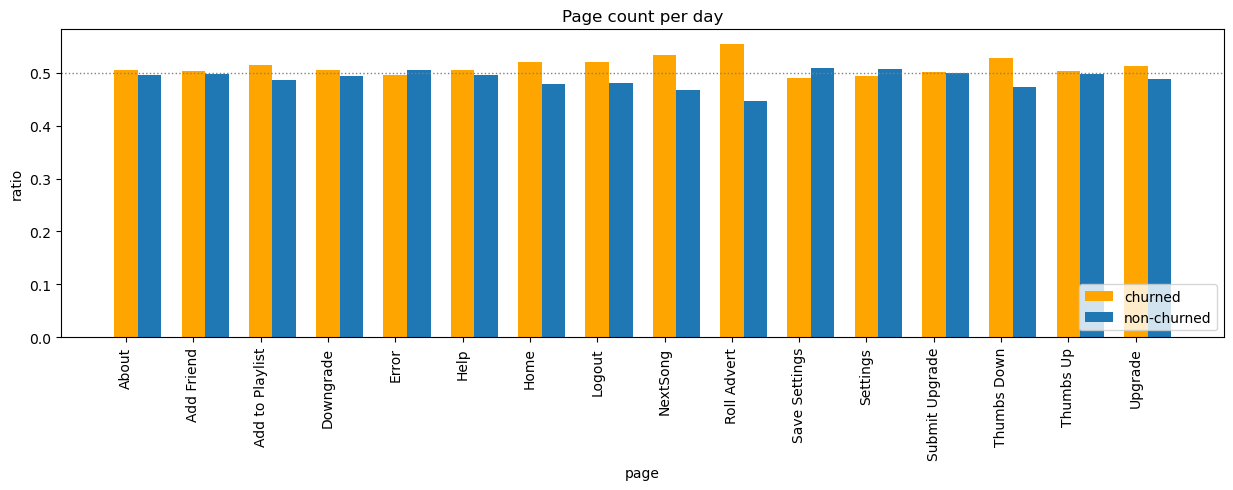

In [114]:
# Define f function
f_PageCountPerDay = page_data \
    .groupby('userId', 'churn', 'page', 'date') \
    .count() \
    .groupby('userId', 'churn', 'page') \
    .agg(avg('count').alias('f-value')) \
    .select('userId', 'churn', col('page').alias('attribute'), 'f-value')

# Get g function
g = get_g(f_PageCountPerDay)

# Define attribute
attr_dict = get_attribute(page_data, 'page')

analyse(g, attr_dict=attr_dict, \
        title='Page count per day', loc=4, width=15, height=4, rotation=90);

# Feature Engineering

#### Remark on feature selection

Some features that were marked as **candidate features** in the exploratory data analysis *do not appear in the final selection list* while some features that did not fulfill the delta threshold condition are listed here. The final decision about the feature selection was a combination of analytical insights, preliminary tests, and intuition.

### User attribute features

> - *Gender*
> - *Last level*

In [115]:
f_Gender = data \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int').alias('Gender'))

f_LastLevel = data \
    .select('userId', 'lastLevel') \
    .dropDuplicates() \
    .replace(['free', 'paid'], ['0', '1'], 'lastLevel') \
    .select('userId', col('lastLevel').cast('int').alias('LastLevel'))

### Log features 

> - *Log count*

In [116]:
# Log count
f_LogCount = data \
    .groupby('userId') \
    .agg(count('userId').alias('LogCount'))

##### Page count: 
> - *About*
> - *Thumbs Up*
> - *Roll Advert*
> - *Add Friend*
> - *Add to Playlist*
> - *Downgrade*
> - *Error*
> - *Home*

In [117]:
def pageCount(page):
    """Returns the log count query filtered by a specified page."""
    return data \
        .where(data.page == page) \
        .groupby('userId') \
        .agg(count('userId').alias('count')) \
        .select('userId', col('count').alias(page.replace(' ', '') + 'Count'))

f_AboutCount = pageCount('About')
f_ThumbsUpCount = pageCount('Thumbs Up')
f_RollAdvertCount = pageCount('Roll Advert')
f_AddFriendCount = pageCount('Add Friend')
f_AddToPlaylistCount = pageCount('Add to Playlist')
f_DowngradeCount = pageCount('Downgrade')
f_ErrorCount = pageCount('Error')
f_HomeCount = pageCount('Home')

##### Page count per hour:
> - *Roll Advert*
> - *Thumbs Down*
> - *Upgrade*
> - *Submit Upgrade*

In [118]:
# Average page count per hour
periodHours = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('periodHours')) \
    .groupby('userId') \
    .agg(Fsum('periodHours').alias('periodHours'))

def pageCountPerHour(page):
    """Returns log count per total observation period hour filtered by a specified page."""
    return data \
        .where(data.page == page) \
        .join(periodHours, 'userId', 'inner') \
        .groupby('userId', 'periodHours') \
        .agg((count('userId')/col('periodHours')).alias('avgPerHour')) \
        .select('userId', col('avgPerHour').alias(page.replace(' ', '') + 'PerHour'))

f_RollAdvertPerHour = pageCountPerHour('Roll Advert')
f_ThumbsDownPerHour = pageCountPerHour('Thumbs Down')
f_UpgradePerHour = pageCountPerHour('Upgrade')
f_SubmitUpgradePerHour = pageCountPerHour('Submit Upgrade')
f_LogoutPerHour = pageCountPerHour('Logout')

##### Page count per session hour:
> - *Error*
> - *Settings*
> - *Save Settings*
> - *Logout*
> - *Downgrade*

In [119]:
# Average page count per session hour
sessionHours = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('sessionHours'))

def pageCountPerSessionHour(page):
    """Returns the log count per session hour filtered by a specified page."""
    return data \
        .where(data.page == page) \
        .join(sessionHours, ['userId', 'sessionId'], 'inner') \
        .groupby( 'userId', 'sessionId', 'sessionHours') \
        .agg((count('userId')/col('sessionHours')).alias('avgPerSessionHour')) \
        .groupby('userId') \
        .agg(avg('avgPerSessionHour').alias('avgPerSessionHour')) \
        .select('userId', col('avgPerSessionHour').alias(page.replace(' ', '') + 'PerSessionHour'))

f_ErrorPerSessionHour = pageCountPerSessionHour('Error')
f_SettingsPerSessionHour = pageCountPerSessionHour('Settings')
f_SaveSettingsPerSessionHour = pageCountPerSessionHour('Save Settings')
f_LogoutPerSessionHour = pageCountPerSessionHour('Logout')
f_DowngradePerSessionHour = pageCountPerSessionHour('Downgrade')

# We include Submit Downgrade event used in one exercise
# In such an extended project it is difficult to be perfectly consistent!
f_SubmitDowngradePerSessionHour = pageCountPerSessionHour('Submit Downgrade')

##### Page count per day:
> - *Add Friend*
> - *Roll Advert*
> - *Thumbs Down*
> - *Thumbs Up*

In [120]:
def pagePerDay(page):
    return data \
        .where(data.page == page) \
        .groupby('userId', 'date') \
        .count() \
        .groupby('userId') \
        .agg(avg('count').alias(page.replace(' ', '') + 'PerDay'))

f_AddFriendPerDay = pagePerDay('Add Friend')
f_RollAdvertPerDay = pagePerDay('Roll Advert')
f_ThumbsDownPerDay = pagePerDay('Thumbs Down')
f_ThumbsUpPerDay = pagePerDay('Thumbs Up')

##### Method count:
> - *PUT*

In [121]:
# Method PUT count
f_MethodPutCount = data \
    .where(data.method == 'PUT') \
    .groupby('userId') \
    .agg(count('userId').alias('MethodPutCount'))

##### Status count:
> - *200*
> - *307*
> - *404*

In [122]:
def statusCount(status):
    """Returns log count query filtered by a specified status."""
    return data \
        .where(data.status == status) \
        .groupby('userId') \
        .agg(count('userId').alias('Status' + str(status) + 'Count'))

f_Status200Count = statusCount(200)
f_Status307Count = statusCount(307)
f_Status404Count = statusCount(404)

### Session features
> - *Session count*
> - *Session count per day*
> - *Average session length*
> - *Average session gap*

In [123]:
# Total session count
f_SessionCount = data \
    .select('userId', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId') \
    .agg(count('userId').alias('SessionCount'))

# Average session count per day
f_SessionsPerDay = data \
    .select('userId', 'date', 'sessionId') \
    .dropDuplicates() \
    .groupby('userId', 'date') \
    .count() \
    .groupby('userId') \
    .agg(avg('count').alias('SessionsPerDay'))

# Average session length
f_AvgSessionLength = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000).alias('sessionLength')) \
    .groupby('userId') \
    .agg(avg('sessionLength').alias('AvgSessionLength'))

# Average session gap
f_AvgSessionGap = data \
    .groupby('userId', 'sessionId') \
    .agg(min('ts').alias('startTime'), max('ts').alias('endTime')) \
    .groupby('userId') \
    .agg(count('userId').alias('sessionCount'), \
        ((max('endTime') - min('startTime'))/1000).alias('observationPeriodTime'), \
        (Fsum(col('endTime') - col('startTime'))/1000).alias('totalSessionTime')) \
    .where(col('sessionCount') > 1) \
    .join(data.select('userId').dropDuplicates(), 'userId', 'outer') \
    .fillna(0) \
    .select('userId', \
            (col('observationPeriodTime') - col('totalSessionTime')/(col('sessionCount') - 1)).alias('AvgSessionGap'))

### Song features
> - *Song count*
> - *Non-song count*
> - *Total song length*
> - *Unique song count*
> - *Unique song share*

In [124]:
# Song event count
f_SongCount = data \
    .where(data.page == 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('SongCount'))

# Song count per day
f_SongCountPerDay = data \
    .where(data.page == 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('SongCount'))

# Non-song event count
f_NonSongCount = data \
    .where(data.page != 'NextSong') \
    .groupby('userId') \
    .agg(count('userId').alias('NonSongCount'))

# All song total length  
f_TotalSongLength = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'length') \
    .groupby('userId') \
    .agg(Fsum('length').alias('TotalSongLength'))

# Unique song event count
f_UniqueSongCount = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .agg(count('userId').alias('UniqueSongCount'))

# Share of unique song events among all song events
totals = data \
    .where(data.page == 'NextSong') \
    .select('userId') \
    .groupby('userId') \
    .agg(count('userId').alias('total'))

f_UniqueSongShare = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'song') \
    .dropDuplicates() \
    .groupby('userId') \
    .count() \
    .join(totals, on = ['userId'], how = 'inner') \
    .select('userId', (col('count')/col('total')).alias('UniqueSongShare')) 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine the winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, we chose F1 score as the metric to optimize.

The *modeling part* of the project has been performed during an extended period of time (over several weeks). On several occasions the following machine learning excercises took place:

 - **Preliminary exercises**: Mini-dataset with default hyperparameters, single seed, various feature collections. The preliminary exercises gave us some rough estimation about the feature selection we made in order to confirm it or to discard, replace, and add some new features that did not comply with the [general statistical method](#section-general-statistical-method).  
 - **Default exercises**: Mini-dataset with default hyperparameters, single seed, various feature collections. (Please check  [Sparkify-modelling.ipynb](Sparkify-modelling.ipynb) notebook for more details.)
 - **Cross-validation exercises**: Mini-dataset, single seed, hyperparameters tuning with *cross-validation*, single feature collection chosen from the best model of the default excercise. (Please check [Sparkify-modelling.ipynb](Sparkify-modelling.ipynb) notebook for more details.)
 - **Seed exercises**: Mini-dataset, several seeds (0, 5, 47, 99), best hyperparameters from the cross-validation excercise. (Please check  [Sparkify-modelling.ipynb](Sparkify-modelling.ipynb) notebook for more details.)
 - **Exercises on EMR cluster** (Amazon): Big dataset, single seed, single set of hyperparameters (no cross-validation), various feature collections:
    + [Sparkify-cluster-cancelled-feature-engineering.ipynb](Sparkify-cluster-cancelled-feature-engineering.ipynb) notebook on feature engineering for cancelled users.
    + [Sparkify-cluster-downgraded-feature-engineering.ipynb](Sparkify-cluster-downgraded-feature-engineering.ipynb) notebook on feature engineering for downgraded users.
    + [Sparkify-cluster-cancelled-bestmodel.py](Sparkify-cluster-cancelled-bestmodel.py) script that was used to fit the best model for the cancelled users.    
    + [Sparkify-cluster-downgraded-bestmodel.py](Sparkify-cluster-downgraded-bestmodel.py) script that was used to fit the best model for the downgraded users.    
 - **Final exercise**: Mini-dataset, single seed, single machine learning method (GBTClassifier), hyperparameters tuning with cross-validation. Executed at the final phase of polishing this notebook (check it [here](#section-gbtclassifier)).

In [125]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, \
    NaiveBayes, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import time

In [126]:
# Get labels query
data_labels = data.select(col('churn').alias('label'), 'userId').dropDuplicates()

In [127]:
def get_features(data):
    """Extract features from model data.
    
    Args:
        data (DataFrame): The model data with features and labels.
        
    Returns:
        list: A list of feature columns.
    """
    return data.drop('label').columns

def split_data(data, seed=0):
    """Splits data into training and testing/validation subset.
    We use fix split ratio 80 : 20.
    
    Args:
        data (DataFrame): The model data with features.
        seed (int): A seed value of the random number generator.
        
    Returns:
        train (DataFrame): The training subset.
        test (DataFrame): The testing subset.
    """
    train, test = data.randomSplit([0.8, 0.2], seed=seed);
    return train, test

def create_pipeline(data, classifier, scaler):
    """Creates pipeline object with given features, scaler, and classifier.
    
    Args:
        data (DataFrame): The model data with features.
        classifier: A machine learning classifier object.

    Returns:
        pipeline (Pipeline): The pipeline object.
    """
    features = get_features(data)
    assembler = VectorAssembler(inputCols=features, outputCol='NumFeatures')
    pipeline = Pipeline(stages=[assembler, scaler, classifier]);

    return pipeline

In [128]:
def fit_model(data, classifier, seed=0):
    """Fits model and calculates metrics.
    
    Note that we use the StandardScaler only. We haven't noticed any improvements using 
    MinMaxScaler and Normalizer.
    
    Args:
        data (DataFrame): The model data with features.
        classifier: A machine learning classifier object. 
        seed (int): A seed value of the random number generator.
        
    Returns:
        model: The fitted model.
        metrics: The fitted model's metrics.
    """
    start_time = time.time()
    
    print('Model fitting started. Please wait...')

    # Split data into train and test subset
    train, test = split_data(data, seed)
    print('Train|Test data split done.')

    # Create pipeline
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
    pipeline = create_pipeline(data, classifier, scaler)
    print('Create pipeline done.')

    # Train model
    model = pipeline.fit(train)
    print('Training done.')

    # Get metrics
    metrics = calc_metrics(model, test)
    print('Metrics prepared.')

    fitting_duration = time.time() - start_time
    
    print(f'Model fitting done ({int(fitting_duration)} s).')
    
    return model, metrics


In [129]:
def calc_metrics(model, test):
    """Calculates the metrics of the specified model.
    
    You will notice that this function, apart from F1-score, returns also accuracy, 
    weighted precision, weighted recall, and AUC metric. We include all of them because
    more information, better. Nevertheless, we keep focus on F1 as our principal metric.
    
    Args:
        model: The fitted model.
        test: The testing/validation subset.
        
    Returns:
        metrics: The fitted model's metrics.
    """
    # Create both evaluators
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')

    # Make predicitons
    prediction = model.transform(test).select('label', 'prediction')

    # Get metrics
    acc = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'accuracy'})
    f1 = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'f1'})
    weightedPrecision = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedPrecision'})
    weightedRecall = evaluatorMulti.evaluate(prediction, {evaluatorMulti.metricName: 'weightedRecall'})
    auc = evaluator.evaluate(prediction)
    
    metrics = pd.DataFrame(index=['F1', 'accuracy', 'weighted precision', 'weighted recall', 'AUC'], \
                           data={'metrics value': [f1, acc, weightedPrecision, weightedRecall, auc]})
    
    return metrics

In [130]:
# Plot feature importances
def plot_feature_importance(data, model, height, title):
    """Plots feature importances.
    
    Args:
        data (DataFrame): The model data.
        model: The fitted model.
        height (int): The plot's figure height.
        title (str): The plot's title.
    
    Returns:
        None
    """
    features = get_features(data)
    feature_coeff = model.stages[-1].featureImportances
    feature_importances = pd.DataFrame(list(zip(features, feature_coeff)), \
                                       columns=['Feature', 'FeatureImportances']) \
        .sort_values('FeatureImportances', ascending=False)

    values = feature_importances.sort_values(by='FeatureImportances', ascending=False)['FeatureImportances']
    labels = feature_importances.sort_values(by='FeatureImportances', ascending=False)['Feature']

    plt.figure(figsize = [8, height])
    plt.barh(np.arange(len(values)), values, height=0.6)
    ax = plt.gca()
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('FeatureImportances')
    ax.set_ylabel('Features')
    ax.set_title(title)
    plt.grid(True, axis='x', linewidth= 1, linestyle="--")

    plt.show()

In [131]:
def fit_model_cv(data, classifier, paramGrid, numFolds=2):
    """Fits the cross-validation model for hyperparameters tuning.
    
    Args:
        data (DataFrame): The model data.
        classifier: A machine learning classifier object. 
        paramGrid: A ParamGridBuilder object with hyperparameters.
        numFolds: The number of folds in the cross-validation tuning.
    
    Returns:
        model_cv: The cross-validation model.
        scores_cv: The cross-validation scores.
    """
    
    start_time = time.time()
    
    print('Cross validation started. Please wait...')
    
    # Split data into train and test subset
    train, test = split_data(data)
    print('Train|Test data split done.')
    
    # Create pipeline
    scaler = StandardScaler(inputCol='NumFeatures', outputCol='features')
    pipeline = create_pipeline(data, classifier, scaler)
    print('Create pipeline done.')
    
    # Create cross validator
    crossValidator = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = numFolds)

    # Fit cross validator
    model_cv = crossValidator.fit(train)
    
    duration = time.time() - start_time   
    print(f'Cross validation done ({int(duration)} s).')

    # Get CV scores
    scores_cv = get_cv_scores(model_cv)
    
    return model_cv, scores_cv

def get_cv_scores(model_cv):
    """Extracts the scores from the cross-validation model's metrics.
    
    Args:
        model_cv: The cross-validation model.
        
    Returns:
        params_df (pandas DataFrame): The dataframe with scores.
    """
    scores = model_cv.avgMetrics
    params = [{p.name: v for p, v in m.items()} for m in model_cv.getEstimatorParamMaps()]
    params_df = pd.DataFrame(params)
    params_df['score'] = scores
    
    return params_df.sort_values(by='score', ascending=False)


### GBTClassifier

In [144]:
# Model's data (28 features)
data_gbt_28 = data_labels.join(f_Gender, 'userId', 'outer') \
    .join(f_LastLevel, 'userId', 'outer') \
    .join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ErrorPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

#### Model #01
> - *28 features*
> - *seed 0*
> - *GBTClassifier*
> - *default hyperparameters*

In [317]:
# Fit model
classifier = GBTClassifier()
model_gbt, metrics_gbt = fit_model(data_gbt_28, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


Training done.


Metrics prepared.
Model fitting done (211 s).


In [318]:
# Show metrics
metrics_gbt

,metrics value
F1,0.835039
accuracy,0.837121
weighted precision,0.833671
weighted recall,0.837121
AUC,0.775060


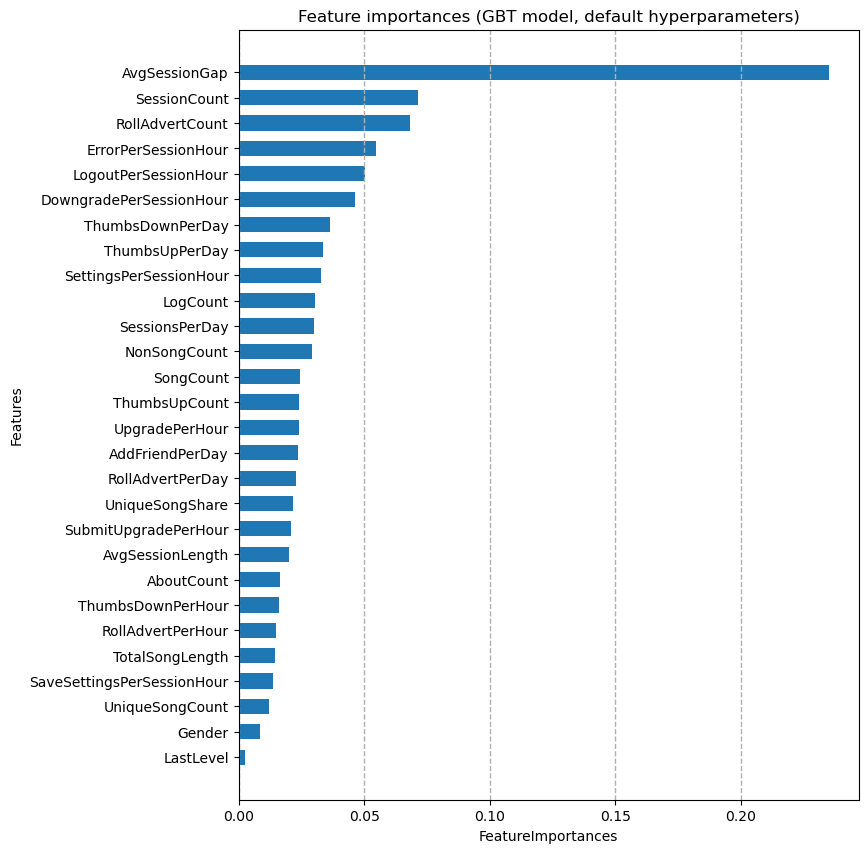

In [319]:
# Plot feature importances
plot_feature_importance(data_gbt_28, model_gbt, 10, 'Feature importances (GBT model, default hyperparameters)')

#### Cross-validation

In [320]:
# Create classifier
classifier = GBTClassifier()

# Define ParamGrid builder
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(classifier.maxIter, [10, 20, 50, 200]) \
    .addGrid(classifier.maxDepth,[2, 5]) \
    .addGrid(classifier.maxBins, [32]) \
    .build()

# Fit cross-validation model
model_cv, scores_cv = fit_model_cv(data_gbt_28, classifier, paramGrid_gbt)

# Show scores
scores_cv

Cross validation started. Please wait...
Train|Test data split done.
Create pipeline done.


23/05/04 00:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB


23/05/04 00:21:28 WARN DAGScheduler: Broadcasting large task binary with size 1002.2 KiB


23/05/04 00:21:29 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB


23/05/04 00:21:29 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB


23/05/04 00:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB


23/05/04 00:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB


23/05/04 00:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB


23/05/04 00:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1011.7 KiB


23/05/04 00:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB


23/05/04 00:21:34 WARN DAGScheduler: Broadcasting large task binary with size 1012.7 KiB


23/05/04 00:21:35 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB


23/05/04 00:21:36 WARN DAGScheduler: Broadcasting large task binary with size 1016.1 KiB


23/05/04 00:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1018.0 KiB


23/05/04 00:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1018.5 KiB
23/05/04 00:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1019.0 KiB


23/05/04 00:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1020.2 KiB


23/05/04 00:21:40 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB


23/05/04 00:21:40 WARN DAGScheduler: Broadcasting large task binary with size 1024.2 KiB


23/05/04 00:21:41 WARN DAGScheduler: Broadcasting large task binary with size 1024.6 KiB


23/05/04 00:21:42 WARN DAGScheduler: Broadcasting large task binary with size 1025.2 KiB


23/05/04 00:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB


23/05/04 00:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1028.6 KiB


23/05/04 00:21:44 WARN DAGScheduler: Broadcasting large task binary with size 1031.1 KiB


23/05/04 00:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1031.6 KiB


23/05/04 00:21:46 WARN DAGScheduler: Broadcasting large task binary with size 1032.2 KiB


23/05/04 00:21:47 WARN DAGScheduler: Broadcasting large task binary with size 1033.3 KiB


23/05/04 00:21:48 WARN DAGScheduler: Broadcasting large task binary with size 1035.3 KiB


23/05/04 00:21:48 WARN DAGScheduler: Broadcasting large task binary with size 1037.4 KiB


23/05/04 00:21:49 WARN DAGScheduler: Broadcasting large task binary with size 1037.9 KiB


23/05/04 00:21:50 WARN DAGScheduler: Broadcasting large task binary with size 1038.5 KiB


23/05/04 00:21:51 WARN DAGScheduler: Broadcasting large task binary with size 1039.6 KiB


23/05/04 00:21:52 WARN DAGScheduler: Broadcasting large task binary with size 1041.8 KiB


23/05/04 00:21:53 WARN DAGScheduler: Broadcasting large task binary with size 1043.9 KiB


23/05/04 00:21:53 WARN DAGScheduler: Broadcasting large task binary with size 1044.4 KiB


23/05/04 00:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1045.0 KiB


23/05/04 00:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1046.1 KiB


23/05/04 00:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1048.1 KiB


23/05/04 00:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1050.3 KiB


23/05/04 00:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1050.7 KiB


23/05/04 00:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1051.3 KiB


23/05/04 00:21:59 WARN DAGScheduler: Broadcasting large task binary with size 1052.4 KiB


23/05/04 00:22:00 WARN DAGScheduler: Broadcasting large task binary with size 1054.7 KiB


23/05/04 00:22:01 WARN DAGScheduler: Broadcasting large task binary with size 1056.9 KiB


23/05/04 00:22:01 WARN DAGScheduler: Broadcasting large task binary with size 1057.4 KiB


23/05/04 00:22:02 WARN DAGScheduler: Broadcasting large task binary with size 1057.9 KiB


23/05/04 00:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1059.1 KiB


23/05/04 00:22:04 WARN DAGScheduler: Broadcasting large task binary with size 1061.3 KiB


23/05/04 00:22:05 WARN DAGScheduler: Broadcasting large task binary with size 1063.7 KiB


23/05/04 00:22:05 WARN DAGScheduler: Broadcasting large task binary with size 1064.2 KiB


23/05/04 00:22:06 WARN DAGScheduler: Broadcasting large task binary with size 1064.7 KiB


23/05/04 00:22:07 WARN DAGScheduler: Broadcasting large task binary with size 1065.9 KiB


23/05/04 00:22:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.1 KiB


23/05/04 00:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1070.5 KiB


23/05/04 00:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.0 KiB


23/05/04 00:22:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB


23/05/04 00:22:11 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB


23/05/04 00:22:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.7 KiB


23/05/04 00:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1077.0 KiB


23/05/04 00:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB


23/05/04 00:22:14 WARN DAGScheduler: Broadcasting large task binary with size 1078.0 KiB


23/05/04 00:22:15 WARN DAGScheduler: Broadcasting large task binary with size 1079.2 KiB


23/05/04 00:22:16 WARN DAGScheduler: Broadcasting large task binary with size 1081.1 KiB


23/05/04 00:22:17 WARN DAGScheduler: Broadcasting large task binary with size 1083.5 KiB


23/05/04 00:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1084.0 KiB


23/05/04 00:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1084.5 KiB


23/05/04 00:22:19 WARN DAGScheduler: Broadcasting large task binary with size 1085.7 KiB


23/05/04 00:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB


23/05/04 00:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1089.8 KiB


23/05/04 00:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1090.3 KiB


23/05/04 00:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1090.8 KiB


23/05/04 00:22:23 WARN DAGScheduler: Broadcasting large task binary with size 1092.0 KiB


23/05/04 00:22:24 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB


23/05/04 00:22:25 WARN DAGScheduler: Broadcasting large task binary with size 1096.6 KiB


23/05/04 00:22:26 WARN DAGScheduler: Broadcasting large task binary with size 1097.1 KiB


23/05/04 00:22:27 WARN DAGScheduler: Broadcasting large task binary with size 1097.6 KiB


23/05/04 00:22:27 WARN DAGScheduler: Broadcasting large task binary with size 1098.8 KiB


23/05/04 00:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1101.0 KiB


23/05/04 00:22:29 WARN DAGScheduler: Broadcasting large task binary with size 1103.2 KiB


23/05/04 00:22:30 WARN DAGScheduler: Broadcasting large task binary with size 1103.7 KiB


23/05/04 00:22:31 WARN DAGScheduler: Broadcasting large task binary with size 1104.3 KiB


23/05/04 00:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1105.4 KiB


23/05/04 00:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1107.7 KiB


23/05/04 00:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1110.1 KiB


23/05/04 00:22:34 WARN DAGScheduler: Broadcasting large task binary with size 1110.5 KiB


23/05/04 00:22:35 WARN DAGScheduler: Broadcasting large task binary with size 1111.1 KiB


23/05/04 00:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.2 KiB


23/05/04 00:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB


23/05/04 00:22:37 WARN DAGScheduler: Broadcasting large task binary with size 1116.7 KiB


23/05/04 00:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1117.2 KiB


23/05/04 00:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1117.7 KiB


23/05/04 00:22:40 WARN DAGScheduler: Broadcasting large task binary with size 1118.9 KiB


23/05/04 00:22:41 WARN DAGScheduler: Broadcasting large task binary with size 1121.1 KiB


23/05/04 00:22:42 WARN DAGScheduler: Broadcasting large task binary with size 1123.5 KiB


23/05/04 00:22:42 WARN DAGScheduler: Broadcasting large task binary with size 1124.0 KiB


23/05/04 00:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB


23/05/04 00:22:44 WARN DAGScheduler: Broadcasting large task binary with size 1125.7 KiB


23/05/04 00:22:45 WARN DAGScheduler: Broadcasting large task binary with size 1127.9 KiB


23/05/04 00:22:46 WARN DAGScheduler: Broadcasting large task binary with size 1130.5 KiB


23/05/04 00:22:47 WARN DAGScheduler: Broadcasting large task binary with size 1131.0 KiB


23/05/04 00:22:47 WARN DAGScheduler: Broadcasting large task binary with size 1131.5 KiB


23/05/04 00:22:48 WARN DAGScheduler: Broadcasting large task binary with size 1132.7 KiB


23/05/04 00:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1134.9 KiB


23/05/04 00:22:50 WARN DAGScheduler: Broadcasting large task binary with size 1137.1 KiB


23/05/04 00:22:51 WARN DAGScheduler: Broadcasting large task binary with size 1137.6 KiB


23/05/04 00:22:51 WARN DAGScheduler: Broadcasting large task binary with size 1138.2 KiB


23/05/04 00:22:52 WARN DAGScheduler: Broadcasting large task binary with size 1139.3 KiB


23/05/04 00:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1141.5 KiB


23/05/04 00:22:54 WARN DAGScheduler: Broadcasting large task binary with size 1143.9 KiB


23/05/04 00:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1144.4 KiB


23/05/04 00:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1145.0 KiB


23/05/04 00:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1146.1 KiB


23/05/04 00:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1148.4 KiB


23/05/04 00:22:58 WARN DAGScheduler: Broadcasting large task binary with size 1150.9 KiB


23/05/04 00:22:59 WARN DAGScheduler: Broadcasting large task binary with size 1151.4 KiB


23/05/04 00:23:00 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB


23/05/04 00:23:01 WARN DAGScheduler: Broadcasting large task binary with size 1153.1 KiB


23/05/04 00:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1155.3 KiB


23/05/04 00:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1152.8 KiB


23/05/04 00:24:44 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB


23/05/04 00:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB


23/05/04 00:24:46 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB


23/05/04 00:24:46 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB


23/05/04 00:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB


23/05/04 00:24:48 WARN DAGScheduler: Broadcasting large task binary with size 1005.8 KiB


23/05/04 00:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1007.9 KiB


23/05/04 00:24:50 WARN DAGScheduler: Broadcasting large task binary with size 1008.3 KiB


23/05/04 00:24:50 WARN DAGScheduler: Broadcasting large task binary with size 1010.5 KiB


23/05/04 00:24:51 WARN DAGScheduler: Broadcasting large task binary with size 1010.9 KiB


23/05/04 00:24:52 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB


23/05/04 00:24:53 WARN DAGScheduler: Broadcasting large task binary with size 1013.5 KiB


23/05/04 00:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1015.6 KiB


23/05/04 00:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1016.1 KiB


23/05/04 00:24:55 WARN DAGScheduler: Broadcasting large task binary with size 1018.2 KiB


23/05/04 00:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1018.7 KiB


23/05/04 00:24:57 WARN DAGScheduler: Broadcasting large task binary with size 1020.8 KiB


23/05/04 00:24:58 WARN DAGScheduler: Broadcasting large task binary with size 1021.3 KiB


23/05/04 00:24:58 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB


23/05/04 00:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1023.9 KiB


23/05/04 00:25:00 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB


23/05/04 00:25:01 WARN DAGScheduler: Broadcasting large task binary with size 1026.5 KiB


23/05/04 00:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1028.6 KiB


23/05/04 00:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1029.1 KiB


23/05/04 00:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB


23/05/04 00:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1031.7 KiB


23/05/04 00:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1033.8 KiB


23/05/04 00:25:06 WARN DAGScheduler: Broadcasting large task binary with size 1034.3 KiB


23/05/04 00:25:06 WARN DAGScheduler: Broadcasting large task binary with size 1036.4 KiB


23/05/04 00:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1036.9 KiB


23/05/04 00:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1039.0 KiB


23/05/04 00:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1039.5 KiB


23/05/04 00:25:10 WARN DAGScheduler: Broadcasting large task binary with size 1041.6 KiB


23/05/04 00:25:11 WARN DAGScheduler: Broadcasting large task binary with size 1042.0 KiB


23/05/04 00:25:11 WARN DAGScheduler: Broadcasting large task binary with size 1044.2 KiB


23/05/04 00:25:12 WARN DAGScheduler: Broadcasting large task binary with size 1044.6 KiB


23/05/04 00:25:13 WARN DAGScheduler: Broadcasting large task binary with size 1046.7 KiB


23/05/04 00:25:14 WARN DAGScheduler: Broadcasting large task binary with size 1047.2 KiB


23/05/04 00:25:15 WARN DAGScheduler: Broadcasting large task binary with size 1049.3 KiB


23/05/04 00:25:16 WARN DAGScheduler: Broadcasting large task binary with size 1049.8 KiB


23/05/04 00:25:17 WARN DAGScheduler: Broadcasting large task binary with size 1051.9 KiB


23/05/04 00:25:17 WARN DAGScheduler: Broadcasting large task binary with size 1052.4 KiB


23/05/04 00:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1054.5 KiB


23/05/04 00:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1055.0 KiB


23/05/04 00:25:20 WARN DAGScheduler: Broadcasting large task binary with size 1057.1 KiB


23/05/04 00:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1057.6 KiB


23/05/04 00:25:22 WARN DAGScheduler: Broadcasting large task binary with size 1059.7 KiB


23/05/04 00:25:23 WARN DAGScheduler: Broadcasting large task binary with size 1060.2 KiB


23/05/04 00:25:23 WARN DAGScheduler: Broadcasting large task binary with size 1062.3 KiB


23/05/04 00:25:24 WARN DAGScheduler: Broadcasting large task binary with size 1062.8 KiB


23/05/04 00:25:25 WARN DAGScheduler: Broadcasting large task binary with size 1064.9 KiB


23/05/04 00:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1065.4 KiB


23/05/04 00:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1067.5 KiB


23/05/04 00:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.0 KiB


23/05/04 00:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1070.1 KiB


23/05/04 00:25:29 WARN DAGScheduler: Broadcasting large task binary with size 1070.6 KiB


23/05/04 00:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB


23/05/04 00:25:31 WARN DAGScheduler: Broadcasting large task binary with size 1073.1 KiB


23/05/04 00:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1075.3 KiB


23/05/04 00:25:33 WARN DAGScheduler: Broadcasting large task binary with size 1075.7 KiB


23/05/04 00:25:34 WARN DAGScheduler: Broadcasting large task binary with size 1077.8 KiB


23/05/04 00:25:34 WARN DAGScheduler: Broadcasting large task binary with size 1078.3 KiB


23/05/04 00:25:35 WARN DAGScheduler: Broadcasting large task binary with size 1080.4 KiB


23/05/04 00:25:36 WARN DAGScheduler: Broadcasting large task binary with size 1080.9 KiB


23/05/04 00:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1083.0 KiB


23/05/04 00:25:38 WARN DAGScheduler: Broadcasting large task binary with size 1083.5 KiB


23/05/04 00:25:39 WARN DAGScheduler: Broadcasting large task binary with size 1085.6 KiB


23/05/04 00:25:40 WARN DAGScheduler: Broadcasting large task binary with size 1086.1 KiB


23/05/04 00:25:40 WARN DAGScheduler: Broadcasting large task binary with size 1088.2 KiB


23/05/04 00:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1088.7 KiB


23/05/04 00:25:42 WARN DAGScheduler: Broadcasting large task binary with size 1090.8 KiB


23/05/04 00:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1091.3 KiB


23/05/04 00:25:44 WARN DAGScheduler: Broadcasting large task binary with size 1093.4 KiB


23/05/04 00:25:45 WARN DAGScheduler: Broadcasting large task binary with size 1093.9 KiB


23/05/04 00:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1096.0 KiB


23/05/04 00:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1096.5 KiB


23/05/04 00:25:47 WARN DAGScheduler: Broadcasting large task binary with size 1098.6 KiB


23/05/04 00:25:48 WARN DAGScheduler: Broadcasting large task binary with size 1099.1 KiB


23/05/04 00:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB


23/05/04 00:25:50 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB


23/05/04 00:25:51 WARN DAGScheduler: Broadcasting large task binary with size 1103.8 KiB


23/05/04 00:25:52 WARN DAGScheduler: Broadcasting large task binary with size 1104.2 KiB


23/05/04 00:25:53 WARN DAGScheduler: Broadcasting large task binary with size 1106.4 KiB


23/05/04 00:25:54 WARN DAGScheduler: Broadcasting large task binary with size 1106.8 KiB


23/05/04 00:25:54 WARN DAGScheduler: Broadcasting large task binary with size 1108.8 KiB


23/05/04 00:25:55 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB


23/05/04 00:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1111.4 KiB


23/05/04 00:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1111.9 KiB


23/05/04 00:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1114.0 KiB


23/05/04 00:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB


23/05/04 00:26:00 WARN DAGScheduler: Broadcasting large task binary with size 1116.6 KiB


23/05/04 00:26:01 WARN DAGScheduler: Broadcasting large task binary with size 1117.0 KiB


23/05/04 00:26:02 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB


23/05/04 00:26:02 WARN DAGScheduler: Broadcasting large task binary with size 1119.6 KiB


23/05/04 00:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1121.7 KiB


23/05/04 00:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1122.2 KiB


23/05/04 00:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1124.3 KiB


23/05/04 00:26:06 WARN DAGScheduler: Broadcasting large task binary with size 1124.8 KiB


23/05/04 00:26:07 WARN DAGScheduler: Broadcasting large task binary with size 1126.9 KiB


23/05/04 00:26:08 WARN DAGScheduler: Broadcasting large task binary with size 1127.4 KiB


23/05/04 00:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1129.5 KiB


23/05/04 00:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1130.0 KiB


23/05/04 00:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1132.1 KiB


23/05/04 00:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1132.6 KiB


23/05/04 00:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB


23/05/04 00:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1135.2 KiB


23/05/04 00:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1137.3 KiB


23/05/04 00:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1137.8 KiB


23/05/04 00:26:16 WARN DAGScheduler: Broadcasting large task binary with size 1139.9 KiB


23/05/04 00:26:17 WARN DAGScheduler: Broadcasting large task binary with size 1140.4 KiB


23/05/04 00:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1142.5 KiB


23/05/04 00:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1143.0 KiB


23/05/04 00:26:20 WARN DAGScheduler: Broadcasting large task binary with size 1145.1 KiB


23/05/04 00:26:21 WARN DAGScheduler: Broadcasting large task binary with size 1145.6 KiB


23/05/04 00:26:21 WARN DAGScheduler: Broadcasting large task binary with size 1147.7 KiB


23/05/04 00:26:22 WARN DAGScheduler: Broadcasting large task binary with size 1148.1 KiB


23/05/04 00:26:23 WARN DAGScheduler: Broadcasting large task binary with size 1150.3 KiB


23/05/04 00:26:24 WARN DAGScheduler: Broadcasting large task binary with size 1150.7 KiB


23/05/04 00:26:25 WARN DAGScheduler: Broadcasting large task binary with size 1152.8 KiB


23/05/04 00:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1153.3 KiB


23/05/04 00:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1155.4 KiB


23/05/04 00:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1155.9 KiB


23/05/04 00:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1158.0 KiB


23/05/04 00:26:30 WARN DAGScheduler: Broadcasting large task binary with size 1158.5 KiB


23/05/04 00:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1160.6 KiB


23/05/04 00:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1161.1 KiB


23/05/04 00:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1163.2 KiB


23/05/04 00:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1163.7 KiB


23/05/04 00:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1165.8 KiB


23/05/04 00:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1166.3 KiB


23/05/04 00:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB


23/05/04 00:26:37 WARN DAGScheduler: Broadcasting large task binary with size 1168.9 KiB


23/05/04 00:26:38 WARN DAGScheduler: Broadcasting large task binary with size 1171.0 KiB


23/05/04 00:26:39 WARN DAGScheduler: Broadcasting large task binary with size 1171.5 KiB


23/05/04 00:26:40 WARN DAGScheduler: Broadcasting large task binary with size 1173.6 KiB


23/05/04 00:26:41 WARN DAGScheduler: Broadcasting large task binary with size 1174.1 KiB


23/05/04 00:26:42 WARN DAGScheduler: Broadcasting large task binary with size 1176.2 KiB


23/05/04 00:26:43 WARN DAGScheduler: Broadcasting large task binary with size 1176.7 KiB


23/05/04 00:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1178.8 KiB


23/05/04 00:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1179.2 KiB


23/05/04 00:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1181.4 KiB


23/05/04 00:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1181.8 KiB


23/05/04 00:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1184.0 KiB


23/05/04 00:26:49 WARN DAGScheduler: Broadcasting large task binary with size 1184.4 KiB


23/05/04 00:26:50 WARN DAGScheduler: Broadcasting large task binary with size 1186.5 KiB


23/05/04 00:26:51 WARN DAGScheduler: Broadcasting large task binary with size 1187.0 KiB


23/05/04 00:26:52 WARN DAGScheduler: Broadcasting large task binary with size 1189.0 KiB


23/05/04 00:26:53 WARN DAGScheduler: Broadcasting large task binary with size 1189.5 KiB


23/05/04 00:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1191.6 KiB


23/05/04 00:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1192.0 KiB


23/05/04 00:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1194.2 KiB


23/05/04 00:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1194.6 KiB


23/05/04 00:26:57 WARN DAGScheduler: Broadcasting large task binary with size 1196.7 KiB


23/05/04 00:26:58 WARN DAGScheduler: Broadcasting large task binary with size 1197.2 KiB


23/05/04 00:26:59 WARN DAGScheduler: Broadcasting large task binary with size 1199.3 KiB


23/05/04 00:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1199.8 KiB


23/05/04 00:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1201.9 KiB


23/05/04 00:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB


23/05/04 00:27:03 WARN DAGScheduler: Broadcasting large task binary with size 1204.5 KiB


23/05/04 00:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1205.0 KiB


23/05/04 00:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1207.1 KiB


23/05/04 00:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB


23/05/04 00:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1209.7 KiB


23/05/04 00:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1210.2 KiB


23/05/04 00:27:09 WARN DAGScheduler: Broadcasting large task binary with size 1212.3 KiB


23/05/04 00:27:10 WARN DAGScheduler: Broadcasting large task binary with size 1212.8 KiB


23/05/04 00:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1214.9 KiB


23/05/04 00:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1215.4 KiB


23/05/04 00:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1217.5 KiB


23/05/04 00:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1218.0 KiB


23/05/04 00:27:15 WARN DAGScheduler: Broadcasting large task binary with size 1220.1 KiB


23/05/04 00:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1220.6 KiB


23/05/04 00:27:17 WARN DAGScheduler: Broadcasting large task binary with size 1222.7 KiB


23/05/04 00:27:18 WARN DAGScheduler: Broadcasting large task binary with size 1223.1 KiB


23/05/04 00:27:19 WARN DAGScheduler: Broadcasting large task binary with size 1225.3 KiB


23/05/04 00:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1225.7 KiB


23/05/04 00:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1227.8 KiB


23/05/04 00:27:22 WARN DAGScheduler: Broadcasting large task binary with size 1228.3 KiB


23/05/04 00:27:23 WARN DAGScheduler: Broadcasting large task binary with size 1230.4 KiB


23/05/04 00:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1230.9 KiB


23/05/04 00:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1233.0 KiB


23/05/04 00:27:26 WARN DAGScheduler: Broadcasting large task binary with size 1233.5 KiB


23/05/04 00:27:27 WARN DAGScheduler: Broadcasting large task binary with size 1235.5 KiB


23/05/04 00:27:28 WARN DAGScheduler: Broadcasting large task binary with size 1235.9 KiB


23/05/04 00:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1238.1 KiB


23/05/04 00:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1238.5 KiB


23/05/04 00:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1240.6 KiB


23/05/04 00:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1241.1 KiB


23/05/04 00:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1243.2 KiB


23/05/04 00:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1243.7 KiB


23/05/04 00:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1245.8 KiB


23/05/04 00:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1246.3 KiB


23/05/04 00:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1248.4 KiB


23/05/04 00:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1248.9 KiB


23/05/04 00:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1251.0 KiB


23/05/04 00:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1251.5 KiB


23/05/04 00:27:41 WARN DAGScheduler: Broadcasting large task binary with size 1253.6 KiB


23/05/04 00:27:42 WARN DAGScheduler: Broadcasting large task binary with size 1254.1 KiB


23/05/04 00:27:43 WARN DAGScheduler: Broadcasting large task binary with size 1256.2 KiB


23/05/04 00:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1256.7 KiB


23/05/04 00:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1258.8 KiB


23/05/04 00:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1259.3 KiB


23/05/04 00:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1261.4 KiB


23/05/04 00:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1261.9 KiB


23/05/04 00:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1264.0 KiB


23/05/04 00:27:50 WARN DAGScheduler: Broadcasting large task binary with size 1264.5 KiB


23/05/04 00:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1266.6 KiB


23/05/04 00:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1267.0 KiB


23/05/04 00:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1269.2 KiB


23/05/04 00:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1269.6 KiB


23/05/04 00:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1271.6 KiB


23/05/04 00:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1272.1 KiB


23/05/04 00:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1274.2 KiB


23/05/04 00:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1274.7 KiB


23/05/04 00:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1276.8 KiB


23/05/04 00:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1277.2 KiB


23/05/04 00:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1279.4 KiB


23/05/04 00:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1279.8 KiB


23/05/04 00:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1282.0 KiB


23/05/04 00:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1282.4 KiB


23/05/04 00:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1284.5 KiB


23/05/04 00:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1285.0 KiB


23/05/04 00:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1287.1 KiB


23/05/04 00:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1287.6 KiB


23/05/04 00:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1289.7 KiB


23/05/04 00:28:11 WARN DAGScheduler: Broadcasting large task binary with size 1290.2 KiB


23/05/04 00:28:12 WARN DAGScheduler: Broadcasting large task binary with size 1292.3 KiB


23/05/04 00:28:13 WARN DAGScheduler: Broadcasting large task binary with size 1292.8 KiB


23/05/04 00:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1294.9 KiB


23/05/04 00:28:15 WARN DAGScheduler: Broadcasting large task binary with size 1295.4 KiB


23/05/04 00:28:16 WARN DAGScheduler: Broadcasting large task binary with size 1297.5 KiB


23/05/04 00:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1298.0 KiB


23/05/04 00:28:18 WARN DAGScheduler: Broadcasting large task binary with size 1300.1 KiB


23/05/04 00:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1300.6 KiB


23/05/04 00:28:20 WARN DAGScheduler: Broadcasting large task binary with size 1302.7 KiB


23/05/04 00:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1303.2 KiB


23/05/04 00:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB


23/05/04 00:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1305.8 KiB


23/05/04 00:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1307.9 KiB


23/05/04 00:28:26 WARN DAGScheduler: Broadcasting large task binary with size 1308.3 KiB


23/05/04 00:28:27 WARN DAGScheduler: Broadcasting large task binary with size 1310.5 KiB


23/05/04 00:28:28 WARN DAGScheduler: Broadcasting large task binary with size 1310.9 KiB


23/05/04 00:28:29 WARN DAGScheduler: Broadcasting large task binary with size 1313.1 KiB


23/05/04 00:28:30 WARN DAGScheduler: Broadcasting large task binary with size 1313.5 KiB


23/05/04 00:28:32 WARN DAGScheduler: Broadcasting large task binary with size 1315.6 KiB


23/05/04 00:28:33 WARN DAGScheduler: Broadcasting large task binary with size 1316.1 KiB


23/05/04 00:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB


23/05/04 00:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1318.7 KiB


23/05/04 00:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1320.8 KiB


23/05/04 00:28:37 WARN DAGScheduler: Broadcasting large task binary with size 1321.3 KiB


23/05/04 00:28:38 WARN DAGScheduler: Broadcasting large task binary with size 1323.4 KiB


23/05/04 00:28:39 WARN DAGScheduler: Broadcasting large task binary with size 1323.9 KiB


23/05/04 00:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1326.0 KiB


23/05/04 00:28:41 WARN DAGScheduler: Broadcasting large task binary with size 1326.5 KiB


23/05/04 00:28:42 WARN DAGScheduler: Broadcasting large task binary with size 1328.6 KiB


23/05/04 00:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1329.1 KiB


23/05/04 00:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB


23/05/04 00:28:46 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB


23/05/04 00:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1333.8 KiB


23/05/04 00:28:48 WARN DAGScheduler: Broadcasting large task binary with size 1334.3 KiB


23/05/04 00:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1336.4 KiB


23/05/04 00:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1336.9 KiB


23/05/04 00:28:51 WARN DAGScheduler: Broadcasting large task binary with size 1339.0 KiB


23/05/04 00:28:52 WARN DAGScheduler: Broadcasting large task binary with size 1339.5 KiB


23/05/04 00:28:53 WARN DAGScheduler: Broadcasting large task binary with size 1341.6 KiB


23/05/04 00:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1342.0 KiB


23/05/04 00:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1304.1 KiB


23/05/04 00:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB


23/05/04 00:30:39 WARN DAGScheduler: Broadcasting large task binary with size 1002.2 KiB


23/05/04 00:30:40 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB


23/05/04 00:30:40 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
23/05/04 00:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB


23/05/04 00:30:42 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB


23/05/04 00:30:43 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB


23/05/04 00:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1011.7 KiB


23/05/04 00:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB


23/05/04 00:30:45 WARN DAGScheduler: Broadcasting large task binary with size 1012.7 KiB


23/05/04 00:30:46 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB


23/05/04 00:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1016.1 KiB


23/05/04 00:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1018.0 KiB
23/05/04 00:30:48 WARN DAGScheduler: Broadcasting large task binary with size 1018.5 KiB


23/05/04 00:30:49 WARN DAGScheduler: Broadcasting large task binary with size 1019.0 KiB


23/05/04 00:30:50 WARN DAGScheduler: Broadcasting large task binary with size 1020.2 KiB


23/05/04 00:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB


23/05/04 00:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1024.2 KiB


23/05/04 00:30:52 WARN DAGScheduler: Broadcasting large task binary with size 1024.6 KiB


23/05/04 00:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1025.2 KiB


23/05/04 00:30:54 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB


23/05/04 00:30:54 WARN DAGScheduler: Broadcasting large task binary with size 1028.6 KiB


23/05/04 00:30:55 WARN DAGScheduler: Broadcasting large task binary with size 1031.1 KiB


23/05/04 00:30:56 WARN DAGScheduler: Broadcasting large task binary with size 1031.6 KiB


23/05/04 00:30:57 WARN DAGScheduler: Broadcasting large task binary with size 1032.2 KiB


23/05/04 00:30:58 WARN DAGScheduler: Broadcasting large task binary with size 1033.3 KiB


23/05/04 00:30:58 WARN DAGScheduler: Broadcasting large task binary with size 1035.3 KiB


23/05/04 00:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1037.4 KiB


23/05/04 00:31:00 WARN DAGScheduler: Broadcasting large task binary with size 1037.9 KiB


23/05/04 00:31:01 WARN DAGScheduler: Broadcasting large task binary with size 1038.5 KiB


23/05/04 00:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1039.6 KiB


23/05/04 00:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1041.8 KiB


23/05/04 00:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1043.9 KiB


23/05/04 00:31:04 WARN DAGScheduler: Broadcasting large task binary with size 1044.4 KiB


23/05/04 00:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1045.0 KiB


23/05/04 00:31:06 WARN DAGScheduler: Broadcasting large task binary with size 1046.1 KiB


23/05/04 00:31:06 WARN DAGScheduler: Broadcasting large task binary with size 1048.1 KiB


23/05/04 00:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1050.3 KiB


23/05/04 00:31:08 WARN DAGScheduler: Broadcasting large task binary with size 1050.7 KiB


23/05/04 00:31:09 WARN DAGScheduler: Broadcasting large task binary with size 1051.3 KiB


23/05/04 00:31:10 WARN DAGScheduler: Broadcasting large task binary with size 1052.4 KiB


23/05/04 00:31:10 WARN DAGScheduler: Broadcasting large task binary with size 1054.7 KiB
23/05/04 00:31:11 WARN DAGScheduler: Broadcasting large task binary with size 1056.9 KiB


23/05/04 00:31:12 WARN DAGScheduler: Broadcasting large task binary with size 1057.4 KiB


23/05/04 00:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1057.9 KiB


23/05/04 00:31:14 WARN DAGScheduler: Broadcasting large task binary with size 1059.1 KiB


23/05/04 00:31:14 WARN DAGScheduler: Broadcasting large task binary with size 1061.3 KiB


23/05/04 00:31:15 WARN DAGScheduler: Broadcasting large task binary with size 1063.7 KiB


23/05/04 00:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1064.2 KiB


23/05/04 00:31:17 WARN DAGScheduler: Broadcasting large task binary with size 1064.7 KiB


23/05/04 00:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1065.9 KiB


23/05/04 00:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.1 KiB


23/05/04 00:31:19 WARN DAGScheduler: Broadcasting large task binary with size 1070.5 KiB


23/05/04 00:31:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.0 KiB


23/05/04 00:31:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB


23/05/04 00:31:22 WARN DAGScheduler: Broadcasting large task binary with size 1072.7 KiB


23/05/04 00:31:23 WARN DAGScheduler: Broadcasting large task binary with size 1074.7 KiB


23/05/04 00:31:23 WARN DAGScheduler: Broadcasting large task binary with size 1077.0 KiB


23/05/04 00:31:24 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB


23/05/04 00:31:25 WARN DAGScheduler: Broadcasting large task binary with size 1078.0 KiB


23/05/04 00:31:26 WARN DAGScheduler: Broadcasting large task binary with size 1079.2 KiB


23/05/04 00:31:27 WARN DAGScheduler: Broadcasting large task binary with size 1081.1 KiB


23/05/04 00:31:27 WARN DAGScheduler: Broadcasting large task binary with size 1083.5 KiB


23/05/04 00:31:28 WARN DAGScheduler: Broadcasting large task binary with size 1084.0 KiB


23/05/04 00:31:29 WARN DAGScheduler: Broadcasting large task binary with size 1084.5 KiB


23/05/04 00:31:30 WARN DAGScheduler: Broadcasting large task binary with size 1085.7 KiB


23/05/04 00:31:31 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB


23/05/04 00:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1089.8 KiB


23/05/04 00:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1090.3 KiB


23/05/04 00:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1090.8 KiB


23/05/04 00:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1092.0 KiB


23/05/04 00:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB


23/05/04 00:31:36 WARN DAGScheduler: Broadcasting large task binary with size 1096.6 KiB


23/05/04 00:31:36 WARN DAGScheduler: Broadcasting large task binary with size 1097.1 KiB


23/05/04 00:31:37 WARN DAGScheduler: Broadcasting large task binary with size 1097.6 KiB


23/05/04 00:31:38 WARN DAGScheduler: Broadcasting large task binary with size 1098.8 KiB


23/05/04 00:31:39 WARN DAGScheduler: Broadcasting large task binary with size 1101.0 KiB


23/05/04 00:31:40 WARN DAGScheduler: Broadcasting large task binary with size 1103.2 KiB


23/05/04 00:31:41 WARN DAGScheduler: Broadcasting large task binary with size 1103.7 KiB


23/05/04 00:31:41 WARN DAGScheduler: Broadcasting large task binary with size 1104.3 KiB


23/05/04 00:31:42 WARN DAGScheduler: Broadcasting large task binary with size 1105.4 KiB


23/05/04 00:31:43 WARN DAGScheduler: Broadcasting large task binary with size 1107.7 KiB


23/05/04 00:31:44 WARN DAGScheduler: Broadcasting large task binary with size 1110.1 KiB


23/05/04 00:31:45 WARN DAGScheduler: Broadcasting large task binary with size 1110.5 KiB


23/05/04 00:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1111.1 KiB


23/05/04 00:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.2 KiB


23/05/04 00:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB


23/05/04 00:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1116.7 KiB


23/05/04 00:31:49 WARN DAGScheduler: Broadcasting large task binary with size 1117.2 KiB


23/05/04 00:31:50 WARN DAGScheduler: Broadcasting large task binary with size 1117.7 KiB


23/05/04 00:31:51 WARN DAGScheduler: Broadcasting large task binary with size 1118.9 KiB


23/05/04 00:31:52 WARN DAGScheduler: Broadcasting large task binary with size 1121.1 KiB


23/05/04 00:31:53 WARN DAGScheduler: Broadcasting large task binary with size 1123.5 KiB


23/05/04 00:31:53 WARN DAGScheduler: Broadcasting large task binary with size 1124.0 KiB


23/05/04 00:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB


23/05/04 00:31:55 WARN DAGScheduler: Broadcasting large task binary with size 1125.7 KiB


23/05/04 00:31:56 WARN DAGScheduler: Broadcasting large task binary with size 1127.9 KiB


23/05/04 00:31:57 WARN DAGScheduler: Broadcasting large task binary with size 1130.5 KiB


23/05/04 00:31:58 WARN DAGScheduler: Broadcasting large task binary with size 1131.0 KiB


23/05/04 00:31:58 WARN DAGScheduler: Broadcasting large task binary with size 1131.5 KiB


23/05/04 00:31:59 WARN DAGScheduler: Broadcasting large task binary with size 1132.7 KiB


23/05/04 00:32:00 WARN DAGScheduler: Broadcasting large task binary with size 1134.9 KiB


23/05/04 00:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1137.1 KiB


23/05/04 00:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1137.6 KiB


23/05/04 00:32:03 WARN DAGScheduler: Broadcasting large task binary with size 1138.2 KiB


23/05/04 00:32:04 WARN DAGScheduler: Broadcasting large task binary with size 1139.3 KiB


23/05/04 00:32:04 WARN DAGScheduler: Broadcasting large task binary with size 1141.5 KiB


23/05/04 00:32:05 WARN DAGScheduler: Broadcasting large task binary with size 1143.9 KiB


23/05/04 00:32:06 WARN DAGScheduler: Broadcasting large task binary with size 1144.4 KiB


23/05/04 00:32:07 WARN DAGScheduler: Broadcasting large task binary with size 1145.0 KiB


23/05/04 00:32:08 WARN DAGScheduler: Broadcasting large task binary with size 1146.1 KiB


23/05/04 00:32:09 WARN DAGScheduler: Broadcasting large task binary with size 1148.4 KiB


23/05/04 00:32:10 WARN DAGScheduler: Broadcasting large task binary with size 1150.9 KiB


23/05/04 00:32:11 WARN DAGScheduler: Broadcasting large task binary with size 1151.4 KiB


23/05/04 00:32:12 WARN DAGScheduler: Broadcasting large task binary with size 1151.9 KiB


23/05/04 00:32:13 WARN DAGScheduler: Broadcasting large task binary with size 1153.1 KiB


23/05/04 00:32:13 WARN DAGScheduler: Broadcasting large task binary with size 1155.3 KiB


23/05/04 00:32:14 WARN DAGScheduler: Broadcasting large task binary with size 1157.5 KiB


23/05/04 00:32:15 WARN DAGScheduler: Broadcasting large task binary with size 1158.0 KiB


23/05/04 00:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1158.6 KiB


23/05/04 00:32:17 WARN DAGScheduler: Broadcasting large task binary with size 1159.7 KiB


23/05/04 00:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1161.7 KiB


23/05/04 00:32:19 WARN DAGScheduler: Broadcasting large task binary with size 1164.0 KiB


23/05/04 00:32:20 WARN DAGScheduler: Broadcasting large task binary with size 1164.5 KiB


23/05/04 00:32:20 WARN DAGScheduler: Broadcasting large task binary with size 1165.1 KiB


23/05/04 00:32:21 WARN DAGScheduler: Broadcasting large task binary with size 1166.2 KiB


23/05/04 00:32:22 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB


23/05/04 00:32:23 WARN DAGScheduler: Broadcasting large task binary with size 1170.5 KiB


23/05/04 00:32:24 WARN DAGScheduler: Broadcasting large task binary with size 1171.0 KiB


23/05/04 00:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1171.5 KiB


23/05/04 00:32:26 WARN DAGScheduler: Broadcasting large task binary with size 1172.7 KiB


23/05/04 00:32:27 WARN DAGScheduler: Broadcasting large task binary with size 1174.9 KiB


23/05/04 00:32:28 WARN DAGScheduler: Broadcasting large task binary with size 1177.3 KiB


23/05/04 00:32:29 WARN DAGScheduler: Broadcasting large task binary with size 1177.8 KiB


23/05/04 00:32:29 WARN DAGScheduler: Broadcasting large task binary with size 1178.4 KiB


23/05/04 00:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1179.5 KiB


23/05/04 00:32:31 WARN DAGScheduler: Broadcasting large task binary with size 1181.7 KiB


23/05/04 00:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1184.1 KiB


23/05/04 00:32:33 WARN DAGScheduler: Broadcasting large task binary with size 1184.6 KiB


23/05/04 00:32:34 WARN DAGScheduler: Broadcasting large task binary with size 1185.2 KiB


23/05/04 00:32:35 WARN DAGScheduler: Broadcasting large task binary with size 1186.3 KiB


23/05/04 00:32:36 WARN DAGScheduler: Broadcasting large task binary with size 1188.5 KiB


23/05/04 00:32:37 WARN DAGScheduler: Broadcasting large task binary with size 1190.9 KiB


23/05/04 00:32:37 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB


23/05/04 00:32:38 WARN DAGScheduler: Broadcasting large task binary with size 1192.0 KiB


23/05/04 00:32:39 WARN DAGScheduler: Broadcasting large task binary with size 1193.1 KiB


23/05/04 00:32:40 WARN DAGScheduler: Broadcasting large task binary with size 1195.0 KiB


23/05/04 00:32:41 WARN DAGScheduler: Broadcasting large task binary with size 1197.4 KiB


23/05/04 00:32:42 WARN DAGScheduler: Broadcasting large task binary with size 1197.9 KiB


23/05/04 00:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1198.4 KiB


23/05/04 00:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1199.6 KiB


23/05/04 00:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1201.8 KiB


23/05/04 00:32:45 WARN DAGScheduler: Broadcasting large task binary with size 1204.0 KiB


23/05/04 00:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1204.5 KiB


23/05/04 00:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1205.1 KiB


23/05/04 00:32:48 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB


23/05/04 00:32:49 WARN DAGScheduler: Broadcasting large task binary with size 1208.4 KiB


23/05/04 00:32:50 WARN DAGScheduler: Broadcasting large task binary with size 1210.5 KiB


23/05/04 00:32:51 WARN DAGScheduler: Broadcasting large task binary with size 1211.0 KiB


23/05/04 00:32:51 WARN DAGScheduler: Broadcasting large task binary with size 1211.6 KiB


23/05/04 00:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1212.7 KiB


23/05/04 00:32:53 WARN DAGScheduler: Broadcasting large task binary with size 1214.9 KiB


23/05/04 00:32:54 WARN DAGScheduler: Broadcasting large task binary with size 1217.3 KiB


23/05/04 00:32:55 WARN DAGScheduler: Broadcasting large task binary with size 1217.8 KiB


23/05/04 00:32:56 WARN DAGScheduler: Broadcasting large task binary with size 1218.4 KiB


23/05/04 00:32:57 WARN DAGScheduler: Broadcasting large task binary with size 1219.5 KiB


23/05/04 00:32:58 WARN DAGScheduler: Broadcasting large task binary with size 1221.7 KiB


23/05/04 00:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1224.1 KiB


23/05/04 00:33:00 WARN DAGScheduler: Broadcasting large task binary with size 1224.6 KiB


23/05/04 00:33:00 WARN DAGScheduler: Broadcasting large task binary with size 1225.2 KiB


23/05/04 00:33:01 WARN DAGScheduler: Broadcasting large task binary with size 1226.3 KiB


23/05/04 00:33:02 WARN DAGScheduler: Broadcasting large task binary with size 1228.3 KiB


23/05/04 00:33:03 WARN DAGScheduler: Broadcasting large task binary with size 1230.6 KiB


23/05/04 00:33:04 WARN DAGScheduler: Broadcasting large task binary with size 1231.1 KiB


23/05/04 00:33:05 WARN DAGScheduler: Broadcasting large task binary with size 1231.7 KiB


23/05/04 00:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1232.8 KiB


23/05/04 00:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1235.0 KiB


23/05/04 00:33:08 WARN DAGScheduler: Broadcasting large task binary with size 1237.1 KiB


23/05/04 00:33:09 WARN DAGScheduler: Broadcasting large task binary with size 1237.6 KiB


23/05/04 00:33:09 WARN DAGScheduler: Broadcasting large task binary with size 1238.2 KiB


23/05/04 00:33:10 WARN DAGScheduler: Broadcasting large task binary with size 1239.3 KiB


23/05/04 00:33:11 WARN DAGScheduler: Broadcasting large task binary with size 1241.3 KiB


23/05/04 00:33:12 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB


23/05/04 00:33:13 WARN DAGScheduler: Broadcasting large task binary with size 1243.9 KiB


23/05/04 00:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1244.5 KiB


23/05/04 00:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1245.6 KiB


23/05/04 00:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1247.6 KiB


23/05/04 00:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1250.1 KiB


23/05/04 00:33:18 WARN DAGScheduler: Broadcasting large task binary with size 1250.6 KiB


23/05/04 00:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1251.1 KiB


23/05/04 00:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1252.2 KiB


23/05/04 00:33:20 WARN DAGScheduler: Broadcasting large task binary with size 1254.2 KiB


23/05/04 00:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1256.6 KiB


23/05/04 00:33:22 WARN DAGScheduler: Broadcasting large task binary with size 1257.0 KiB


23/05/04 00:33:23 WARN DAGScheduler: Broadcasting large task binary with size 1257.6 KiB


23/05/04 00:33:24 WARN DAGScheduler: Broadcasting large task binary with size 1258.7 KiB


23/05/04 00:33:25 WARN DAGScheduler: Broadcasting large task binary with size 1260.9 KiB


23/05/04 00:33:26 WARN DAGScheduler: Broadcasting large task binary with size 1263.2 KiB


23/05/04 00:33:27 WARN DAGScheduler: Broadcasting large task binary with size 1263.7 KiB


23/05/04 00:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1264.2 KiB


23/05/04 00:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1265.4 KiB


23/05/04 00:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1267.3 KiB


23/05/04 00:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1269.8 KiB


23/05/04 00:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1270.3 KiB


23/05/04 00:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1270.9 KiB


23/05/04 00:33:33 WARN DAGScheduler: Broadcasting large task binary with size 1272.0 KiB


23/05/04 00:33:34 WARN DAGScheduler: Broadcasting large task binary with size 1274.3 KiB


23/05/04 00:33:35 WARN DAGScheduler: Broadcasting large task binary with size 1276.7 KiB


23/05/04 00:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1277.1 KiB


23/05/04 00:33:37 WARN DAGScheduler: Broadcasting large task binary with size 1277.7 KiB


23/05/04 00:33:38 WARN DAGScheduler: Broadcasting large task binary with size 1278.8 KiB


23/05/04 00:33:39 WARN DAGScheduler: Broadcasting large task binary with size 1281.0 KiB


23/05/04 00:33:40 WARN DAGScheduler: Broadcasting large task binary with size 1283.1 KiB


23/05/04 00:33:41 WARN DAGScheduler: Broadcasting large task binary with size 1283.6 KiB


23/05/04 00:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1284.2 KiB


23/05/04 00:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1285.3 KiB


23/05/04 00:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1287.5 KiB


23/05/04 00:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1289.8 KiB


23/05/04 00:33:45 WARN DAGScheduler: Broadcasting large task binary with size 1290.3 KiB


23/05/04 00:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1290.8 KiB


23/05/04 00:33:47 WARN DAGScheduler: Broadcasting large task binary with size 1292.0 KiB


23/05/04 00:33:48 WARN DAGScheduler: Broadcasting large task binary with size 1294.2 KiB


23/05/04 00:33:49 WARN DAGScheduler: Broadcasting large task binary with size 1296.6 KiB


23/05/04 00:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1297.1 KiB


23/05/04 00:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1297.6 KiB


23/05/04 00:33:52 WARN DAGScheduler: Broadcasting large task binary with size 1298.8 KiB


23/05/04 00:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1300.8 KiB


23/05/04 00:33:54 WARN DAGScheduler: Broadcasting large task binary with size 1303.1 KiB


23/05/04 00:33:55 WARN DAGScheduler: Broadcasting large task binary with size 1303.5 KiB


23/05/04 00:33:55 WARN DAGScheduler: Broadcasting large task binary with size 1304.1 KiB


23/05/04 00:33:56 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB


23/05/04 00:33:57 WARN DAGScheduler: Broadcasting large task binary with size 1307.5 KiB


23/05/04 00:33:58 WARN DAGScheduler: Broadcasting large task binary with size 1309.7 KiB


23/05/04 00:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1310.2 KiB


23/05/04 00:34:00 WARN DAGScheduler: Broadcasting large task binary with size 1310.8 KiB


23/05/04 00:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1311.9 KiB


23/05/04 00:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1313.8 KiB


23/05/04 00:34:03 WARN DAGScheduler: Broadcasting large task binary with size 1316.2 KiB


23/05/04 00:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1316.7 KiB


23/05/04 00:34:05 WARN DAGScheduler: Broadcasting large task binary with size 1317.2 KiB


23/05/04 00:34:06 WARN DAGScheduler: Broadcasting large task binary with size 1318.4 KiB


23/05/04 00:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1320.6 KiB


23/05/04 00:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1323.2 KiB


23/05/04 00:34:09 WARN DAGScheduler: Broadcasting large task binary with size 1323.6 KiB


23/05/04 00:34:10 WARN DAGScheduler: Broadcasting large task binary with size 1324.2 KiB


23/05/04 00:34:11 WARN DAGScheduler: Broadcasting large task binary with size 1325.3 KiB


23/05/04 00:34:12 WARN DAGScheduler: Broadcasting large task binary with size 1327.6 KiB


23/05/04 00:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB


23/05/04 00:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB


23/05/04 00:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB


23/05/04 00:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB


23/05/04 00:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1334.2 KiB


23/05/04 00:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1336.3 KiB


23/05/04 00:34:18 WARN DAGScheduler: Broadcasting large task binary with size 1336.8 KiB


23/05/04 00:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1337.3 KiB


23/05/04 00:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1338.5 KiB


23/05/04 00:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1340.4 KiB


23/05/04 00:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1342.8 KiB


23/05/04 00:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1343.3 KiB


23/05/04 00:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1343.8 KiB


23/05/04 00:34:25 WARN DAGScheduler: Broadcasting large task binary with size 1345.0 KiB


23/05/04 00:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1347.2 KiB


23/05/04 00:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1349.4 KiB


23/05/04 00:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1349.9 KiB


23/05/04 00:34:29 WARN DAGScheduler: Broadcasting large task binary with size 1350.5 KiB


23/05/04 00:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1351.6 KiB


23/05/04 00:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1353.8 KiB


23/05/04 00:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1355.9 KiB


23/05/04 00:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1356.4 KiB


23/05/04 00:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1356.9 KiB


23/05/04 00:34:34 WARN DAGScheduler: Broadcasting large task binary with size 1358.1 KiB


23/05/04 00:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1360.1 KiB


23/05/04 00:34:36 WARN DAGScheduler: Broadcasting large task binary with size 1362.5 KiB


23/05/04 00:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1363.0 KiB


23/05/04 00:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1363.6 KiB


23/05/04 00:34:39 WARN DAGScheduler: Broadcasting large task binary with size 1364.7 KiB


23/05/04 00:34:40 WARN DAGScheduler: Broadcasting large task binary with size 1366.7 KiB


23/05/04 00:34:41 WARN DAGScheduler: Broadcasting large task binary with size 1368.9 KiB


23/05/04 00:34:42 WARN DAGScheduler: Broadcasting large task binary with size 1369.3 KiB


23/05/04 00:34:43 WARN DAGScheduler: Broadcasting large task binary with size 1369.9 KiB


23/05/04 00:34:44 WARN DAGScheduler: Broadcasting large task binary with size 1371.0 KiB


23/05/04 00:34:45 WARN DAGScheduler: Broadcasting large task binary with size 1373.0 KiB


23/05/04 00:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1375.2 KiB


23/05/04 00:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1375.7 KiB


23/05/04 00:34:48 WARN DAGScheduler: Broadcasting large task binary with size 1376.2 KiB


23/05/04 00:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1377.4 KiB


23/05/04 00:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1379.6 KiB


23/05/04 00:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1381.7 KiB


23/05/04 00:34:52 WARN DAGScheduler: Broadcasting large task binary with size 1382.1 KiB


23/05/04 00:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1382.7 KiB


23/05/04 00:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1383.8 KiB


23/05/04 00:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1385.8 KiB


23/05/04 00:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1388.2 KiB


23/05/04 00:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1388.6 KiB


23/05/04 00:34:58 WARN DAGScheduler: Broadcasting large task binary with size 1389.2 KiB


23/05/04 00:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1390.3 KiB


23/05/04 00:35:00 WARN DAGScheduler: Broadcasting large task binary with size 1392.5 KiB


23/05/04 00:35:01 WARN DAGScheduler: Broadcasting large task binary with size 1394.8 KiB


23/05/04 00:35:02 WARN DAGScheduler: Broadcasting large task binary with size 1395.3 KiB


23/05/04 00:35:02 WARN DAGScheduler: Broadcasting large task binary with size 1395.8 KiB


23/05/04 00:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1397.0 KiB


23/05/04 00:35:05 WARN DAGScheduler: Broadcasting large task binary with size 1399.2 KiB


23/05/04 00:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1401.8 KiB


23/05/04 00:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1402.2 KiB


23/05/04 00:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1402.8 KiB


23/05/04 00:35:09 WARN DAGScheduler: Broadcasting large task binary with size 1403.9 KiB


23/05/04 00:35:10 WARN DAGScheduler: Broadcasting large task binary with size 1405.9 KiB


23/05/04 00:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1408.2 KiB


23/05/04 00:35:12 WARN DAGScheduler: Broadcasting large task binary with size 1408.7 KiB


23/05/04 00:35:13 WARN DAGScheduler: Broadcasting large task binary with size 1409.3 KiB


23/05/04 00:35:14 WARN DAGScheduler: Broadcasting large task binary with size 1410.4 KiB


23/05/04 00:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1412.4 KiB


23/05/04 00:35:16 WARN DAGScheduler: Broadcasting large task binary with size 1414.6 KiB


23/05/04 00:35:17 WARN DAGScheduler: Broadcasting large task binary with size 1415.0 KiB


23/05/04 00:35:18 WARN DAGScheduler: Broadcasting large task binary with size 1415.6 KiB


23/05/04 00:35:19 WARN DAGScheduler: Broadcasting large task binary with size 1416.7 KiB


23/05/04 00:35:20 WARN DAGScheduler: Broadcasting large task binary with size 1418.7 KiB


23/05/04 00:35:21 WARN DAGScheduler: Broadcasting large task binary with size 1421.0 KiB


23/05/04 00:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1421.5 KiB


23/05/04 00:35:23 WARN DAGScheduler: Broadcasting large task binary with size 1422.1 KiB


23/05/04 00:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1423.2 KiB


23/05/04 00:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1425.2 KiB


23/05/04 00:35:26 WARN DAGScheduler: Broadcasting large task binary with size 1427.5 KiB


23/05/04 00:35:27 WARN DAGScheduler: Broadcasting large task binary with size 1428.0 KiB


23/05/04 00:35:28 WARN DAGScheduler: Broadcasting large task binary with size 1428.6 KiB


23/05/04 00:35:29 WARN DAGScheduler: Broadcasting large task binary with size 1429.7 KiB


23/05/04 00:35:30 WARN DAGScheduler: Broadcasting large task binary with size 1431.7 KiB


23/05/04 00:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1434.0 KiB


23/05/04 00:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1434.5 KiB


23/05/04 00:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1435.1 KiB


23/05/04 00:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1436.2 KiB


23/05/04 00:35:35 WARN DAGScheduler: Broadcasting large task binary with size 1438.4 KiB


23/05/04 00:35:36 WARN DAGScheduler: Broadcasting large task binary with size 1440.7 KiB


23/05/04 00:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1441.1 KiB


23/05/04 00:35:38 WARN DAGScheduler: Broadcasting large task binary with size 1441.7 KiB


23/05/04 00:35:39 WARN DAGScheduler: Broadcasting large task binary with size 1442.8 KiB


23/05/04 00:35:41 WARN DAGScheduler: Broadcasting large task binary with size 1444.8 KiB


23/05/04 00:35:42 WARN DAGScheduler: Broadcasting large task binary with size 1447.1 KiB


23/05/04 00:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1447.6 KiB


23/05/04 00:35:44 WARN DAGScheduler: Broadcasting large task binary with size 1448.2 KiB


23/05/04 00:35:45 WARN DAGScheduler: Broadcasting large task binary with size 1449.3 KiB


23/05/04 00:35:46 WARN DAGScheduler: Broadcasting large task binary with size 1451.3 KiB


23/05/04 00:35:47 WARN DAGScheduler: Broadcasting large task binary with size 1453.6 KiB


23/05/04 00:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1454.1 KiB


23/05/04 00:35:49 WARN DAGScheduler: Broadcasting large task binary with size 1454.7 KiB


23/05/04 00:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1455.8 KiB


23/05/04 00:35:51 WARN DAGScheduler: Broadcasting large task binary with size 1457.8 KiB


23/05/04 00:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1459.9 KiB


23/05/04 00:35:53 WARN DAGScheduler: Broadcasting large task binary with size 1460.4 KiB


23/05/04 00:35:54 WARN DAGScheduler: Broadcasting large task binary with size 1461.0 KiB


23/05/04 00:35:55 WARN DAGScheduler: Broadcasting large task binary with size 1462.1 KiB


23/05/04 00:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1464.1 KiB


23/05/04 00:35:57 WARN DAGScheduler: Broadcasting large task binary with size 1466.4 KiB


23/05/04 00:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1466.9 KiB


23/05/04 00:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1467.5 KiB


23/05/04 00:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1468.6 KiB


23/05/04 00:36:01 WARN DAGScheduler: Broadcasting large task binary with size 1470.6 KiB


23/05/04 00:36:02 WARN DAGScheduler: Broadcasting large task binary with size 1472.9 KiB


23/05/04 00:36:03 WARN DAGScheduler: Broadcasting large task binary with size 1473.4 KiB


23/05/04 00:36:04 WARN DAGScheduler: Broadcasting large task binary with size 1474.0 KiB


23/05/04 00:36:05 WARN DAGScheduler: Broadcasting large task binary with size 1475.1 KiB


23/05/04 00:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1477.0 KiB


23/05/04 00:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1479.2 KiB


23/05/04 00:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1479.7 KiB


23/05/04 00:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB


23/05/04 00:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1481.4 KiB


23/05/04 00:36:12 WARN DAGScheduler: Broadcasting large task binary with size 1483.4 KiB


23/05/04 00:36:13 WARN DAGScheduler: Broadcasting large task binary with size 1485.7 KiB


23/05/04 00:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1486.2 KiB


23/05/04 00:36:15 WARN DAGScheduler: Broadcasting large task binary with size 1486.8 KiB


23/05/04 00:36:16 WARN DAGScheduler: Broadcasting large task binary with size 1487.9 KiB


23/05/04 00:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1490.1 KiB


23/05/04 00:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1492.5 KiB


23/05/04 00:36:19 WARN DAGScheduler: Broadcasting large task binary with size 1493.0 KiB


23/05/04 00:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1493.6 KiB


23/05/04 00:36:21 WARN DAGScheduler: Broadcasting large task binary with size 1494.7 KiB


23/05/04 00:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1496.9 KiB


23/05/04 00:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1498.8 KiB


23/05/04 00:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1499.3 KiB


23/05/04 00:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1499.9 KiB


23/05/04 00:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1501.0 KiB


23/05/04 00:36:27 WARN DAGScheduler: Broadcasting large task binary with size 1502.9 KiB


23/05/04 00:36:28 WARN DAGScheduler: Broadcasting large task binary with size 1505.2 KiB


23/05/04 00:36:29 WARN DAGScheduler: Broadcasting large task binary with size 1505.6 KiB


23/05/04 00:36:30 WARN DAGScheduler: Broadcasting large task binary with size 1506.2 KiB


23/05/04 00:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1507.3 KiB


23/05/04 00:36:32 WARN DAGScheduler: Broadcasting large task binary with size 1509.6 KiB


23/05/04 00:36:33 WARN DAGScheduler: Broadcasting large task binary with size 1512.1 KiB


23/05/04 00:36:35 WARN DAGScheduler: Broadcasting large task binary with size 1512.6 KiB


23/05/04 00:36:36 WARN DAGScheduler: Broadcasting large task binary with size 1513.2 KiB


23/05/04 00:36:37 WARN DAGScheduler: Broadcasting large task binary with size 1514.3 KiB


23/05/04 00:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1516.2 KiB


23/05/04 00:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1518.4 KiB


23/05/04 00:36:40 WARN DAGScheduler: Broadcasting large task binary with size 1518.9 KiB


23/05/04 00:36:41 WARN DAGScheduler: Broadcasting large task binary with size 1519.5 KiB


23/05/04 00:36:42 WARN DAGScheduler: Broadcasting large task binary with size 1520.6 KiB


23/05/04 00:36:43 WARN DAGScheduler: Broadcasting large task binary with size 1522.9 KiB


23/05/04 00:36:44 WARN DAGScheduler: Broadcasting large task binary with size 1525.4 KiB


23/05/04 00:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1525.9 KiB


23/05/04 00:36:46 WARN DAGScheduler: Broadcasting large task binary with size 1526.5 KiB


23/05/04 00:36:47 WARN DAGScheduler: Broadcasting large task binary with size 1527.6 KiB


23/05/04 00:36:49 WARN DAGScheduler: Broadcasting large task binary with size 1529.8 KiB


23/05/04 00:36:50 WARN DAGScheduler: Broadcasting large task binary with size 1532.1 KiB


23/05/04 00:36:51 WARN DAGScheduler: Broadcasting large task binary with size 1532.5 KiB


23/05/04 00:36:52 WARN DAGScheduler: Broadcasting large task binary with size 1533.1 KiB


23/05/04 00:36:53 WARN DAGScheduler: Broadcasting large task binary with size 1534.2 KiB


23/05/04 00:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1536.5 KiB


23/05/04 00:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1539.0 KiB


23/05/04 00:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1539.5 KiB


23/05/04 00:36:57 WARN DAGScheduler: Broadcasting large task binary with size 1540.1 KiB


23/05/04 00:36:58 WARN DAGScheduler: Broadcasting large task binary with size 1541.2 KiB


23/05/04 00:36:59 WARN DAGScheduler: Broadcasting large task binary with size 1543.4 KiB


23/05/04 00:37:00 WARN DAGScheduler: Broadcasting large task binary with size 1545.5 KiB


23/05/04 00:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1546.0 KiB


23/05/04 00:37:02 WARN DAGScheduler: Broadcasting large task binary with size 1546.6 KiB


23/05/04 00:37:03 WARN DAGScheduler: Broadcasting large task binary with size 1547.7 KiB


23/05/04 00:37:05 WARN DAGScheduler: Broadcasting large task binary with size 1549.9 KiB


23/05/04 00:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1552.2 KiB


23/05/04 00:37:07 WARN DAGScheduler: Broadcasting large task binary with size 1552.6 KiB


23/05/04 00:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1553.2 KiB


23/05/04 00:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1554.3 KiB


23/05/04 00:37:10 WARN DAGScheduler: Broadcasting large task binary with size 1556.3 KiB


23/05/04 00:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1558.6 KiB


23/05/04 00:37:13 WARN DAGScheduler: Broadcasting large task binary with size 1559.1 KiB


23/05/04 00:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1559.7 KiB


23/05/04 00:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1560.8 KiB


23/05/04 00:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1563.0 KiB


23/05/04 00:37:17 WARN DAGScheduler: Broadcasting large task binary with size 1565.4 KiB


23/05/04 00:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1565.9 KiB


23/05/04 00:37:19 WARN DAGScheduler: Broadcasting large task binary with size 1566.5 KiB


23/05/04 00:37:20 WARN DAGScheduler: Broadcasting large task binary with size 1567.6 KiB


23/05/04 00:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1569.9 KiB


23/05/04 00:37:23 WARN DAGScheduler: Broadcasting large task binary with size 1572.3 KiB


23/05/04 00:37:24 WARN DAGScheduler: Broadcasting large task binary with size 1572.7 KiB


23/05/04 00:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1573.3 KiB


23/05/04 00:37:26 WARN DAGScheduler: Broadcasting large task binary with size 1574.4 KiB


23/05/04 00:37:27 WARN DAGScheduler: Broadcasting large task binary with size 1576.7 KiB


23/05/04 00:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1579.1 KiB


23/05/04 00:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1579.5 KiB


23/05/04 00:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1580.1 KiB


23/05/04 00:37:31 WARN DAGScheduler: Broadcasting large task binary with size 1581.2 KiB


23/05/04 00:37:33 WARN DAGScheduler: Broadcasting large task binary with size 1583.4 KiB


23/05/04 00:37:34 WARN DAGScheduler: Broadcasting large task binary with size 1585.5 KiB


23/05/04 00:37:35 WARN DAGScheduler: Broadcasting large task binary with size 1586.0 KiB


23/05/04 00:37:36 WARN DAGScheduler: Broadcasting large task binary with size 1586.6 KiB


23/05/04 00:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1587.7 KiB


23/05/04 00:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1590.0 KiB


23/05/04 00:37:39 WARN DAGScheduler: Broadcasting large task binary with size 1592.5 KiB


23/05/04 00:37:40 WARN DAGScheduler: Broadcasting large task binary with size 1593.0 KiB


23/05/04 00:37:41 WARN DAGScheduler: Broadcasting large task binary with size 1593.6 KiB


23/05/04 00:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1594.7 KiB


23/05/04 00:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1596.9 KiB


23/05/04 00:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1599.3 KiB


23/05/04 00:37:46 WARN DAGScheduler: Broadcasting large task binary with size 1599.8 KiB


23/05/04 00:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1600.4 KiB


23/05/04 00:37:49 WARN DAGScheduler: Broadcasting large task binary with size 1601.5 KiB


23/05/04 00:37:50 WARN DAGScheduler: Broadcasting large task binary with size 1603.7 KiB


23/05/04 00:37:51 WARN DAGScheduler: Broadcasting large task binary with size 1606.0 KiB


23/05/04 00:37:52 WARN DAGScheduler: Broadcasting large task binary with size 1606.4 KiB


23/05/04 00:37:53 WARN DAGScheduler: Broadcasting large task binary with size 1607.0 KiB


23/05/04 00:37:54 WARN DAGScheduler: Broadcasting large task binary with size 1608.1 KiB


23/05/04 00:37:56 WARN DAGScheduler: Broadcasting large task binary with size 1610.1 KiB


23/05/04 00:37:57 WARN DAGScheduler: Broadcasting large task binary with size 1612.4 KiB


23/05/04 00:37:58 WARN DAGScheduler: Broadcasting large task binary with size 1612.9 KiB


23/05/04 00:37:59 WARN DAGScheduler: Broadcasting large task binary with size 1613.5 KiB


23/05/04 00:38:00 WARN DAGScheduler: Broadcasting large task binary with size 1614.6 KiB


23/05/04 00:38:01 WARN DAGScheduler: Broadcasting large task binary with size 1616.9 KiB


23/05/04 00:38:02 WARN DAGScheduler: Broadcasting large task binary with size 1619.4 KiB


23/05/04 00:38:03 WARN DAGScheduler: Broadcasting large task binary with size 1619.9 KiB


23/05/04 00:38:04 WARN DAGScheduler: Broadcasting large task binary with size 1620.5 KiB


23/05/04 00:38:06 WARN DAGScheduler: Broadcasting large task binary with size 1621.6 KiB


23/05/04 00:38:07 WARN DAGScheduler: Broadcasting large task binary with size 1623.8 KiB


23/05/04 00:38:08 WARN DAGScheduler: Broadcasting large task binary with size 1626.2 KiB


23/05/04 00:38:09 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB


23/05/04 00:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1627.3 KiB


23/05/04 00:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1628.4 KiB


23/05/04 00:38:12 WARN DAGScheduler: Broadcasting large task binary with size 1630.6 KiB


23/05/04 00:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1632.9 KiB


23/05/04 00:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1633.3 KiB


23/05/04 00:38:17 WARN DAGScheduler: Broadcasting large task binary with size 1633.9 KiB


23/05/04 00:38:18 WARN DAGScheduler: Broadcasting large task binary with size 1635.0 KiB


23/05/04 00:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1637.0 KiB


23/05/04 00:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1639.3 KiB


23/05/04 00:38:22 WARN DAGScheduler: Broadcasting large task binary with size 1639.8 KiB


23/05/04 00:38:23 WARN DAGScheduler: Broadcasting large task binary with size 1640.4 KiB


23/05/04 00:38:25 WARN DAGScheduler: Broadcasting large task binary with size 1641.5 KiB


23/05/04 00:38:26 WARN DAGScheduler: Broadcasting large task binary with size 1643.8 KiB


23/05/04 00:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1646.3 KiB


23/05/04 00:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1646.8 KiB


23/05/04 00:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1647.4 KiB


23/05/04 00:38:32 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB


23/05/04 00:38:33 WARN DAGScheduler: Broadcasting large task binary with size 1650.5 KiB


23/05/04 00:38:34 WARN DAGScheduler: Broadcasting large task binary with size 1653.0 KiB


23/05/04 00:38:35 WARN DAGScheduler: Broadcasting large task binary with size 1653.4 KiB


23/05/04 00:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1654.0 KiB


23/05/04 00:38:37 WARN DAGScheduler: Broadcasting large task binary with size 1655.1 KiB


23/05/04 00:38:39 WARN DAGScheduler: Broadcasting large task binary with size 1657.1 KiB


23/05/04 00:38:40 WARN DAGScheduler: Broadcasting large task binary with size 1659.6 KiB


23/05/04 00:38:41 WARN DAGScheduler: Broadcasting large task binary with size 1660.1 KiB


23/05/04 00:38:42 WARN DAGScheduler: Broadcasting large task binary with size 1660.6 KiB


23/05/04 00:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1661.8 KiB


23/05/04 00:38:45 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB


23/05/04 00:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1666.4 KiB


23/05/04 00:38:48 WARN DAGScheduler: Broadcasting large task binary with size 1666.9 KiB


23/05/04 00:38:49 WARN DAGScheduler: Broadcasting large task binary with size 1667.5 KiB


23/05/04 00:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1668.6 KiB


23/05/04 00:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1670.5 KiB


23/05/04 00:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1672.9 KiB


23/05/04 00:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1673.4 KiB


23/05/04 00:38:56 WARN DAGScheduler: Broadcasting large task binary with size 1673.9 KiB


23/05/04 00:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1675.1 KiB


23/05/04 00:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1677.3 KiB


23/05/04 00:39:00 WARN DAGScheduler: Broadcasting large task binary with size 1679.5 KiB


23/05/04 00:39:01 WARN DAGScheduler: Broadcasting large task binary with size 1680.0 KiB


23/05/04 00:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1680.6 KiB


23/05/04 00:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1681.7 KiB


23/05/04 00:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1683.7 KiB


23/05/04 00:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1686.0 KiB


23/05/04 00:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1686.5 KiB


23/05/04 00:39:09 WARN DAGScheduler: Broadcasting large task binary with size 1687.1 KiB


23/05/04 00:39:10 WARN DAGScheduler: Broadcasting large task binary with size 1688.2 KiB


23/05/04 00:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1690.5 KiB


23/05/04 00:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1693.0 KiB


23/05/04 00:39:14 WARN DAGScheduler: Broadcasting large task binary with size 1693.5 KiB


23/05/04 00:39:15 WARN DAGScheduler: Broadcasting large task binary with size 1694.0 KiB


23/05/04 00:39:17 WARN DAGScheduler: Broadcasting large task binary with size 1695.2 KiB


23/05/04 00:39:19 WARN DAGScheduler: Broadcasting large task binary with size 1697.1 KiB


23/05/04 00:39:20 WARN DAGScheduler: Broadcasting large task binary with size 1699.6 KiB


23/05/04 00:39:21 WARN DAGScheduler: Broadcasting large task binary with size 1700.1 KiB


23/05/04 00:39:22 WARN DAGScheduler: Broadcasting large task binary with size 1700.7 KiB


23/05/04 00:39:23 WARN DAGScheduler: Broadcasting large task binary with size 1701.8 KiB


23/05/04 00:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB


23/05/04 00:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1706.4 KiB


23/05/04 00:39:28 WARN DAGScheduler: Broadcasting large task binary with size 1706.9 KiB


23/05/04 00:39:29 WARN DAGScheduler: Broadcasting large task binary with size 1707.5 KiB


23/05/04 00:39:30 WARN DAGScheduler: Broadcasting large task binary with size 1708.6 KiB


23/05/04 00:39:31 WARN DAGScheduler: Broadcasting large task binary with size 1710.6 KiB


23/05/04 00:39:33 WARN DAGScheduler: Broadcasting large task binary with size 1713.1 KiB


23/05/04 00:39:34 WARN DAGScheduler: Broadcasting large task binary with size 1713.6 KiB


23/05/04 00:39:36 WARN DAGScheduler: Broadcasting large task binary with size 1714.1 KiB


23/05/04 00:39:37 WARN DAGScheduler: Broadcasting large task binary with size 1715.2 KiB


23/05/04 00:39:38 WARN DAGScheduler: Broadcasting large task binary with size 1717.2 KiB


23/05/04 00:39:39 WARN DAGScheduler: Broadcasting large task binary with size 1719.7 KiB


23/05/04 00:39:41 WARN DAGScheduler: Broadcasting large task binary with size 1720.2 KiB


23/05/04 00:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1720.8 KiB


23/05/04 00:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1721.9 KiB


23/05/04 00:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1724.1 KiB


23/05/04 00:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1726.5 KiB


23/05/04 00:39:48 WARN DAGScheduler: Broadcasting large task binary with size 1727.0 KiB


23/05/04 00:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1727.6 KiB


23/05/04 00:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1728.7 KiB


23/05/04 00:39:52 WARN DAGScheduler: Broadcasting large task binary with size 1730.9 KiB


23/05/04 00:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1733.3 KiB


23/05/04 00:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1733.8 KiB


23/05/04 00:39:55 WARN DAGScheduler: Broadcasting large task binary with size 1734.4 KiB


23/05/04 00:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1735.5 KiB


23/05/04 00:39:58 WARN DAGScheduler: Broadcasting large task binary with size 1737.7 KiB


23/05/04 00:40:00 WARN DAGScheduler: Broadcasting large task binary with size 1740.0 KiB


23/05/04 00:40:01 WARN DAGScheduler: Broadcasting large task binary with size 1740.5 KiB


23/05/04 00:40:02 WARN DAGScheduler: Broadcasting large task binary with size 1741.0 KiB


23/05/04 00:40:04 WARN DAGScheduler: Broadcasting large task binary with size 1742.2 KiB


23/05/04 00:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1744.1 KiB


23/05/04 00:40:06 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB


23/05/04 00:40:07 WARN DAGScheduler: Broadcasting large task binary with size 1746.9 KiB


23/05/04 00:40:09 WARN DAGScheduler: Broadcasting large task binary with size 1747.5 KiB


23/05/04 00:40:10 WARN DAGScheduler: Broadcasting large task binary with size 1748.7 KiB


23/05/04 00:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1750.9 KiB


23/05/04 00:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1753.1 KiB


23/05/04 00:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1753.6 KiB


23/05/04 00:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1754.2 KiB


23/05/04 00:40:17 WARN DAGScheduler: Broadcasting large task binary with size 1755.3 KiB


23/05/04 00:40:19 WARN DAGScheduler: Broadcasting large task binary with size 1757.2 KiB


23/05/04 00:40:20 WARN DAGScheduler: Broadcasting large task binary with size 1759.4 KiB


23/05/04 00:40:22 WARN DAGScheduler: Broadcasting large task binary with size 1759.9 KiB


23/05/04 00:40:23 WARN DAGScheduler: Broadcasting large task binary with size 1760.5 KiB


23/05/04 00:40:25 WARN DAGScheduler: Broadcasting large task binary with size 1761.6 KiB


23/05/04 00:40:26 WARN DAGScheduler: Broadcasting large task binary with size 1763.6 KiB


23/05/04 00:40:28 WARN DAGScheduler: Broadcasting large task binary with size 1765.9 KiB


23/05/04 00:40:29 WARN DAGScheduler: Broadcasting large task binary with size 1766.4 KiB


23/05/04 00:40:31 WARN DAGScheduler: Broadcasting large task binary with size 1767.0 KiB


23/05/04 00:40:32 WARN DAGScheduler: Broadcasting large task binary with size 1768.1 KiB


23/05/04 00:40:34 WARN DAGScheduler: Broadcasting large task binary with size 1770.3 KiB


23/05/04 00:40:35 WARN DAGScheduler: Broadcasting large task binary with size 1772.9 KiB


23/05/04 00:40:37 WARN DAGScheduler: Broadcasting large task binary with size 1773.4 KiB


23/05/04 00:40:38 WARN DAGScheduler: Broadcasting large task binary with size 1773.9 KiB


23/05/04 00:40:40 WARN DAGScheduler: Broadcasting large task binary with size 1775.0 KiB


23/05/04 00:40:41 WARN DAGScheduler: Broadcasting large task binary with size 1777.0 KiB


23/05/04 00:40:43 WARN DAGScheduler: Broadcasting large task binary with size 1779.2 KiB


23/05/04 00:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1779.7 KiB


23/05/04 00:40:45 WARN DAGScheduler: Broadcasting large task binary with size 1780.3 KiB


23/05/04 00:40:47 WARN DAGScheduler: Broadcasting large task binary with size 1781.4 KiB


23/05/04 00:40:49 WARN DAGScheduler: Broadcasting large task binary with size 1783.6 KiB


23/05/04 00:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1786.0 KiB


23/05/04 00:40:52 WARN DAGScheduler: Broadcasting large task binary with size 1786.5 KiB


23/05/04 00:40:53 WARN DAGScheduler: Broadcasting large task binary with size 1787.1 KiB


23/05/04 00:40:55 WARN DAGScheduler: Broadcasting large task binary with size 1788.2 KiB


23/05/04 00:40:57 WARN DAGScheduler: Broadcasting large task binary with size 1790.4 KiB


23/05/04 00:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1792.7 KiB


23/05/04 00:40:59 WARN DAGScheduler: Broadcasting large task binary with size 1793.1 KiB


23/05/04 00:41:01 WARN DAGScheduler: Broadcasting large task binary with size 1793.7 KiB


23/05/04 00:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1794.8 KiB


23/05/04 00:41:04 WARN DAGScheduler: Broadcasting large task binary with size 1797.1 KiB


23/05/04 00:41:05 WARN DAGScheduler: Broadcasting large task binary with size 1799.6 KiB


23/05/04 00:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1800.1 KiB


23/05/04 00:41:08 WARN DAGScheduler: Broadcasting large task binary with size 1800.7 KiB


23/05/04 00:41:10 WARN DAGScheduler: Broadcasting large task binary with size 1801.8 KiB


23/05/04 00:41:11 WARN DAGScheduler: Broadcasting large task binary with size 1804.1 KiB


23/05/04 00:41:13 WARN DAGScheduler: Broadcasting large task binary with size 1806.8 KiB


23/05/04 00:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1807.2 KiB


23/05/04 00:41:16 WARN DAGScheduler: Broadcasting large task binary with size 1807.8 KiB


23/05/04 00:41:18 WARN DAGScheduler: Broadcasting large task binary with size 1808.9 KiB


23/05/04 00:41:19 WARN DAGScheduler: Broadcasting large task binary with size 1811.1 KiB


23/05/04 00:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1813.2 KiB


23/05/04 00:41:23 WARN DAGScheduler: Broadcasting large task binary with size 1813.7 KiB


23/05/04 00:41:24 WARN DAGScheduler: Broadcasting large task binary with size 1814.3 KiB


23/05/04 00:41:26 WARN DAGScheduler: Broadcasting large task binary with size 1815.4 KiB


23/05/04 00:41:27 WARN DAGScheduler: Broadcasting large task binary with size 1817.4 KiB


23/05/04 00:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1819.9 KiB


23/05/04 00:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1820.4 KiB


23/05/04 00:41:32 WARN DAGScheduler: Broadcasting large task binary with size 1820.9 KiB


23/05/04 00:41:33 WARN DAGScheduler: Broadcasting large task binary with size 1822.1 KiB


23/05/04 00:41:35 WARN DAGScheduler: Broadcasting large task binary with size 1824.3 KiB


23/05/04 00:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1826.5 KiB


23/05/04 00:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1827.0 KiB


23/05/04 00:41:40 WARN DAGScheduler: Broadcasting large task binary with size 1827.6 KiB


23/05/04 00:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1828.7 KiB


23/05/04 00:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1830.6 KiB


23/05/04 00:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1832.8 KiB


23/05/04 00:41:46 WARN DAGScheduler: Broadcasting large task binary with size 1833.3 KiB


23/05/04 00:41:48 WARN DAGScheduler: Broadcasting large task binary with size 1833.9 KiB


23/05/04 00:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1835.0 KiB


23/05/04 00:41:51 WARN DAGScheduler: Broadcasting large task binary with size 1837.0 KiB


23/05/04 00:41:53 WARN DAGScheduler: Broadcasting large task binary with size 1839.5 KiB


23/05/04 00:41:54 WARN DAGScheduler: Broadcasting large task binary with size 1840.0 KiB


23/05/04 00:41:55 WARN DAGScheduler: Broadcasting large task binary with size 1840.5 KiB


23/05/04 00:41:57 WARN DAGScheduler: Broadcasting large task binary with size 1841.7 KiB


23/05/04 00:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1843.9 KiB


23/05/04 00:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1846.0 KiB


23/05/04 00:42:02 WARN DAGScheduler: Broadcasting large task binary with size 1846.5 KiB


23/05/04 00:42:04 WARN DAGScheduler: Broadcasting large task binary with size 1847.0 KiB


23/05/04 00:42:05 WARN DAGScheduler: Broadcasting large task binary with size 1848.2 KiB


23/05/04 00:42:07 WARN DAGScheduler: Broadcasting large task binary with size 1850.4 KiB


23/05/04 00:42:08 WARN DAGScheduler: Broadcasting large task binary with size 1852.8 KiB


23/05/04 00:42:10 WARN DAGScheduler: Broadcasting large task binary with size 1853.3 KiB


23/05/04 00:42:12 WARN DAGScheduler: Broadcasting large task binary with size 1853.8 KiB


23/05/04 00:42:14 WARN DAGScheduler: Broadcasting large task binary with size 1854.9 KiB


23/05/04 00:42:15 WARN DAGScheduler: Broadcasting large task binary with size 1856.9 KiB


23/05/04 00:42:17 WARN DAGScheduler: Broadcasting large task binary with size 1858.9 KiB


23/05/04 00:42:19 WARN DAGScheduler: Broadcasting large task binary with size 1859.4 KiB


23/05/04 00:42:21 WARN DAGScheduler: Broadcasting large task binary with size 1860.0 KiB


23/05/04 00:42:22 WARN DAGScheduler: Broadcasting large task binary with size 1861.1 KiB


23/05/04 00:42:24 WARN DAGScheduler: Broadcasting large task binary with size 1863.1 KiB


23/05/04 00:42:25 WARN DAGScheduler: Broadcasting large task binary with size 1865.4 KiB


23/05/04 00:42:27 WARN DAGScheduler: Broadcasting large task binary with size 1865.9 KiB


23/05/04 00:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1866.5 KiB


23/05/04 00:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1867.6 KiB


23/05/04 00:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1869.8 KiB


23/05/04 00:42:33 WARN DAGScheduler: Broadcasting large task binary with size 1872.1 KiB


23/05/04 00:42:35 WARN DAGScheduler: Broadcasting large task binary with size 1872.5 KiB


23/05/04 00:42:37 WARN DAGScheduler: Broadcasting large task binary with size 1873.1 KiB


23/05/04 00:42:38 WARN DAGScheduler: Broadcasting large task binary with size 1874.2 KiB


23/05/04 00:42:40 WARN DAGScheduler: Broadcasting large task binary with size 1876.2 KiB


23/05/04 00:42:42 WARN DAGScheduler: Broadcasting large task binary with size 1878.7 KiB


23/05/04 00:42:43 WARN DAGScheduler: Broadcasting large task binary with size 1879.2 KiB


23/05/04 00:42:45 WARN DAGScheduler: Broadcasting large task binary with size 1879.8 KiB


23/05/04 00:42:47 WARN DAGScheduler: Broadcasting large task binary with size 1880.9 KiB


23/05/04 00:42:48 WARN DAGScheduler: Broadcasting large task binary with size 1883.1 KiB


23/05/04 00:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1885.7 KiB


23/05/04 00:42:52 WARN DAGScheduler: Broadcasting large task binary with size 1886.2 KiB


23/05/04 00:42:53 WARN DAGScheduler: Broadcasting large task binary with size 1886.7 KiB


23/05/04 00:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1887.9 KiB


23/05/04 00:42:56 WARN DAGScheduler: Broadcasting large task binary with size 1890.1 KiB


23/05/04 00:42:58 WARN DAGScheduler: Broadcasting large task binary with size 1892.3 KiB


23/05/04 00:42:59 WARN DAGScheduler: Broadcasting large task binary with size 1892.8 KiB


23/05/04 00:43:01 WARN DAGScheduler: Broadcasting large task binary with size 1893.4 KiB


23/05/04 00:43:03 WARN DAGScheduler: Broadcasting large task binary with size 1894.5 KiB


23/05/04 00:43:04 WARN DAGScheduler: Broadcasting large task binary with size 1896.4 KiB


23/05/04 00:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1898.5 KiB


23/05/04 00:43:07 WARN DAGScheduler: Broadcasting large task binary with size 1899.0 KiB


23/05/04 00:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1899.5 KiB


23/05/04 00:43:11 WARN DAGScheduler: Broadcasting large task binary with size 1900.7 KiB


23/05/04 00:43:13 WARN DAGScheduler: Broadcasting large task binary with size 1902.9 KiB


23/05/04 00:43:15 WARN DAGScheduler: Broadcasting large task binary with size 1905.5 KiB


23/05/04 00:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1905.9 KiB


23/05/04 00:43:18 WARN DAGScheduler: Broadcasting large task binary with size 1906.5 KiB


23/05/04 00:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1907.6 KiB


23/05/04 00:43:22 WARN DAGScheduler: Broadcasting large task binary with size 1909.8 KiB


23/05/04 00:43:24 WARN DAGScheduler: Broadcasting large task binary with size 1912.1 KiB


23/05/04 00:43:25 WARN DAGScheduler: Broadcasting large task binary with size 1912.6 KiB


23/05/04 00:43:27 WARN DAGScheduler: Broadcasting large task binary with size 1913.1 KiB


23/05/04 00:43:29 WARN DAGScheduler: Broadcasting large task binary with size 1914.3 KiB


23/05/04 00:43:30 WARN DAGScheduler: Broadcasting large task binary with size 1916.2 KiB


23/05/04 00:43:32 WARN DAGScheduler: Broadcasting large task binary with size 1918.6 KiB


23/05/04 00:43:34 WARN DAGScheduler: Broadcasting large task binary with size 1919.1 KiB


23/05/04 00:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1919.6 KiB


23/05/04 00:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1920.8 KiB


23/05/04 00:43:39 WARN DAGScheduler: Broadcasting large task binary with size 1923.0 KiB


23/05/04 00:43:41 WARN DAGScheduler: Broadcasting large task binary with size 1925.7 KiB


23/05/04 00:43:43 WARN DAGScheduler: Broadcasting large task binary with size 1926.2 KiB


23/05/04 00:43:45 WARN DAGScheduler: Broadcasting large task binary with size 1926.8 KiB


23/05/04 00:43:46 WARN DAGScheduler: Broadcasting large task binary with size 1927.9 KiB


23/05/04 00:43:48 WARN DAGScheduler: Broadcasting large task binary with size 1929.8 KiB


23/05/04 00:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1932.0 KiB


23/05/04 00:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1932.5 KiB


23/05/04 00:43:54 WARN DAGScheduler: Broadcasting large task binary with size 1933.1 KiB


23/05/04 00:43:56 WARN DAGScheduler: Broadcasting large task binary with size 1934.2 KiB


23/05/04 00:43:58 WARN DAGScheduler: Broadcasting large task binary with size 1936.5 KiB


23/05/04 00:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1939.2 KiB


23/05/04 00:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1939.6 KiB


23/05/04 00:44:02 WARN DAGScheduler: Broadcasting large task binary with size 1940.2 KiB


23/05/04 00:44:04 WARN DAGScheduler: Broadcasting large task binary with size 1941.3 KiB


23/05/04 00:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1943.6 KiB


23/05/04 00:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1946.1 KiB


23/05/04 00:44:09 WARN DAGScheduler: Broadcasting large task binary with size 1946.6 KiB


23/05/04 00:44:11 WARN DAGScheduler: Broadcasting large task binary with size 1947.2 KiB


23/05/04 00:44:13 WARN DAGScheduler: Broadcasting large task binary with size 1948.3 KiB


23/05/04 00:44:14 WARN DAGScheduler: Broadcasting large task binary with size 1950.3 KiB


23/05/04 00:44:16 WARN DAGScheduler: Broadcasting large task binary with size 1952.6 KiB


23/05/04 00:44:18 WARN DAGScheduler: Broadcasting large task binary with size 1953.1 KiB


23/05/04 00:44:19 WARN DAGScheduler: Broadcasting large task binary with size 1953.7 KiB


23/05/04 00:44:21 WARN DAGScheduler: Broadcasting large task binary with size 1954.8 KiB


23/05/04 00:44:23 WARN DAGScheduler: Broadcasting large task binary with size 1957.1 KiB


23/05/04 00:44:25 WARN DAGScheduler: Broadcasting large task binary with size 1959.7 KiB


23/05/04 00:44:26 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB


23/05/04 00:44:28 WARN DAGScheduler: Broadcasting large task binary with size 1960.8 KiB


23/05/04 00:44:30 WARN DAGScheduler: Broadcasting large task binary with size 1961.9 KiB


23/05/04 00:44:32 WARN DAGScheduler: Broadcasting large task binary with size 1964.2 KiB


23/05/04 00:44:33 WARN DAGScheduler: Broadcasting large task binary with size 1966.7 KiB


23/05/04 00:44:34 WARN DAGScheduler: Broadcasting large task binary with size 1967.2 KiB


23/05/04 00:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1967.8 KiB


23/05/04 00:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1968.9 KiB


23/05/04 00:44:40 WARN DAGScheduler: Broadcasting large task binary with size 1970.8 KiB


23/05/04 00:44:42 WARN DAGScheduler: Broadcasting large task binary with size 1973.2 KiB


23/05/04 00:44:43 WARN DAGScheduler: Broadcasting large task binary with size 1973.7 KiB


23/05/04 00:44:46 WARN DAGScheduler: Broadcasting large task binary with size 1974.2 KiB


23/05/04 00:44:47 WARN DAGScheduler: Broadcasting large task binary with size 1975.4 KiB


23/05/04 00:44:49 WARN DAGScheduler: Broadcasting large task binary with size 1977.6 KiB


23/05/04 00:44:51 WARN DAGScheduler: Broadcasting large task binary with size 1980.0 KiB


23/05/04 00:44:52 WARN DAGScheduler: Broadcasting large task binary with size 1980.5 KiB


23/05/04 00:44:55 WARN DAGScheduler: Broadcasting large task binary with size 1981.0 KiB


23/05/04 00:44:56 WARN DAGScheduler: Broadcasting large task binary with size 1982.2 KiB


23/05/04 00:44:58 WARN DAGScheduler: Broadcasting large task binary with size 1984.4 KiB


23/05/04 00:45:01 WARN DAGScheduler: Broadcasting large task binary with size 1986.5 KiB


23/05/04 00:45:02 WARN DAGScheduler: Broadcasting large task binary with size 1987.0 KiB


23/05/04 00:45:04 WARN DAGScheduler: Broadcasting large task binary with size 1987.5 KiB


23/05/04 00:45:06 WARN DAGScheduler: Broadcasting large task binary with size 1988.6 KiB


23/05/04 00:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1990.6 KiB


23/05/04 00:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1992.8 KiB


23/05/04 00:45:12 WARN DAGScheduler: Broadcasting large task binary with size 1993.3 KiB


23/05/04 00:45:14 WARN DAGScheduler: Broadcasting large task binary with size 1993.8 KiB


23/05/04 00:45:16 WARN DAGScheduler: Broadcasting large task binary with size 1995.0 KiB


23/05/04 00:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1997.0 KiB


23/05/04 00:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1999.4 KiB


23/05/04 00:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1999.9 KiB


23/05/04 00:45:24 WARN DAGScheduler: Broadcasting large task binary with size 2000.5 KiB


23/05/04 00:45:26 WARN DAGScheduler: Broadcasting large task binary with size 2001.6 KiB


23/05/04 00:45:28 WARN DAGScheduler: Broadcasting large task binary with size 2003.6 KiB


23/05/04 00:45:30 WARN DAGScheduler: Broadcasting large task binary with size 2005.9 KiB


23/05/04 00:45:31 WARN DAGScheduler: Broadcasting large task binary with size 2006.4 KiB


23/05/04 00:45:33 WARN DAGScheduler: Broadcasting large task binary with size 2007.0 KiB


23/05/04 00:45:35 WARN DAGScheduler: Broadcasting large task binary with size 2008.1 KiB


23/05/04 00:45:37 WARN DAGScheduler: Broadcasting large task binary with size 2010.1 KiB


23/05/04 00:45:39 WARN DAGScheduler: Broadcasting large task binary with size 2012.6 KiB


23/05/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 2013.1 KiB


23/05/04 00:45:42 WARN DAGScheduler: Broadcasting large task binary with size 2013.6 KiB


23/05/04 00:45:44 WARN DAGScheduler: Broadcasting large task binary with size 2014.7 KiB


23/05/04 00:45:46 WARN DAGScheduler: Broadcasting large task binary with size 2016.7 KiB


23/05/04 00:45:48 WARN DAGScheduler: Broadcasting large task binary with size 2018.9 KiB


23/05/04 00:45:50 WARN DAGScheduler: Broadcasting large task binary with size 2019.4 KiB


23/05/04 00:45:52 WARN DAGScheduler: Broadcasting large task binary with size 2019.9 KiB


23/05/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 2021.1 KiB


23/05/04 00:45:55 WARN DAGScheduler: Broadcasting large task binary with size 2023.0 KiB


23/05/04 00:45:57 WARN DAGScheduler: Broadcasting large task binary with size 2025.5 KiB


23/05/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 2026.0 KiB


23/05/04 00:46:01 WARN DAGScheduler: Broadcasting large task binary with size 2026.6 KiB


23/05/04 00:46:03 WARN DAGScheduler: Broadcasting large task binary with size 2027.7 KiB


23/05/04 00:46:05 WARN DAGScheduler: Broadcasting large task binary with size 2030.0 KiB


23/05/04 00:46:07 WARN DAGScheduler: Broadcasting large task binary with size 2032.5 KiB


23/05/04 00:46:09 WARN DAGScheduler: Broadcasting large task binary with size 2033.0 KiB


23/05/04 00:46:10 WARN DAGScheduler: Broadcasting large task binary with size 2033.6 KiB


23/05/04 00:46:12 WARN DAGScheduler: Broadcasting large task binary with size 2034.7 KiB


23/05/04 00:46:14 WARN DAGScheduler: Broadcasting large task binary with size 2036.6 KiB


23/05/04 00:46:16 WARN DAGScheduler: Broadcasting large task binary with size 2039.0 KiB


23/05/04 00:46:17 WARN DAGScheduler: Broadcasting large task binary with size 2039.5 KiB


23/05/04 00:46:20 WARN DAGScheduler: Broadcasting large task binary with size 2040.0 KiB


23/05/04 00:46:22 WARN DAGScheduler: Broadcasting large task binary with size 2041.2 KiB


23/05/04 00:46:24 WARN DAGScheduler: Broadcasting large task binary with size 2043.4 KiB


23/05/04 00:46:26 WARN DAGScheduler: Broadcasting large task binary with size 2046.1 KiB


23/05/04 00:46:28 WARN DAGScheduler: Broadcasting large task binary with size 2046.6 KiB


23/05/04 00:46:30 WARN DAGScheduler: Broadcasting large task binary with size 2047.2 KiB


23/05/04 00:46:33 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:37 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:39 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:41 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:45 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:47 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:49 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:56 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:46:58 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:00 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:02 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:06 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:07 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:10 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:11 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:13 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:15 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:20 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:22 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:27 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:33 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:37 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:39 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:41 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:45 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:48 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:50 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:52 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 00:47:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:47:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:47:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:07 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:31 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:46 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:48:59 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:49:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:49:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:49:06 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:49:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:49:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:49:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:49:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:49:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:49:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 00:57:46 WARN Executor: Issue communicating with driver in heartbeater
java.lang.NullPointerException: Cannot invoke "org.apache.spark.storage.memory.MemoryEntry.size()" because the return value of "java.util.LinkedHashMap.get(Object)" is null
	at org.apache.spark.storage.memory.MemoryStore.getSize(MemoryStore.scala:133)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$getCurrentBlockStatus(BlockManager.scala:890)
	at org.apache.spark.storage.BlockManager.$anonfun$reportAllBlocks$3(BlockManager.scala:625)
	at org.apache.spark.storage.BlockManager.$anonfun$reportAllBlocks$3$adapted(BlockManager.scala:624)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.storage.BlockManager.reportAllBlocks(BlockManager.scala:624)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:644)
	at 

23/05/04 00:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB


23/05/04 00:58:04 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB


23/05/04 00:58:05 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB


23/05/04 00:58:06 WARN DAGScheduler: Broadcasting large task binary with size 1005.8 KiB


23/05/04 00:58:06 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB


23/05/04 00:58:07 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB


23/05/04 00:58:08 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB


23/05/04 00:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1012.3 KiB


23/05/04 00:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1012.8 KiB
23/05/04 00:58:10 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB


23/05/04 00:58:11 WARN DAGScheduler: Broadcasting large task binary with size 1014.5 KiB


23/05/04 00:58:12 WARN DAGScheduler: Broadcasting large task binary with size 1016.7 KiB


23/05/04 00:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1019.0 KiB


23/05/04 00:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
23/05/04 00:58:14 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB


23/05/04 00:58:15 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB


23/05/04 00:58:16 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB


23/05/04 00:58:17 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB


23/05/04 00:58:17 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB


23/05/04 00:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1026.8 KiB


23/05/04 00:58:19 WARN DAGScheduler: Broadcasting large task binary with size 1028.0 KiB


23/05/04 00:58:20 WARN DAGScheduler: Broadcasting large task binary with size 1030.2 KiB


23/05/04 00:58:20 WARN DAGScheduler: Broadcasting large task binary with size 1032.9 KiB


23/05/04 00:58:21 WARN DAGScheduler: Broadcasting large task binary with size 1033.4 KiB
23/05/04 00:58:22 WARN DAGScheduler: Broadcasting large task binary with size 1034.0 KiB


23/05/04 00:58:23 WARN DAGScheduler: Broadcasting large task binary with size 1035.1 KiB


23/05/04 00:58:24 WARN DAGScheduler: Broadcasting large task binary with size 1037.4 KiB


23/05/04 00:58:24 WARN DAGScheduler: Broadcasting large task binary with size 1040.0 KiB


23/05/04 00:58:25 WARN DAGScheduler: Broadcasting large task binary with size 1040.5 KiB


23/05/04 00:58:26 WARN DAGScheduler: Broadcasting large task binary with size 1041.1 KiB


23/05/04 00:58:27 WARN DAGScheduler: Broadcasting large task binary with size 1042.2 KiB


23/05/04 00:58:28 WARN DAGScheduler: Broadcasting large task binary with size 1044.2 KiB


23/05/04 00:58:29 WARN DAGScheduler: Broadcasting large task binary with size 1046.5 KiB


23/05/04 00:58:29 WARN DAGScheduler: Broadcasting large task binary with size 1047.0 KiB


23/05/04 00:58:30 WARN DAGScheduler: Broadcasting large task binary with size 1047.6 KiB


23/05/04 00:58:31 WARN DAGScheduler: Broadcasting large task binary with size 1048.7 KiB


23/05/04 00:58:32 WARN DAGScheduler: Broadcasting large task binary with size 1050.9 KiB


23/05/04 00:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1053.3 KiB


23/05/04 00:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1053.8 KiB


23/05/04 00:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB


23/05/04 00:58:35 WARN DAGScheduler: Broadcasting large task binary with size 1055.5 KiB


23/05/04 00:58:36 WARN DAGScheduler: Broadcasting large task binary with size 1057.8 KiB


23/05/04 00:58:37 WARN DAGScheduler: Broadcasting large task binary with size 1060.3 KiB


23/05/04 00:58:38 WARN DAGScheduler: Broadcasting large task binary with size 1060.8 KiB


23/05/04 00:58:38 WARN DAGScheduler: Broadcasting large task binary with size 1061.3 KiB


23/05/04 00:58:39 WARN DAGScheduler: Broadcasting large task binary with size 1062.5 KiB


23/05/04 00:58:40 WARN DAGScheduler: Broadcasting large task binary with size 1064.4 KiB


23/05/04 00:58:41 WARN DAGScheduler: Broadcasting large task binary with size 1066.9 KiB


23/05/04 00:58:42 WARN DAGScheduler: Broadcasting large task binary with size 1067.4 KiB


23/05/04 00:58:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.0 KiB


23/05/04 00:58:43 WARN DAGScheduler: Broadcasting large task binary with size 1069.1 KiB


23/05/04 00:58:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.4 KiB


23/05/04 00:58:45 WARN DAGScheduler: Broadcasting large task binary with size 1073.8 KiB


23/05/04 00:58:46 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB


23/05/04 00:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.8 KiB


23/05/04 00:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1075.9 KiB


23/05/04 00:58:48 WARN DAGScheduler: Broadcasting large task binary with size 1078.2 KiB


23/05/04 00:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1080.7 KiB


23/05/04 00:58:50 WARN DAGScheduler: Broadcasting large task binary with size 1081.2 KiB


23/05/04 00:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1081.8 KiB


23/05/04 00:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1082.9 KiB


23/05/04 00:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1085.1 KiB


23/05/04 00:58:53 WARN DAGScheduler: Broadcasting large task binary with size 1087.7 KiB


23/05/04 00:58:54 WARN DAGScheduler: Broadcasting large task binary with size 1088.2 KiB


23/05/04 00:58:55 WARN DAGScheduler: Broadcasting large task binary with size 1088.7 KiB


23/05/04 00:58:56 WARN DAGScheduler: Broadcasting large task binary with size 1089.9 KiB


23/05/04 00:58:57 WARN DAGScheduler: Broadcasting large task binary with size 1092.1 KiB


23/05/04 00:58:58 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


23/05/04 00:58:58 WARN DAGScheduler: Broadcasting large task binary with size 1095.1 KiB


23/05/04 00:58:59 WARN DAGScheduler: Broadcasting large task binary with size 1095.7 KiB


23/05/04 00:59:00 WARN DAGScheduler: Broadcasting large task binary with size 1096.8 KiB


23/05/04 00:59:01 WARN DAGScheduler: Broadcasting large task binary with size 1099.1 KiB


23/05/04 00:59:02 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB


23/05/04 00:59:03 WARN DAGScheduler: Broadcasting large task binary with size 1102.1 KiB


23/05/04 00:59:03 WARN DAGScheduler: Broadcasting large task binary with size 1102.7 KiB


23/05/04 00:59:04 WARN DAGScheduler: Broadcasting large task binary with size 1103.8 KiB


23/05/04 00:59:05 WARN DAGScheduler: Broadcasting large task binary with size 1106.1 KiB


23/05/04 00:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1108.8 KiB


23/05/04 00:59:07 WARN DAGScheduler: Broadcasting large task binary with size 1109.2 KiB


23/05/04 00:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1109.8 KiB


23/05/04 00:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1110.9 KiB


23/05/04 00:59:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.9 KiB


23/05/04 00:59:10 WARN DAGScheduler: Broadcasting large task binary with size 1115.4 KiB


23/05/04 00:59:11 WARN DAGScheduler: Broadcasting large task binary with size 1115.9 KiB


23/05/04 00:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB


23/05/04 00:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1117.6 KiB


23/05/04 00:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1119.9 KiB


23/05/04 00:59:14 WARN DAGScheduler: Broadcasting large task binary with size 1122.5 KiB


23/05/04 00:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1123.0 KiB


23/05/04 00:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1123.6 KiB


23/05/04 00:59:17 WARN DAGScheduler: Broadcasting large task binary with size 1124.7 KiB


23/05/04 00:59:18 WARN DAGScheduler: Broadcasting large task binary with size 1126.9 KiB


23/05/04 00:59:19 WARN DAGScheduler: Broadcasting large task binary with size 1129.3 KiB


23/05/04 00:59:19 WARN DAGScheduler: Broadcasting large task binary with size 1129.8 KiB


23/05/04 00:59:20 WARN DAGScheduler: Broadcasting large task binary with size 1130.4 KiB


23/05/04 00:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1131.5 KiB


23/05/04 00:59:22 WARN DAGScheduler: Broadcasting large task binary with size 1133.8 KiB


23/05/04 00:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1136.5 KiB


23/05/04 00:59:24 WARN DAGScheduler: Broadcasting large task binary with size 1136.9 KiB


23/05/04 00:59:25 WARN DAGScheduler: Broadcasting large task binary with size 1137.5 KiB


23/05/04 00:59:26 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB


23/05/04 00:59:26 WARN DAGScheduler: Broadcasting large task binary with size 1140.9 KiB


23/05/04 00:59:27 WARN DAGScheduler: Broadcasting large task binary with size 1143.4 KiB


23/05/04 00:59:28 WARN DAGScheduler: Broadcasting large task binary with size 1143.9 KiB


23/05/04 00:59:29 WARN DAGScheduler: Broadcasting large task binary with size 1144.5 KiB


23/05/04 00:59:30 WARN DAGScheduler: Broadcasting large task binary with size 1145.6 KiB


23/05/04 00:59:31 WARN DAGScheduler: Broadcasting large task binary with size 1147.9 KiB


23/05/04 00:59:32 WARN DAGScheduler: Broadcasting large task binary with size 1150.6 KiB


23/05/04 00:59:32 WARN DAGScheduler: Broadcasting large task binary with size 1151.0 KiB


23/05/04 00:59:33 WARN DAGScheduler: Broadcasting large task binary with size 1151.6 KiB


23/05/04 00:59:34 WARN DAGScheduler: Broadcasting large task binary with size 1152.8 KiB


23/05/04 00:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1155.0 KiB


23/05/04 00:59:36 WARN DAGScheduler: Broadcasting large task binary with size 1157.2 KiB


23/05/04 00:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1157.7 KiB


23/05/04 00:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1158.3 KiB


23/05/04 00:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1159.4 KiB


23/05/04 00:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1161.6 KiB


23/05/04 00:59:41 WARN DAGScheduler: Broadcasting large task binary with size 1159.3 KiB


23/05/04 01:01:23 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB


23/05/04 01:01:24 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB


23/05/04 01:01:25 WARN DAGScheduler: Broadcasting large task binary with size 1002.8 KiB


23/05/04 01:01:26 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB


23/05/04 01:01:27 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB


23/05/04 01:01:27 WARN DAGScheduler: Broadcasting large task binary with size 1005.9 KiB


23/05/04 01:01:28 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB


23/05/04 01:01:29 WARN DAGScheduler: Broadcasting large task binary with size 1008.5 KiB


23/05/04 01:01:30 WARN DAGScheduler: Broadcasting large task binary with size 1010.6 KiB


23/05/04 01:01:31 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB


23/05/04 01:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1013.2 KiB


23/05/04 01:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1013.7 KiB


23/05/04 01:01:33 WARN DAGScheduler: Broadcasting large task binary with size 1015.8 KiB


23/05/04 01:01:34 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


23/05/04 01:01:35 WARN DAGScheduler: Broadcasting large task binary with size 1018.4 KiB


23/05/04 01:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1018.9 KiB


23/05/04 01:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1021.0 KiB


23/05/04 01:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1021.5 KiB


23/05/04 01:01:38 WARN DAGScheduler: Broadcasting large task binary with size 1023.6 KiB


23/05/04 01:01:39 WARN DAGScheduler: Broadcasting large task binary with size 1024.1 KiB


23/05/04 01:01:40 WARN DAGScheduler: Broadcasting large task binary with size 1026.2 KiB


23/05/04 01:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1026.7 KiB


23/05/04 01:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1028.8 KiB


23/05/04 01:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1029.2 KiB


23/05/04 01:01:43 WARN DAGScheduler: Broadcasting large task binary with size 1031.4 KiB


23/05/04 01:01:44 WARN DAGScheduler: Broadcasting large task binary with size 1031.8 KiB


23/05/04 01:01:45 WARN DAGScheduler: Broadcasting large task binary with size 1033.9 KiB


23/05/04 01:01:46 WARN DAGScheduler: Broadcasting large task binary with size 1034.4 KiB


23/05/04 01:01:47 WARN DAGScheduler: Broadcasting large task binary with size 1036.5 KiB


23/05/04 01:01:47 WARN DAGScheduler: Broadcasting large task binary with size 1037.0 KiB


23/05/04 01:01:48 WARN DAGScheduler: Broadcasting large task binary with size 1039.1 KiB


23/05/04 01:01:49 WARN DAGScheduler: Broadcasting large task binary with size 1039.6 KiB


23/05/04 01:01:50 WARN DAGScheduler: Broadcasting large task binary with size 1041.7 KiB


23/05/04 01:01:51 WARN DAGScheduler: Broadcasting large task binary with size 1042.2 KiB


23/05/04 01:01:52 WARN DAGScheduler: Broadcasting large task binary with size 1044.3 KiB


23/05/04 01:01:52 WARN DAGScheduler: Broadcasting large task binary with size 1044.8 KiB


23/05/04 01:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1046.9 KiB


23/05/04 01:01:54 WARN DAGScheduler: Broadcasting large task binary with size 1047.4 KiB


23/05/04 01:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1049.5 KiB


23/05/04 01:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1050.0 KiB


23/05/04 01:01:57 WARN DAGScheduler: Broadcasting large task binary with size 1052.1 KiB


23/05/04 01:01:57 WARN DAGScheduler: Broadcasting large task binary with size 1052.6 KiB


23/05/04 01:01:58 WARN DAGScheduler: Broadcasting large task binary with size 1054.7 KiB


23/05/04 01:01:59 WARN DAGScheduler: Broadcasting large task binary with size 1055.2 KiB


23/05/04 01:02:00 WARN DAGScheduler: Broadcasting large task binary with size 1057.3 KiB


23/05/04 01:02:01 WARN DAGScheduler: Broadcasting large task binary with size 1057.8 KiB


23/05/04 01:02:02 WARN DAGScheduler: Broadcasting large task binary with size 1059.9 KiB


23/05/04 01:02:03 WARN DAGScheduler: Broadcasting large task binary with size 1060.3 KiB


23/05/04 01:02:03 WARN DAGScheduler: Broadcasting large task binary with size 1062.5 KiB


23/05/04 01:02:04 WARN DAGScheduler: Broadcasting large task binary with size 1062.9 KiB


23/05/04 01:02:05 WARN DAGScheduler: Broadcasting large task binary with size 1065.1 KiB


23/05/04 01:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1065.5 KiB


23/05/04 01:02:07 WARN DAGScheduler: Broadcasting large task binary with size 1067.6 KiB


23/05/04 01:02:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.1 KiB


23/05/04 01:02:09 WARN DAGScheduler: Broadcasting large task binary with size 1070.2 KiB


23/05/04 01:02:09 WARN DAGScheduler: Broadcasting large task binary with size 1070.7 KiB


23/05/04 01:02:10 WARN DAGScheduler: Broadcasting large task binary with size 1072.8 KiB


23/05/04 01:02:11 WARN DAGScheduler: Broadcasting large task binary with size 1073.3 KiB


23/05/04 01:02:12 WARN DAGScheduler: Broadcasting large task binary with size 1075.4 KiB


23/05/04 01:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1075.9 KiB


23/05/04 01:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1078.0 KiB


23/05/04 01:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1078.5 KiB


23/05/04 01:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1080.6 KiB


23/05/04 01:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1081.1 KiB


23/05/04 01:02:17 WARN DAGScheduler: Broadcasting large task binary with size 1083.2 KiB


23/05/04 01:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1083.7 KiB


23/05/04 01:02:19 WARN DAGScheduler: Broadcasting large task binary with size 1085.8 KiB


23/05/04 01:02:20 WARN DAGScheduler: Broadcasting large task binary with size 1086.3 KiB


23/05/04 01:02:21 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB


23/05/04 01:02:22 WARN DAGScheduler: Broadcasting large task binary with size 1088.9 KiB


23/05/04 01:02:23 WARN DAGScheduler: Broadcasting large task binary with size 1091.0 KiB


23/05/04 01:02:23 WARN DAGScheduler: Broadcasting large task binary with size 1091.4 KiB


23/05/04 01:02:24 WARN DAGScheduler: Broadcasting large task binary with size 1093.6 KiB


23/05/04 01:02:25 WARN DAGScheduler: Broadcasting large task binary with size 1094.0 KiB


23/05/04 01:02:26 WARN DAGScheduler: Broadcasting large task binary with size 1096.2 KiB


23/05/04 01:02:27 WARN DAGScheduler: Broadcasting large task binary with size 1096.6 KiB


23/05/04 01:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1098.7 KiB


23/05/04 01:02:29 WARN DAGScheduler: Broadcasting large task binary with size 1099.2 KiB


23/05/04 01:02:30 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB


23/05/04 01:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB


23/05/04 01:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1103.9 KiB


23/05/04 01:02:32 WARN DAGScheduler: Broadcasting large task binary with size 1104.4 KiB


23/05/04 01:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1106.5 KiB


23/05/04 01:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1107.0 KiB


23/05/04 01:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1109.1 KiB


23/05/04 01:02:36 WARN DAGScheduler: Broadcasting large task binary with size 1109.6 KiB


23/05/04 01:02:37 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB


23/05/04 01:02:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.2 KiB


23/05/04 01:02:39 WARN DAGScheduler: Broadcasting large task binary with size 1114.3 KiB


23/05/04 01:02:40 WARN DAGScheduler: Broadcasting large task binary with size 1114.8 KiB


23/05/04 01:02:41 WARN DAGScheduler: Broadcasting large task binary with size 1116.9 KiB


23/05/04 01:02:41 WARN DAGScheduler: Broadcasting large task binary with size 1117.4 KiB


23/05/04 01:02:42 WARN DAGScheduler: Broadcasting large task binary with size 1119.5 KiB


23/05/04 01:02:43 WARN DAGScheduler: Broadcasting large task binary with size 1120.0 KiB


23/05/04 01:02:44 WARN DAGScheduler: Broadcasting large task binary with size 1122.1 KiB


23/05/04 01:02:45 WARN DAGScheduler: Broadcasting large task binary with size 1122.5 KiB


23/05/04 01:02:46 WARN DAGScheduler: Broadcasting large task binary with size 1124.7 KiB


23/05/04 01:02:47 WARN DAGScheduler: Broadcasting large task binary with size 1125.1 KiB


23/05/04 01:02:48 WARN DAGScheduler: Broadcasting large task binary with size 1127.3 KiB


23/05/04 01:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1127.7 KiB


23/05/04 01:02:50 WARN DAGScheduler: Broadcasting large task binary with size 1129.8 KiB


23/05/04 01:02:51 WARN DAGScheduler: Broadcasting large task binary with size 1130.3 KiB


23/05/04 01:02:52 WARN DAGScheduler: Broadcasting large task binary with size 1132.4 KiB


23/05/04 01:02:53 WARN DAGScheduler: Broadcasting large task binary with size 1132.9 KiB


23/05/04 01:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1135.0 KiB


23/05/04 01:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1135.5 KiB


23/05/04 01:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1137.6 KiB


23/05/04 01:02:56 WARN DAGScheduler: Broadcasting large task binary with size 1138.1 KiB


23/05/04 01:02:57 WARN DAGScheduler: Broadcasting large task binary with size 1140.2 KiB


23/05/04 01:02:58 WARN DAGScheduler: Broadcasting large task binary with size 1140.7 KiB


23/05/04 01:02:59 WARN DAGScheduler: Broadcasting large task binary with size 1142.8 KiB


23/05/04 01:03:00 WARN DAGScheduler: Broadcasting large task binary with size 1143.3 KiB


23/05/04 01:03:01 WARN DAGScheduler: Broadcasting large task binary with size 1145.4 KiB


23/05/04 01:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1145.9 KiB


23/05/04 01:03:03 WARN DAGScheduler: Broadcasting large task binary with size 1148.0 KiB


23/05/04 01:03:04 WARN DAGScheduler: Broadcasting large task binary with size 1148.5 KiB


23/05/04 01:03:05 WARN DAGScheduler: Broadcasting large task binary with size 1150.6 KiB


23/05/04 01:03:06 WARN DAGScheduler: Broadcasting large task binary with size 1151.1 KiB


23/05/04 01:03:07 WARN DAGScheduler: Broadcasting large task binary with size 1153.2 KiB


23/05/04 01:03:08 WARN DAGScheduler: Broadcasting large task binary with size 1153.7 KiB


23/05/04 01:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1155.8 KiB


23/05/04 01:03:10 WARN DAGScheduler: Broadcasting large task binary with size 1156.2 KiB


23/05/04 01:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1158.4 KiB


23/05/04 01:03:12 WARN DAGScheduler: Broadcasting large task binary with size 1158.8 KiB


23/05/04 01:03:13 WARN DAGScheduler: Broadcasting large task binary with size 1160.9 KiB


23/05/04 01:03:13 WARN DAGScheduler: Broadcasting large task binary with size 1161.4 KiB


23/05/04 01:03:14 WARN DAGScheduler: Broadcasting large task binary with size 1163.5 KiB


23/05/04 01:03:15 WARN DAGScheduler: Broadcasting large task binary with size 1164.0 KiB


23/05/04 01:03:16 WARN DAGScheduler: Broadcasting large task binary with size 1166.1 KiB


23/05/04 01:03:17 WARN DAGScheduler: Broadcasting large task binary with size 1166.6 KiB


23/05/04 01:03:18 WARN DAGScheduler: Broadcasting large task binary with size 1168.7 KiB


23/05/04 01:03:19 WARN DAGScheduler: Broadcasting large task binary with size 1169.2 KiB


23/05/04 01:03:20 WARN DAGScheduler: Broadcasting large task binary with size 1171.3 KiB


23/05/04 01:03:21 WARN DAGScheduler: Broadcasting large task binary with size 1171.8 KiB


23/05/04 01:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1173.9 KiB


23/05/04 01:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1174.4 KiB


23/05/04 01:03:24 WARN DAGScheduler: Broadcasting large task binary with size 1176.5 KiB


23/05/04 01:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1177.0 KiB


23/05/04 01:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1179.1 KiB


23/05/04 01:03:27 WARN DAGScheduler: Broadcasting large task binary with size 1179.6 KiB


23/05/04 01:03:28 WARN DAGScheduler: Broadcasting large task binary with size 1181.7 KiB


23/05/04 01:03:29 WARN DAGScheduler: Broadcasting large task binary with size 1182.2 KiB


23/05/04 01:03:30 WARN DAGScheduler: Broadcasting large task binary with size 1184.3 KiB


23/05/04 01:03:31 WARN DAGScheduler: Broadcasting large task binary with size 1184.8 KiB


23/05/04 01:03:32 WARN DAGScheduler: Broadcasting large task binary with size 1186.9 KiB


23/05/04 01:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1187.3 KiB


23/05/04 01:03:34 WARN DAGScheduler: Broadcasting large task binary with size 1189.5 KiB


23/05/04 01:03:35 WARN DAGScheduler: Broadcasting large task binary with size 1189.9 KiB


23/05/04 01:03:36 WARN DAGScheduler: Broadcasting large task binary with size 1192.0 KiB


23/05/04 01:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1192.5 KiB


23/05/04 01:03:38 WARN DAGScheduler: Broadcasting large task binary with size 1194.6 KiB


23/05/04 01:03:39 WARN DAGScheduler: Broadcasting large task binary with size 1195.1 KiB


23/05/04 01:03:40 WARN DAGScheduler: Broadcasting large task binary with size 1197.2 KiB


23/05/04 01:03:41 WARN DAGScheduler: Broadcasting large task binary with size 1197.7 KiB


23/05/04 01:03:42 WARN DAGScheduler: Broadcasting large task binary with size 1199.8 KiB


23/05/04 01:03:43 WARN DAGScheduler: Broadcasting large task binary with size 1200.3 KiB


23/05/04 01:03:44 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB


23/05/04 01:03:45 WARN DAGScheduler: Broadcasting large task binary with size 1202.9 KiB


23/05/04 01:03:46 WARN DAGScheduler: Broadcasting large task binary with size 1205.0 KiB


23/05/04 01:03:47 WARN DAGScheduler: Broadcasting large task binary with size 1205.5 KiB


23/05/04 01:03:48 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB


23/05/04 01:03:49 WARN DAGScheduler: Broadcasting large task binary with size 1208.1 KiB


23/05/04 01:03:50 WARN DAGScheduler: Broadcasting large task binary with size 1210.2 KiB


23/05/04 01:03:51 WARN DAGScheduler: Broadcasting large task binary with size 1210.7 KiB


23/05/04 01:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1212.8 KiB


23/05/04 01:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1213.3 KiB


23/05/04 01:03:54 WARN DAGScheduler: Broadcasting large task binary with size 1215.4 KiB


23/05/04 01:03:55 WARN DAGScheduler: Broadcasting large task binary with size 1215.9 KiB


23/05/04 01:03:56 WARN DAGScheduler: Broadcasting large task binary with size 1218.0 KiB


23/05/04 01:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1218.4 KiB


23/05/04 01:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1220.6 KiB


23/05/04 01:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1221.0 KiB


23/05/04 01:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1223.2 KiB


23/05/04 01:04:01 WARN DAGScheduler: Broadcasting large task binary with size 1223.6 KiB


23/05/04 01:04:02 WARN DAGScheduler: Broadcasting large task binary with size 1225.7 KiB


23/05/04 01:04:03 WARN DAGScheduler: Broadcasting large task binary with size 1226.2 KiB


23/05/04 01:04:04 WARN DAGScheduler: Broadcasting large task binary with size 1228.3 KiB


23/05/04 01:04:05 WARN DAGScheduler: Broadcasting large task binary with size 1228.8 KiB


23/05/04 01:04:06 WARN DAGScheduler: Broadcasting large task binary with size 1230.9 KiB


23/05/04 01:04:07 WARN DAGScheduler: Broadcasting large task binary with size 1231.4 KiB


23/05/04 01:04:08 WARN DAGScheduler: Broadcasting large task binary with size 1233.5 KiB


23/05/04 01:04:09 WARN DAGScheduler: Broadcasting large task binary with size 1234.0 KiB


23/05/04 01:04:11 WARN DAGScheduler: Broadcasting large task binary with size 1236.1 KiB


23/05/04 01:04:12 WARN DAGScheduler: Broadcasting large task binary with size 1236.6 KiB


23/05/04 01:04:13 WARN DAGScheduler: Broadcasting large task binary with size 1238.7 KiB


23/05/04 01:04:14 WARN DAGScheduler: Broadcasting large task binary with size 1239.2 KiB


23/05/04 01:04:15 WARN DAGScheduler: Broadcasting large task binary with size 1241.3 KiB


23/05/04 01:04:16 WARN DAGScheduler: Broadcasting large task binary with size 1241.8 KiB


23/05/04 01:04:17 WARN DAGScheduler: Broadcasting large task binary with size 1243.9 KiB


23/05/04 01:04:18 WARN DAGScheduler: Broadcasting large task binary with size 1244.4 KiB


23/05/04 01:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1246.5 KiB


23/05/04 01:04:20 WARN DAGScheduler: Broadcasting large task binary with size 1247.0 KiB


23/05/04 01:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1249.1 KiB


23/05/04 01:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1249.5 KiB


23/05/04 01:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1251.7 KiB


23/05/04 01:04:24 WARN DAGScheduler: Broadcasting large task binary with size 1252.1 KiB


23/05/04 01:04:25 WARN DAGScheduler: Broadcasting large task binary with size 1254.3 KiB


23/05/04 01:04:26 WARN DAGScheduler: Broadcasting large task binary with size 1254.7 KiB


23/05/04 01:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1256.8 KiB


23/05/04 01:04:28 WARN DAGScheduler: Broadcasting large task binary with size 1257.3 KiB


23/05/04 01:04:29 WARN DAGScheduler: Broadcasting large task binary with size 1259.4 KiB


23/05/04 01:04:30 WARN DAGScheduler: Broadcasting large task binary with size 1259.9 KiB


23/05/04 01:04:31 WARN DAGScheduler: Broadcasting large task binary with size 1262.0 KiB


23/05/04 01:04:32 WARN DAGScheduler: Broadcasting large task binary with size 1262.5 KiB


23/05/04 01:04:33 WARN DAGScheduler: Broadcasting large task binary with size 1264.6 KiB


23/05/04 01:04:34 WARN DAGScheduler: Broadcasting large task binary with size 1265.1 KiB


23/05/04 01:04:35 WARN DAGScheduler: Broadcasting large task binary with size 1267.2 KiB


23/05/04 01:04:36 WARN DAGScheduler: Broadcasting large task binary with size 1267.7 KiB


23/05/04 01:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1269.8 KiB


23/05/04 01:04:38 WARN DAGScheduler: Broadcasting large task binary with size 1270.3 KiB


23/05/04 01:04:40 WARN DAGScheduler: Broadcasting large task binary with size 1272.4 KiB


23/05/04 01:04:41 WARN DAGScheduler: Broadcasting large task binary with size 1272.9 KiB


23/05/04 01:04:42 WARN DAGScheduler: Broadcasting large task binary with size 1275.0 KiB


23/05/04 01:04:43 WARN DAGScheduler: Broadcasting large task binary with size 1275.5 KiB


23/05/04 01:04:44 WARN DAGScheduler: Broadcasting large task binary with size 1277.6 KiB


23/05/04 01:04:45 WARN DAGScheduler: Broadcasting large task binary with size 1278.1 KiB


23/05/04 01:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1280.2 KiB


23/05/04 01:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1280.6 KiB


23/05/04 01:04:49 WARN DAGScheduler: Broadcasting large task binary with size 1282.8 KiB


23/05/04 01:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1283.2 KiB


23/05/04 01:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1285.4 KiB


23/05/04 01:04:52 WARN DAGScheduler: Broadcasting large task binary with size 1285.8 KiB


23/05/04 01:04:53 WARN DAGScheduler: Broadcasting large task binary with size 1287.9 KiB


23/05/04 01:04:55 WARN DAGScheduler: Broadcasting large task binary with size 1288.4 KiB


23/05/04 01:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB


23/05/04 01:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1291.0 KiB


23/05/04 01:04:58 WARN DAGScheduler: Broadcasting large task binary with size 1293.1 KiB


23/05/04 01:04:59 WARN DAGScheduler: Broadcasting large task binary with size 1293.6 KiB


23/05/04 01:05:00 WARN DAGScheduler: Broadcasting large task binary with size 1295.7 KiB


23/05/04 01:05:01 WARN DAGScheduler: Broadcasting large task binary with size 1296.2 KiB


23/05/04 01:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1298.3 KiB


23/05/04 01:05:03 WARN DAGScheduler: Broadcasting large task binary with size 1298.8 KiB


23/05/04 01:05:04 WARN DAGScheduler: Broadcasting large task binary with size 1300.9 KiB


23/05/04 01:05:05 WARN DAGScheduler: Broadcasting large task binary with size 1301.4 KiB


23/05/04 01:05:06 WARN DAGScheduler: Broadcasting large task binary with size 1303.5 KiB


23/05/04 01:05:07 WARN DAGScheduler: Broadcasting large task binary with size 1304.0 KiB


23/05/04 01:05:08 WARN DAGScheduler: Broadcasting large task binary with size 1306.1 KiB


23/05/04 01:05:10 WARN DAGScheduler: Broadcasting large task binary with size 1306.6 KiB


23/05/04 01:05:11 WARN DAGScheduler: Broadcasting large task binary with size 1308.7 KiB


23/05/04 01:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1309.2 KiB


23/05/04 01:05:13 WARN DAGScheduler: Broadcasting large task binary with size 1311.3 KiB


23/05/04 01:05:14 WARN DAGScheduler: Broadcasting large task binary with size 1311.8 KiB


23/05/04 01:05:15 WARN DAGScheduler: Broadcasting large task binary with size 1313.9 KiB


23/05/04 01:05:16 WARN DAGScheduler: Broadcasting large task binary with size 1314.3 KiB


23/05/04 01:05:17 WARN DAGScheduler: Broadcasting large task binary with size 1316.5 KiB


23/05/04 01:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1316.9 KiB


23/05/04 01:05:20 WARN DAGScheduler: Broadcasting large task binary with size 1319.0 KiB


23/05/04 01:05:21 WARN DAGScheduler: Broadcasting large task binary with size 1319.5 KiB


23/05/04 01:05:23 WARN DAGScheduler: Broadcasting large task binary with size 1321.6 KiB


23/05/04 01:05:24 WARN DAGScheduler: Broadcasting large task binary with size 1322.1 KiB


23/05/04 01:05:25 WARN DAGScheduler: Broadcasting large task binary with size 1324.2 KiB


23/05/04 01:05:27 WARN DAGScheduler: Broadcasting large task binary with size 1324.7 KiB


23/05/04 01:05:28 WARN DAGScheduler: Broadcasting large task binary with size 1326.8 KiB


23/05/04 01:05:29 WARN DAGScheduler: Broadcasting large task binary with size 1327.3 KiB


23/05/04 01:05:31 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB


23/05/04 01:05:32 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB


23/05/04 01:05:33 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB


23/05/04 01:05:34 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB


23/05/04 01:05:35 WARN DAGScheduler: Broadcasting large task binary with size 1334.6 KiB


23/05/04 01:05:37 WARN DAGScheduler: Broadcasting large task binary with size 1335.1 KiB


23/05/04 01:05:38 WARN DAGScheduler: Broadcasting large task binary with size 1337.2 KiB


23/05/04 01:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1337.7 KiB


23/05/04 01:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1339.8 KiB


23/05/04 01:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1340.3 KiB


23/05/04 01:05:43 WARN DAGScheduler: Broadcasting large task binary with size 1342.4 KiB


23/05/04 01:05:44 WARN DAGScheduler: Broadcasting large task binary with size 1342.9 KiB


23/05/04 01:05:46 WARN DAGScheduler: Broadcasting large task binary with size 1304.9 KiB


23/05/04 01:07:29 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB


23/05/04 01:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB


23/05/04 01:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB


23/05/04 01:07:32 WARN DAGScheduler: Broadcasting large task binary with size 1005.8 KiB


23/05/04 01:07:32 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB


23/05/04 01:07:33 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB


23/05/04 01:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB


23/05/04 01:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1012.3 KiB


23/05/04 01:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1012.8 KiB


23/05/04 01:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB


23/05/04 01:07:37 WARN DAGScheduler: Broadcasting large task binary with size 1014.5 KiB


23/05/04 01:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1016.7 KiB


23/05/04 01:07:39 WARN DAGScheduler: Broadcasting large task binary with size 1019.0 KiB


23/05/04 01:07:40 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB


23/05/04 01:07:41 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB


23/05/04 01:07:41 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB


23/05/04 01:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB


23/05/04 01:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB


23/05/04 01:07:44 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB


23/05/04 01:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1026.8 KiB


23/05/04 01:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1028.0 KiB


23/05/04 01:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1030.2 KiB


23/05/04 01:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1032.9 KiB


23/05/04 01:07:48 WARN DAGScheduler: Broadcasting large task binary with size 1033.4 KiB


23/05/04 01:07:49 WARN DAGScheduler: Broadcasting large task binary with size 1034.0 KiB


23/05/04 01:07:49 WARN DAGScheduler: Broadcasting large task binary with size 1035.1 KiB


23/05/04 01:07:50 WARN DAGScheduler: Broadcasting large task binary with size 1037.4 KiB


23/05/04 01:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1040.0 KiB


23/05/04 01:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1040.5 KiB


23/05/04 01:07:53 WARN DAGScheduler: Broadcasting large task binary with size 1041.1 KiB


23/05/04 01:07:54 WARN DAGScheduler: Broadcasting large task binary with size 1042.2 KiB


23/05/04 01:07:54 WARN DAGScheduler: Broadcasting large task binary with size 1044.2 KiB


23/05/04 01:07:55 WARN DAGScheduler: Broadcasting large task binary with size 1046.5 KiB


23/05/04 01:07:56 WARN DAGScheduler: Broadcasting large task binary with size 1047.0 KiB


23/05/04 01:07:57 WARN DAGScheduler: Broadcasting large task binary with size 1047.6 KiB


23/05/04 01:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1048.7 KiB


23/05/04 01:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1050.9 KiB


23/05/04 01:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1053.3 KiB


23/05/04 01:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1053.8 KiB


23/05/04 01:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB


23/05/04 01:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1055.5 KiB


23/05/04 01:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1057.8 KiB


23/05/04 01:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1060.3 KiB


23/05/04 01:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1060.8 KiB


23/05/04 01:08:05 WARN DAGScheduler: Broadcasting large task binary with size 1061.3 KiB


23/05/04 01:08:06 WARN DAGScheduler: Broadcasting large task binary with size 1062.5 KiB


23/05/04 01:08:07 WARN DAGScheduler: Broadcasting large task binary with size 1064.4 KiB


23/05/04 01:08:07 WARN DAGScheduler: Broadcasting large task binary with size 1066.9 KiB


23/05/04 01:08:08 WARN DAGScheduler: Broadcasting large task binary with size 1067.4 KiB


23/05/04 01:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.0 KiB


23/05/04 01:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1069.1 KiB


23/05/04 01:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.4 KiB


23/05/04 01:08:12 WARN DAGScheduler: Broadcasting large task binary with size 1073.8 KiB


23/05/04 01:08:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB


23/05/04 01:08:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.8 KiB


23/05/04 01:08:14 WARN DAGScheduler: Broadcasting large task binary with size 1075.9 KiB


23/05/04 01:08:15 WARN DAGScheduler: Broadcasting large task binary with size 1078.2 KiB


23/05/04 01:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1080.7 KiB


23/05/04 01:08:17 WARN DAGScheduler: Broadcasting large task binary with size 1081.2 KiB


23/05/04 01:08:17 WARN DAGScheduler: Broadcasting large task binary with size 1081.8 KiB


23/05/04 01:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1082.9 KiB


23/05/04 01:08:19 WARN DAGScheduler: Broadcasting large task binary with size 1085.1 KiB


23/05/04 01:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1087.7 KiB


23/05/04 01:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1088.2 KiB


23/05/04 01:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1088.7 KiB


23/05/04 01:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1089.9 KiB


23/05/04 01:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1092.1 KiB


23/05/04 01:08:24 WARN DAGScheduler: Broadcasting large task binary with size 1094.7 KiB


23/05/04 01:08:25 WARN DAGScheduler: Broadcasting large task binary with size 1095.1 KiB


23/05/04 01:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1095.7 KiB


23/05/04 01:08:27 WARN DAGScheduler: Broadcasting large task binary with size 1096.8 KiB


23/05/04 01:08:27 WARN DAGScheduler: Broadcasting large task binary with size 1099.1 KiB


23/05/04 01:08:28 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB


23/05/04 01:08:29 WARN DAGScheduler: Broadcasting large task binary with size 1102.1 KiB


23/05/04 01:08:30 WARN DAGScheduler: Broadcasting large task binary with size 1102.7 KiB


23/05/04 01:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1103.8 KiB


23/05/04 01:08:32 WARN DAGScheduler: Broadcasting large task binary with size 1106.1 KiB


23/05/04 01:08:33 WARN DAGScheduler: Broadcasting large task binary with size 1108.8 KiB


23/05/04 01:08:33 WARN DAGScheduler: Broadcasting large task binary with size 1109.2 KiB


23/05/04 01:08:34 WARN DAGScheduler: Broadcasting large task binary with size 1109.8 KiB


23/05/04 01:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1110.9 KiB


23/05/04 01:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.9 KiB


23/05/04 01:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1115.4 KiB


23/05/04 01:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1115.9 KiB


23/05/04 01:08:39 WARN DAGScheduler: Broadcasting large task binary with size 1116.4 KiB


23/05/04 01:08:39 WARN DAGScheduler: Broadcasting large task binary with size 1117.6 KiB


23/05/04 01:08:40 WARN DAGScheduler: Broadcasting large task binary with size 1119.9 KiB


23/05/04 01:08:41 WARN DAGScheduler: Broadcasting large task binary with size 1122.5 KiB


23/05/04 01:08:42 WARN DAGScheduler: Broadcasting large task binary with size 1123.0 KiB


23/05/04 01:08:43 WARN DAGScheduler: Broadcasting large task binary with size 1123.6 KiB


23/05/04 01:08:44 WARN DAGScheduler: Broadcasting large task binary with size 1124.7 KiB


23/05/04 01:08:45 WARN DAGScheduler: Broadcasting large task binary with size 1126.9 KiB


23/05/04 01:08:45 WARN DAGScheduler: Broadcasting large task binary with size 1129.3 KiB


23/05/04 01:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1129.8 KiB


23/05/04 01:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1130.4 KiB


23/05/04 01:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1131.5 KiB


23/05/04 01:08:49 WARN DAGScheduler: Broadcasting large task binary with size 1133.8 KiB


23/05/04 01:08:50 WARN DAGScheduler: Broadcasting large task binary with size 1136.5 KiB


23/05/04 01:08:51 WARN DAGScheduler: Broadcasting large task binary with size 1136.9 KiB


23/05/04 01:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1137.5 KiB


23/05/04 01:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB


23/05/04 01:08:53 WARN DAGScheduler: Broadcasting large task binary with size 1140.9 KiB


23/05/04 01:08:54 WARN DAGScheduler: Broadcasting large task binary with size 1143.4 KiB


23/05/04 01:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1143.9 KiB


23/05/04 01:08:56 WARN DAGScheduler: Broadcasting large task binary with size 1144.5 KiB


23/05/04 01:08:57 WARN DAGScheduler: Broadcasting large task binary with size 1145.6 KiB


23/05/04 01:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1147.9 KiB


23/05/04 01:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1150.6 KiB


23/05/04 01:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1151.0 KiB


23/05/04 01:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1151.6 KiB


23/05/04 01:09:01 WARN DAGScheduler: Broadcasting large task binary with size 1152.8 KiB


23/05/04 01:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1155.0 KiB


23/05/04 01:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1157.2 KiB


23/05/04 01:09:04 WARN DAGScheduler: Broadcasting large task binary with size 1157.7 KiB


23/05/04 01:09:05 WARN DAGScheduler: Broadcasting large task binary with size 1158.3 KiB


23/05/04 01:09:06 WARN DAGScheduler: Broadcasting large task binary with size 1159.4 KiB


23/05/04 01:09:06 WARN DAGScheduler: Broadcasting large task binary with size 1161.6 KiB


23/05/04 01:09:07 WARN DAGScheduler: Broadcasting large task binary with size 1164.0 KiB


23/05/04 01:09:08 WARN DAGScheduler: Broadcasting large task binary with size 1164.5 KiB


23/05/04 01:09:09 WARN DAGScheduler: Broadcasting large task binary with size 1165.1 KiB


23/05/04 01:09:10 WARN DAGScheduler: Broadcasting large task binary with size 1166.2 KiB


23/05/04 01:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1168.5 KiB


23/05/04 01:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1171.0 KiB


23/05/04 01:09:13 WARN DAGScheduler: Broadcasting large task binary with size 1171.5 KiB


23/05/04 01:09:13 WARN DAGScheduler: Broadcasting large task binary with size 1172.0 KiB


23/05/04 01:09:14 WARN DAGScheduler: Broadcasting large task binary with size 1173.2 KiB


23/05/04 01:09:15 WARN DAGScheduler: Broadcasting large task binary with size 1175.4 KiB


23/05/04 01:09:16 WARN DAGScheduler: Broadcasting large task binary with size 1177.6 KiB


23/05/04 01:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1178.1 KiB


23/05/04 01:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1178.7 KiB


23/05/04 01:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1179.8 KiB


23/05/04 01:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1182.1 KiB


23/05/04 01:09:21 WARN DAGScheduler: Broadcasting large task binary with size 1184.6 KiB


23/05/04 01:09:21 WARN DAGScheduler: Broadcasting large task binary with size 1185.1 KiB


23/05/04 01:09:22 WARN DAGScheduler: Broadcasting large task binary with size 1185.6 KiB


23/05/04 01:09:23 WARN DAGScheduler: Broadcasting large task binary with size 1186.8 KiB


23/05/04 01:09:24 WARN DAGScheduler: Broadcasting large task binary with size 1189.0 KiB


23/05/04 01:09:25 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB


23/05/04 01:09:26 WARN DAGScheduler: Broadcasting large task binary with size 1191.9 KiB


23/05/04 01:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1192.5 KiB


23/05/04 01:09:28 WARN DAGScheduler: Broadcasting large task binary with size 1193.6 KiB


23/05/04 01:09:29 WARN DAGScheduler: Broadcasting large task binary with size 1195.9 KiB


23/05/04 01:09:30 WARN DAGScheduler: Broadcasting large task binary with size 1198.5 KiB


23/05/04 01:09:31 WARN DAGScheduler: Broadcasting large task binary with size 1199.0 KiB


23/05/04 01:09:31 WARN DAGScheduler: Broadcasting large task binary with size 1199.6 KiB


23/05/04 01:09:32 WARN DAGScheduler: Broadcasting large task binary with size 1200.7 KiB


23/05/04 01:09:33 WARN DAGScheduler: Broadcasting large task binary with size 1203.0 KiB


23/05/04 01:09:34 WARN DAGScheduler: Broadcasting large task binary with size 1205.5 KiB


23/05/04 01:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1206.0 KiB


23/05/04 01:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1206.6 KiB


23/05/04 01:09:37 WARN DAGScheduler: Broadcasting large task binary with size 1207.7 KiB


23/05/04 01:09:38 WARN DAGScheduler: Broadcasting large task binary with size 1209.9 KiB


23/05/04 01:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1212.3 KiB


23/05/04 01:09:40 WARN DAGScheduler: Broadcasting large task binary with size 1212.8 KiB


23/05/04 01:09:41 WARN DAGScheduler: Broadcasting large task binary with size 1213.4 KiB


23/05/04 01:09:41 WARN DAGScheduler: Broadcasting large task binary with size 1214.5 KiB


23/05/04 01:09:42 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB


23/05/04 01:09:43 WARN DAGScheduler: Broadcasting large task binary with size 1219.3 KiB


23/05/04 01:09:44 WARN DAGScheduler: Broadcasting large task binary with size 1219.8 KiB


23/05/04 01:09:45 WARN DAGScheduler: Broadcasting large task binary with size 1220.3 KiB


23/05/04 01:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1221.5 KiB


23/05/04 01:09:47 WARN DAGScheduler: Broadcasting large task binary with size 1223.7 KiB


23/05/04 01:09:48 WARN DAGScheduler: Broadcasting large task binary with size 1226.3 KiB


23/05/04 01:09:49 WARN DAGScheduler: Broadcasting large task binary with size 1226.7 KiB


23/05/04 01:09:50 WARN DAGScheduler: Broadcasting large task binary with size 1227.3 KiB


23/05/04 01:09:51 WARN DAGScheduler: Broadcasting large task binary with size 1228.4 KiB


23/05/04 01:09:51 WARN DAGScheduler: Broadcasting large task binary with size 1230.7 KiB


23/05/04 01:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1233.1 KiB


23/05/04 01:09:53 WARN DAGScheduler: Broadcasting large task binary with size 1233.5 KiB


23/05/04 01:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1234.1 KiB


23/05/04 01:09:55 WARN DAGScheduler: Broadcasting large task binary with size 1235.2 KiB


23/05/04 01:09:56 WARN DAGScheduler: Broadcasting large task binary with size 1237.5 KiB


23/05/04 01:09:57 WARN DAGScheduler: Broadcasting large task binary with size 1240.0 KiB


23/05/04 01:09:58 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB


23/05/04 01:09:59 WARN DAGScheduler: Broadcasting large task binary with size 1241.1 KiB


23/05/04 01:10:00 WARN DAGScheduler: Broadcasting large task binary with size 1242.2 KiB


23/05/04 01:10:01 WARN DAGScheduler: Broadcasting large task binary with size 1244.5 KiB


23/05/04 01:10:02 WARN DAGScheduler: Broadcasting large task binary with size 1247.0 KiB


23/05/04 01:10:03 WARN DAGScheduler: Broadcasting large task binary with size 1247.5 KiB


23/05/04 01:10:03 WARN DAGScheduler: Broadcasting large task binary with size 1248.0 KiB


23/05/04 01:10:04 WARN DAGScheduler: Broadcasting large task binary with size 1249.2 KiB


23/05/04 01:10:05 WARN DAGScheduler: Broadcasting large task binary with size 1251.4 KiB


23/05/04 01:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1254.1 KiB


23/05/04 01:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1254.6 KiB


23/05/04 01:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1255.2 KiB


23/05/04 01:10:09 WARN DAGScheduler: Broadcasting large task binary with size 1256.3 KiB


23/05/04 01:10:10 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB


23/05/04 01:10:11 WARN DAGScheduler: Broadcasting large task binary with size 1261.1 KiB


23/05/04 01:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1261.6 KiB


23/05/04 01:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1262.1 KiB


23/05/04 01:10:14 WARN DAGScheduler: Broadcasting large task binary with size 1263.3 KiB


23/05/04 01:10:15 WARN DAGScheduler: Broadcasting large task binary with size 1265.5 KiB


23/05/04 01:10:16 WARN DAGScheduler: Broadcasting large task binary with size 1267.7 KiB


23/05/04 01:10:17 WARN DAGScheduler: Broadcasting large task binary with size 1268.2 KiB


23/05/04 01:10:17 WARN DAGScheduler: Broadcasting large task binary with size 1268.8 KiB


23/05/04 01:10:18 WARN DAGScheduler: Broadcasting large task binary with size 1269.9 KiB


23/05/04 01:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1272.2 KiB


23/05/04 01:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1274.7 KiB


23/05/04 01:10:21 WARN DAGScheduler: Broadcasting large task binary with size 1275.2 KiB


23/05/04 01:10:22 WARN DAGScheduler: Broadcasting large task binary with size 1275.8 KiB


23/05/04 01:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1276.9 KiB


23/05/04 01:10:24 WARN DAGScheduler: Broadcasting large task binary with size 1279.1 KiB


23/05/04 01:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1281.4 KiB


23/05/04 01:10:26 WARN DAGScheduler: Broadcasting large task binary with size 1281.8 KiB


23/05/04 01:10:27 WARN DAGScheduler: Broadcasting large task binary with size 1282.4 KiB


23/05/04 01:10:28 WARN DAGScheduler: Broadcasting large task binary with size 1283.5 KiB


23/05/04 01:10:29 WARN DAGScheduler: Broadcasting large task binary with size 1285.7 KiB


23/05/04 01:10:30 WARN DAGScheduler: Broadcasting large task binary with size 1288.0 KiB


23/05/04 01:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1288.5 KiB


23/05/04 01:10:32 WARN DAGScheduler: Broadcasting large task binary with size 1289.0 KiB


23/05/04 01:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1290.2 KiB


23/05/04 01:10:34 WARN DAGScheduler: Broadcasting large task binary with size 1292.4 KiB


23/05/04 01:10:35 WARN DAGScheduler: Broadcasting large task binary with size 1294.8 KiB


23/05/04 01:10:35 WARN DAGScheduler: Broadcasting large task binary with size 1295.3 KiB


23/05/04 01:10:36 WARN DAGScheduler: Broadcasting large task binary with size 1295.8 KiB


23/05/04 01:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1297.0 KiB


23/05/04 01:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1299.2 KiB


23/05/04 01:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1301.8 KiB


23/05/04 01:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1302.3 KiB


23/05/04 01:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1302.8 KiB


23/05/04 01:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1304.0 KiB


23/05/04 01:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1306.2 KiB


23/05/04 01:10:44 WARN DAGScheduler: Broadcasting large task binary with size 1308.4 KiB


23/05/04 01:10:45 WARN DAGScheduler: Broadcasting large task binary with size 1308.9 KiB


23/05/04 01:10:46 WARN DAGScheduler: Broadcasting large task binary with size 1309.5 KiB


23/05/04 01:10:47 WARN DAGScheduler: Broadcasting large task binary with size 1310.6 KiB


23/05/04 01:10:48 WARN DAGScheduler: Broadcasting large task binary with size 1312.8 KiB


23/05/04 01:10:49 WARN DAGScheduler: Broadcasting large task binary with size 1315.2 KiB


23/05/04 01:10:50 WARN DAGScheduler: Broadcasting large task binary with size 1315.7 KiB


23/05/04 01:10:51 WARN DAGScheduler: Broadcasting large task binary with size 1316.3 KiB


23/05/04 01:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1317.4 KiB


23/05/04 01:10:53 WARN DAGScheduler: Broadcasting large task binary with size 1319.6 KiB


23/05/04 01:10:54 WARN DAGScheduler: Broadcasting large task binary with size 1322.0 KiB


23/05/04 01:10:55 WARN DAGScheduler: Broadcasting large task binary with size 1322.5 KiB


23/05/04 01:10:56 WARN DAGScheduler: Broadcasting large task binary with size 1323.1 KiB


23/05/04 01:10:57 WARN DAGScheduler: Broadcasting large task binary with size 1324.2 KiB


23/05/04 01:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1326.4 KiB


23/05/04 01:10:59 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB


23/05/04 01:10:59 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB


23/05/04 01:11:00 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB


23/05/04 01:11:01 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB


23/05/04 01:11:02 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB


23/05/04 01:11:03 WARN DAGScheduler: Broadcasting large task binary with size 1335.6 KiB


23/05/04 01:11:04 WARN DAGScheduler: Broadcasting large task binary with size 1336.1 KiB


23/05/04 01:11:05 WARN DAGScheduler: Broadcasting large task binary with size 1336.7 KiB


23/05/04 01:11:06 WARN DAGScheduler: Broadcasting large task binary with size 1337.8 KiB


23/05/04 01:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1340.1 KiB


23/05/04 01:11:08 WARN DAGScheduler: Broadcasting large task binary with size 1342.5 KiB


23/05/04 01:11:09 WARN DAGScheduler: Broadcasting large task binary with size 1342.9 KiB


23/05/04 01:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1343.5 KiB


23/05/04 01:11:11 WARN DAGScheduler: Broadcasting large task binary with size 1344.6 KiB


23/05/04 01:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1346.9 KiB


23/05/04 01:11:13 WARN DAGScheduler: Broadcasting large task binary with size 1349.3 KiB


23/05/04 01:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1349.7 KiB


23/05/04 01:11:15 WARN DAGScheduler: Broadcasting large task binary with size 1350.3 KiB


23/05/04 01:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1351.4 KiB


23/05/04 01:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1353.7 KiB


23/05/04 01:11:18 WARN DAGScheduler: Broadcasting large task binary with size 1356.2 KiB


23/05/04 01:11:19 WARN DAGScheduler: Broadcasting large task binary with size 1356.7 KiB


23/05/04 01:11:20 WARN DAGScheduler: Broadcasting large task binary with size 1357.3 KiB


23/05/04 01:11:21 WARN DAGScheduler: Broadcasting large task binary with size 1358.4 KiB


23/05/04 01:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1360.4 KiB


23/05/04 01:11:23 WARN DAGScheduler: Broadcasting large task binary with size 1362.7 KiB


23/05/04 01:11:23 WARN DAGScheduler: Broadcasting large task binary with size 1363.2 KiB


23/05/04 01:11:24 WARN DAGScheduler: Broadcasting large task binary with size 1363.8 KiB


23/05/04 01:11:25 WARN DAGScheduler: Broadcasting large task binary with size 1364.9 KiB


23/05/04 01:11:26 WARN DAGScheduler: Broadcasting large task binary with size 1367.1 KiB


23/05/04 01:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1369.4 KiB


23/05/04 01:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1369.8 KiB


23/05/04 01:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1370.4 KiB


23/05/04 01:11:30 WARN DAGScheduler: Broadcasting large task binary with size 1371.5 KiB


23/05/04 01:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1373.8 KiB


23/05/04 01:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1376.3 KiB


23/05/04 01:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1376.8 KiB


23/05/04 01:11:34 WARN DAGScheduler: Broadcasting large task binary with size 1377.4 KiB


23/05/04 01:11:35 WARN DAGScheduler: Broadcasting large task binary with size 1378.5 KiB


23/05/04 01:11:36 WARN DAGScheduler: Broadcasting large task binary with size 1380.5 KiB


23/05/04 01:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB


23/05/04 01:11:38 WARN DAGScheduler: Broadcasting large task binary with size 1383.4 KiB


23/05/04 01:11:39 WARN DAGScheduler: Broadcasting large task binary with size 1384.0 KiB


23/05/04 01:11:40 WARN DAGScheduler: Broadcasting large task binary with size 1385.2 KiB


23/05/04 01:11:41 WARN DAGScheduler: Broadcasting large task binary with size 1387.4 KiB


23/05/04 01:11:42 WARN DAGScheduler: Broadcasting large task binary with size 1389.6 KiB


23/05/04 01:11:43 WARN DAGScheduler: Broadcasting large task binary with size 1390.1 KiB


23/05/04 01:11:44 WARN DAGScheduler: Broadcasting large task binary with size 1390.7 KiB


23/05/04 01:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1391.8 KiB


23/05/04 01:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1394.0 KiB


23/05/04 01:11:47 WARN DAGScheduler: Broadcasting large task binary with size 1396.3 KiB


23/05/04 01:11:48 WARN DAGScheduler: Broadcasting large task binary with size 1396.7 KiB


23/05/04 01:11:49 WARN DAGScheduler: Broadcasting large task binary with size 1397.3 KiB


23/05/04 01:11:50 WARN DAGScheduler: Broadcasting large task binary with size 1398.4 KiB


23/05/04 01:11:51 WARN DAGScheduler: Broadcasting large task binary with size 1400.6 KiB


23/05/04 01:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1402.9 KiB


23/05/04 01:11:53 WARN DAGScheduler: Broadcasting large task binary with size 1403.4 KiB


23/05/04 01:11:54 WARN DAGScheduler: Broadcasting large task binary with size 1403.9 KiB


23/05/04 01:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1405.1 KiB


23/05/04 01:11:56 WARN DAGScheduler: Broadcasting large task binary with size 1407.3 KiB


23/05/04 01:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1409.9 KiB


23/05/04 01:11:58 WARN DAGScheduler: Broadcasting large task binary with size 1410.3 KiB


23/05/04 01:11:59 WARN DAGScheduler: Broadcasting large task binary with size 1410.9 KiB


23/05/04 01:12:00 WARN DAGScheduler: Broadcasting large task binary with size 1412.0 KiB


23/05/04 01:12:01 WARN DAGScheduler: Broadcasting large task binary with size 1414.0 KiB


23/05/04 01:12:03 WARN DAGScheduler: Broadcasting large task binary with size 1416.5 KiB


23/05/04 01:12:03 WARN DAGScheduler: Broadcasting large task binary with size 1417.0 KiB


23/05/04 01:12:04 WARN DAGScheduler: Broadcasting large task binary with size 1417.6 KiB


23/05/04 01:12:05 WARN DAGScheduler: Broadcasting large task binary with size 1418.7 KiB


23/05/04 01:12:06 WARN DAGScheduler: Broadcasting large task binary with size 1420.9 KiB


23/05/04 01:12:08 WARN DAGScheduler: Broadcasting large task binary with size 1423.5 KiB


23/05/04 01:12:09 WARN DAGScheduler: Broadcasting large task binary with size 1424.0 KiB


23/05/04 01:12:09 WARN DAGScheduler: Broadcasting large task binary with size 1424.5 KiB


23/05/04 01:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1425.7 KiB


23/05/04 01:12:11 WARN DAGScheduler: Broadcasting large task binary with size 1427.9 KiB


23/05/04 01:12:12 WARN DAGScheduler: Broadcasting large task binary with size 1430.3 KiB


23/05/04 01:12:13 WARN DAGScheduler: Broadcasting large task binary with size 1430.8 KiB


23/05/04 01:12:14 WARN DAGScheduler: Broadcasting large task binary with size 1431.3 KiB


23/05/04 01:12:15 WARN DAGScheduler: Broadcasting large task binary with size 1432.5 KiB


23/05/04 01:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1434.7 KiB


23/05/04 01:12:18 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB


23/05/04 01:12:18 WARN DAGScheduler: Broadcasting large task binary with size 1437.7 KiB


23/05/04 01:12:19 WARN DAGScheduler: Broadcasting large task binary with size 1438.3 KiB


23/05/04 01:12:20 WARN DAGScheduler: Broadcasting large task binary with size 1439.4 KiB


23/05/04 01:12:21 WARN DAGScheduler: Broadcasting large task binary with size 1441.4 KiB


23/05/04 01:12:23 WARN DAGScheduler: Broadcasting large task binary with size 1443.9 KiB


23/05/04 01:12:23 WARN DAGScheduler: Broadcasting large task binary with size 1444.4 KiB


23/05/04 01:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1444.9 KiB


23/05/04 01:12:26 WARN DAGScheduler: Broadcasting large task binary with size 1446.1 KiB


23/05/04 01:12:27 WARN DAGScheduler: Broadcasting large task binary with size 1448.3 KiB


23/05/04 01:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1450.9 KiB


23/05/04 01:12:29 WARN DAGScheduler: Broadcasting large task binary with size 1451.3 KiB


23/05/04 01:12:30 WARN DAGScheduler: Broadcasting large task binary with size 1451.9 KiB


23/05/04 01:12:31 WARN DAGScheduler: Broadcasting large task binary with size 1453.1 KiB


23/05/04 01:12:32 WARN DAGScheduler: Broadcasting large task binary with size 1455.3 KiB


23/05/04 01:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1457.8 KiB


23/05/04 01:12:34 WARN DAGScheduler: Broadcasting large task binary with size 1458.3 KiB


23/05/04 01:12:35 WARN DAGScheduler: Broadcasting large task binary with size 1458.9 KiB


23/05/04 01:12:36 WARN DAGScheduler: Broadcasting large task binary with size 1460.0 KiB


23/05/04 01:12:37 WARN DAGScheduler: Broadcasting large task binary with size 1462.0 KiB


23/05/04 01:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1464.3 KiB


23/05/04 01:12:39 WARN DAGScheduler: Broadcasting large task binary with size 1464.8 KiB


23/05/04 01:12:40 WARN DAGScheduler: Broadcasting large task binary with size 1465.4 KiB


23/05/04 01:12:41 WARN DAGScheduler: Broadcasting large task binary with size 1466.5 KiB


23/05/04 01:12:42 WARN DAGScheduler: Broadcasting large task binary with size 1468.8 KiB


23/05/04 01:12:43 WARN DAGScheduler: Broadcasting large task binary with size 1471.3 KiB


23/05/04 01:12:44 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


23/05/04 01:12:45 WARN DAGScheduler: Broadcasting large task binary with size 1472.3 KiB


23/05/04 01:12:46 WARN DAGScheduler: Broadcasting large task binary with size 1473.5 KiB


23/05/04 01:12:48 WARN DAGScheduler: Broadcasting large task binary with size 1475.7 KiB


23/05/04 01:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1478.3 KiB


23/05/04 01:12:50 WARN DAGScheduler: Broadcasting large task binary with size 1478.7 KiB


23/05/04 01:12:51 WARN DAGScheduler: Broadcasting large task binary with size 1479.3 KiB


23/05/04 01:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1480.4 KiB


23/05/04 01:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1482.7 KiB


23/05/04 01:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1485.2 KiB


23/05/04 01:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1485.7 KiB


23/05/04 01:12:56 WARN DAGScheduler: Broadcasting large task binary with size 1486.3 KiB


23/05/04 01:12:57 WARN DAGScheduler: Broadcasting large task binary with size 1487.4 KiB


23/05/04 01:12:59 WARN DAGScheduler: Broadcasting large task binary with size 1489.7 KiB


23/05/04 01:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1492.4 KiB


23/05/04 01:13:01 WARN DAGScheduler: Broadcasting large task binary with size 1492.8 KiB


23/05/04 01:13:02 WARN DAGScheduler: Broadcasting large task binary with size 1493.4 KiB


23/05/04 01:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1494.5 KiB


23/05/04 01:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1496.5 KiB


23/05/04 01:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1499.0 KiB


23/05/04 01:13:06 WARN DAGScheduler: Broadcasting large task binary with size 1499.5 KiB


23/05/04 01:13:07 WARN DAGScheduler: Broadcasting large task binary with size 1500.0 KiB


23/05/04 01:13:08 WARN DAGScheduler: Broadcasting large task binary with size 1501.2 KiB


23/05/04 01:13:09 WARN DAGScheduler: Broadcasting large task binary with size 1503.4 KiB


23/05/04 01:13:10 WARN DAGScheduler: Broadcasting large task binary with size 1505.8 KiB


23/05/04 01:13:11 WARN DAGScheduler: Broadcasting large task binary with size 1506.3 KiB


23/05/04 01:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1506.9 KiB


23/05/04 01:13:14 WARN DAGScheduler: Broadcasting large task binary with size 1508.0 KiB


23/05/04 01:13:15 WARN DAGScheduler: Broadcasting large task binary with size 1510.2 KiB


23/05/04 01:13:16 WARN Executor: Issue communicating with driver in heartbeater
java.lang.NullPointerException
23/05/04 01:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1512.8 KiB


23/05/04 01:13:17 WARN DAGScheduler: Broadcasting large task binary with size 1513.3 KiB


23/05/04 01:13:18 WARN DAGScheduler: Broadcasting large task binary with size 1513.8 KiB


23/05/04 01:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1515.0 KiB


23/05/04 01:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1517.2 KiB


23/05/04 01:13:22 WARN DAGScheduler: Broadcasting large task binary with size 1519.9 KiB


23/05/04 01:13:23 WARN DAGScheduler: Broadcasting large task binary with size 1520.4 KiB


23/05/04 01:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1521.0 KiB


23/05/04 01:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1522.1 KiB


23/05/04 01:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1524.4 KiB


23/05/04 01:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1527.0 KiB


23/05/04 01:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1527.5 KiB


23/05/04 01:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1528.1 KiB


23/05/04 01:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1529.2 KiB


23/05/04 01:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1531.5 KiB


23/05/04 01:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1534.0 KiB


23/05/04 01:13:33 WARN DAGScheduler: Broadcasting large task binary with size 1534.5 KiB


23/05/04 01:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1535.1 KiB


23/05/04 01:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1536.2 KiB


23/05/04 01:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1538.4 KiB


23/05/04 01:13:38 WARN DAGScheduler: Broadcasting large task binary with size 1540.7 KiB


23/05/04 01:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1541.1 KiB


23/05/04 01:13:40 WARN DAGScheduler: Broadcasting large task binary with size 1541.7 KiB


23/05/04 01:13:41 WARN DAGScheduler: Broadcasting large task binary with size 1542.8 KiB


23/05/04 01:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB


23/05/04 01:13:43 WARN DAGScheduler: Broadcasting large task binary with size 1547.8 KiB


23/05/04 01:13:44 WARN DAGScheduler: Broadcasting large task binary with size 1548.3 KiB


23/05/04 01:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1548.8 KiB


23/05/04 01:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1550.0 KiB


23/05/04 01:13:48 WARN DAGScheduler: Broadcasting large task binary with size 1551.9 KiB


23/05/04 01:13:49 WARN DAGScheduler: Broadcasting large task binary with size 1554.3 KiB


23/05/04 01:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1554.7 KiB


23/05/04 01:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1555.3 KiB


23/05/04 01:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1556.5 KiB


23/05/04 01:13:54 WARN DAGScheduler: Broadcasting large task binary with size 1558.7 KiB


23/05/04 01:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1561.4 KiB


23/05/04 01:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1561.9 KiB


23/05/04 01:13:58 WARN DAGScheduler: Broadcasting large task binary with size 1562.4 KiB


23/05/04 01:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1563.6 KiB


23/05/04 01:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1565.8 KiB


23/05/04 01:14:01 WARN DAGScheduler: Broadcasting large task binary with size 1568.5 KiB


23/05/04 01:14:02 WARN DAGScheduler: Broadcasting large task binary with size 1569.0 KiB


23/05/04 01:14:03 WARN DAGScheduler: Broadcasting large task binary with size 1569.6 KiB


23/05/04 01:14:04 WARN DAGScheduler: Broadcasting large task binary with size 1570.7 KiB


23/05/04 01:14:06 WARN DAGScheduler: Broadcasting large task binary with size 1572.6 KiB


23/05/04 01:14:07 WARN DAGScheduler: Broadcasting large task binary with size 1574.8 KiB


23/05/04 01:14:08 WARN DAGScheduler: Broadcasting large task binary with size 1575.3 KiB


23/05/04 01:14:10 WARN DAGScheduler: Broadcasting large task binary with size 1575.9 KiB


23/05/04 01:14:11 WARN DAGScheduler: Broadcasting large task binary with size 1577.0 KiB


23/05/04 01:14:13 WARN DAGScheduler: Broadcasting large task binary with size 1579.3 KiB


23/05/04 01:14:14 WARN DAGScheduler: Broadcasting large task binary with size 1582.0 KiB


23/05/04 01:14:15 WARN DAGScheduler: Broadcasting large task binary with size 1582.5 KiB


23/05/04 01:14:16 WARN DAGScheduler: Broadcasting large task binary with size 1583.0 KiB


23/05/04 01:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1584.2 KiB


23/05/04 01:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1586.4 KiB


23/05/04 01:14:21 WARN DAGScheduler: Broadcasting large task binary with size 1589.1 KiB


23/05/04 01:14:22 WARN DAGScheduler: Broadcasting large task binary with size 1589.6 KiB


23/05/04 01:14:23 WARN DAGScheduler: Broadcasting large task binary with size 1590.2 KiB


23/05/04 01:14:24 WARN DAGScheduler: Broadcasting large task binary with size 1591.3 KiB


23/05/04 01:14:26 WARN DAGScheduler: Broadcasting large task binary with size 1593.2 KiB


23/05/04 01:14:27 WARN DAGScheduler: Broadcasting large task binary with size 1595.6 KiB


23/05/04 01:14:28 WARN DAGScheduler: Broadcasting large task binary with size 1596.1 KiB


23/05/04 01:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


23/05/04 01:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1597.8 KiB


23/05/04 01:14:32 WARN DAGScheduler: Broadcasting large task binary with size 1600.0 KiB


23/05/04 01:14:33 WARN DAGScheduler: Broadcasting large task binary with size 1602.4 KiB


23/05/04 01:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1602.9 KiB


23/05/04 01:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1603.4 KiB


23/05/04 01:14:37 WARN DAGScheduler: Broadcasting large task binary with size 1604.6 KiB


23/05/04 01:14:38 WARN DAGScheduler: Broadcasting large task binary with size 1606.9 KiB


23/05/04 01:14:40 WARN DAGScheduler: Broadcasting large task binary with size 1609.5 KiB


23/05/04 01:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1610.0 KiB


23/05/04 01:14:42 WARN DAGScheduler: Broadcasting large task binary with size 1610.6 KiB


23/05/04 01:14:44 WARN DAGScheduler: Broadcasting large task binary with size 1611.7 KiB


23/05/04 01:14:45 WARN DAGScheduler: Broadcasting large task binary with size 1613.6 KiB


23/05/04 01:14:46 WARN DAGScheduler: Broadcasting large task binary with size 1615.9 KiB


23/05/04 01:14:47 WARN DAGScheduler: Broadcasting large task binary with size 1616.3 KiB


23/05/04 01:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1616.9 KiB


23/05/04 01:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1618.0 KiB


23/05/04 01:14:51 WARN DAGScheduler: Broadcasting large task binary with size 1620.3 KiB


23/05/04 01:14:53 WARN DAGScheduler: Broadcasting large task binary with size 1623.0 KiB


23/05/04 01:14:54 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


23/05/04 01:14:55 WARN DAGScheduler: Broadcasting large task binary with size 1624.0 KiB


23/05/04 01:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1625.2 KiB


23/05/04 01:14:58 WARN DAGScheduler: Broadcasting large task binary with size 1627.4 KiB


23/05/04 01:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1630.1 KiB


23/05/04 01:15:01 WARN DAGScheduler: Broadcasting large task binary with size 1630.6 KiB


23/05/04 01:15:03 WARN DAGScheduler: Broadcasting large task binary with size 1631.2 KiB


23/05/04 01:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1632.3 KiB


23/05/04 01:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1634.2 KiB


23/05/04 01:15:06 WARN DAGScheduler: Broadcasting large task binary with size 1636.6 KiB


23/05/04 01:15:08 WARN DAGScheduler: Broadcasting large task binary with size 1637.1 KiB


23/05/04 01:15:09 WARN DAGScheduler: Broadcasting large task binary with size 1637.6 KiB


23/05/04 01:15:11 WARN DAGScheduler: Broadcasting large task binary with size 1638.8 KiB


23/05/04 01:15:12 WARN DAGScheduler: Broadcasting large task binary with size 1641.0 KiB


23/05/04 01:15:14 WARN DAGScheduler: Broadcasting large task binary with size 1643.4 KiB


23/05/04 01:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB


23/05/04 01:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1644.4 KiB


23/05/04 01:15:17 WARN DAGScheduler: Broadcasting large task binary with size 1645.6 KiB


23/05/04 01:15:18 WARN DAGScheduler: Broadcasting large task binary with size 1647.8 KiB


23/05/04 01:15:20 WARN DAGScheduler: Broadcasting large task binary with size 1650.4 KiB


23/05/04 01:15:21 WARN DAGScheduler: Broadcasting large task binary with size 1650.8 KiB


23/05/04 01:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1651.4 KiB


23/05/04 01:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1652.6 KiB


23/05/04 01:15:25 WARN DAGScheduler: Broadcasting large task binary with size 1654.8 KiB


23/05/04 01:15:27 WARN DAGScheduler: Broadcasting large task binary with size 1657.0 KiB


23/05/04 01:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1657.5 KiB


23/05/04 01:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1658.1 KiB


23/05/04 01:15:31 WARN DAGScheduler: Broadcasting large task binary with size 1659.2 KiB


23/05/04 01:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1661.1 KiB


23/05/04 01:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1663.5 KiB


23/05/04 01:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB


23/05/04 01:15:37 WARN DAGScheduler: Broadcasting large task binary with size 1664.5 KiB


23/05/04 01:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1665.7 KiB


23/05/04 01:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1667.9 KiB


23/05/04 01:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1670.6 KiB


23/05/04 01:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1671.1 KiB


23/05/04 01:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1671.7 KiB


23/05/04 01:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1672.8 KiB


23/05/04 01:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1675.0 KiB


23/05/04 01:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1677.4 KiB


23/05/04 01:15:49 WARN DAGScheduler: Broadcasting large task binary with size 1677.9 KiB


23/05/04 01:15:50 WARN DAGScheduler: Broadcasting large task binary with size 1678.5 KiB


23/05/04 01:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1679.6 KiB


23/05/04 01:15:53 WARN DAGScheduler: Broadcasting large task binary with size 1681.8 KiB


23/05/04 01:15:55 WARN DAGScheduler: Broadcasting large task binary with size 1684.1 KiB


23/05/04 01:15:56 WARN DAGScheduler: Broadcasting large task binary with size 1684.6 KiB


23/05/04 01:15:57 WARN DAGScheduler: Broadcasting large task binary with size 1685.1 KiB


23/05/04 01:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1686.3 KiB


23/05/04 01:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1688.5 KiB


23/05/04 01:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1691.2 KiB


23/05/04 01:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1691.7 KiB


23/05/04 01:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1692.3 KiB


23/05/04 01:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1693.4 KiB


23/05/04 01:16:07 WARN DAGScheduler: Broadcasting large task binary with size 1695.7 KiB


23/05/04 01:16:09 WARN DAGScheduler: Broadcasting large task binary with size 1698.3 KiB


23/05/04 01:16:10 WARN DAGScheduler: Broadcasting large task binary with size 1698.8 KiB


23/05/04 01:16:12 WARN DAGScheduler: Broadcasting large task binary with size 1699.4 KiB


23/05/04 01:16:13 WARN DAGScheduler: Broadcasting large task binary with size 1700.5 KiB


23/05/04 01:16:15 WARN DAGScheduler: Broadcasting large task binary with size 1702.8 KiB


23/05/04 01:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1705.1 KiB


23/05/04 01:16:18 WARN DAGScheduler: Broadcasting large task binary with size 1705.6 KiB


23/05/04 01:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1706.2 KiB


23/05/04 01:16:21 WARN DAGScheduler: Broadcasting large task binary with size 1707.3 KiB


23/05/04 01:16:22 WARN DAGScheduler: Broadcasting large task binary with size 1709.5 KiB


23/05/04 01:16:24 WARN DAGScheduler: Broadcasting large task binary with size 1711.8 KiB


23/05/04 01:16:26 WARN DAGScheduler: Broadcasting large task binary with size 1712.3 KiB


23/05/04 01:16:27 WARN DAGScheduler: Broadcasting large task binary with size 1712.8 KiB


23/05/04 01:16:28 WARN DAGScheduler: Broadcasting large task binary with size 1714.0 KiB


23/05/04 01:16:29 WARN DAGScheduler: Broadcasting large task binary with size 1716.2 KiB


23/05/04 01:16:31 WARN DAGScheduler: Broadcasting large task binary with size 1718.9 KiB


23/05/04 01:16:33 WARN DAGScheduler: Broadcasting large task binary with size 1719.4 KiB


23/05/04 01:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1720.0 KiB


23/05/04 01:16:36 WARN DAGScheduler: Broadcasting large task binary with size 1721.1 KiB


23/05/04 01:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1723.4 KiB


23/05/04 01:16:39 WARN DAGScheduler: Broadcasting large task binary with size 1726.1 KiB


23/05/04 01:16:40 WARN DAGScheduler: Broadcasting large task binary with size 1726.5 KiB


23/05/04 01:16:41 WARN DAGScheduler: Broadcasting large task binary with size 1727.1 KiB


23/05/04 01:16:43 WARN DAGScheduler: Broadcasting large task binary with size 1728.2 KiB


23/05/04 01:16:44 WARN DAGScheduler: Broadcasting large task binary with size 1730.2 KiB


23/05/04 01:16:45 WARN Executor: Issue communicating with driver in heartbeater
java.lang.NullPointerException
23/05/04 01:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1732.5 KiB


23/05/04 01:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1733.0 KiB


23/05/04 01:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1733.6 KiB


23/05/04 01:16:50 WARN DAGScheduler: Broadcasting large task binary with size 1734.7 KiB


23/05/04 01:16:51 WARN DAGScheduler: Broadcasting large task binary with size 1737.0 KiB


23/05/04 01:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1739.7 KiB


23/05/04 01:16:54 WARN DAGScheduler: Broadcasting large task binary with size 1740.1 KiB


23/05/04 01:16:56 WARN DAGScheduler: Broadcasting large task binary with size 1740.7 KiB


23/05/04 01:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1741.9 KiB


23/05/04 01:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1744.1 KiB


23/05/04 01:17:00 WARN DAGScheduler: Broadcasting large task binary with size 1746.6 KiB


23/05/04 01:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1747.1 KiB


23/05/04 01:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1747.7 KiB


23/05/04 01:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1748.8 KiB


23/05/04 01:17:06 WARN DAGScheduler: Broadcasting large task binary with size 1750.8 KiB


23/05/04 01:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1753.1 KiB


23/05/04 01:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1753.6 KiB


23/05/04 01:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1754.2 KiB


23/05/04 01:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1755.3 KiB


23/05/04 01:17:13 WARN DAGScheduler: Broadcasting large task binary with size 1757.6 KiB


23/05/04 01:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1760.3 KiB


23/05/04 01:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1760.7 KiB


23/05/04 01:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1761.3 KiB


23/05/04 01:17:19 WARN DAGScheduler: Broadcasting large task binary with size 1762.4 KiB


23/05/04 01:17:21 WARN DAGScheduler: Broadcasting large task binary with size 1764.6 KiB


23/05/04 01:17:22 WARN DAGScheduler: Broadcasting large task binary with size 1766.9 KiB


23/05/04 01:17:24 WARN DAGScheduler: Broadcasting large task binary with size 1767.4 KiB


23/05/04 01:17:25 WARN DAGScheduler: Broadcasting large task binary with size 1767.9 KiB


23/05/04 01:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1769.1 KiB


23/05/04 01:17:28 WARN DAGScheduler: Broadcasting large task binary with size 1771.3 KiB


23/05/04 01:17:30 WARN DAGScheduler: Broadcasting large task binary with size 1774.0 KiB


23/05/04 01:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1774.5 KiB


23/05/04 01:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1775.1 KiB


23/05/04 01:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1776.2 KiB


23/05/04 01:17:36 WARN DAGScheduler: Broadcasting large task binary with size 1778.5 KiB


23/05/04 01:17:38 WARN DAGScheduler: Broadcasting large task binary with size 1781.2 KiB


23/05/04 01:17:39 WARN DAGScheduler: Broadcasting large task binary with size 1781.6 KiB


23/05/04 01:17:41 WARN DAGScheduler: Broadcasting large task binary with size 1782.2 KiB


23/05/04 01:17:42 WARN DAGScheduler: Broadcasting large task binary with size 1783.3 KiB


23/05/04 01:17:44 WARN DAGScheduler: Broadcasting large task binary with size 1785.6 KiB


23/05/04 01:17:45 WARN DAGScheduler: Broadcasting large task binary with size 1788.3 KiB


23/05/04 01:17:47 WARN DAGScheduler: Broadcasting large task binary with size 1788.8 KiB


23/05/04 01:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1789.3 KiB


23/05/04 01:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1790.5 KiB


23/05/04 01:17:51 WARN DAGScheduler: Broadcasting large task binary with size 1792.4 KiB


23/05/04 01:17:53 WARN DAGScheduler: Broadcasting large task binary with size 1794.8 KiB


23/05/04 01:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1795.2 KiB


23/05/04 01:17:56 WARN DAGScheduler: Broadcasting large task binary with size 1795.8 KiB


23/05/04 01:17:57 WARN DAGScheduler: Broadcasting large task binary with size 1797.0 KiB


23/05/04 01:17:59 WARN DAGScheduler: Broadcasting large task binary with size 1799.2 KiB


23/05/04 01:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1801.4 KiB


23/05/04 01:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1801.9 KiB


23/05/04 01:18:04 WARN DAGScheduler: Broadcasting large task binary with size 1802.5 KiB


23/05/04 01:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1803.6 KiB


23/05/04 01:18:07 WARN DAGScheduler: Broadcasting large task binary with size 1805.9 KiB


23/05/04 01:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1808.5 KiB


23/05/04 01:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1809.0 KiB


23/05/04 01:18:12 WARN DAGScheduler: Broadcasting large task binary with size 1809.6 KiB


23/05/04 01:18:14 WARN DAGScheduler: Broadcasting large task binary with size 1810.7 KiB


23/05/04 01:18:16 WARN DAGScheduler: Broadcasting large task binary with size 1812.7 KiB


23/05/04 01:18:17 WARN DAGScheduler: Broadcasting large task binary with size 1815.0 KiB


23/05/04 01:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1815.5 KiB


23/05/04 01:18:20 WARN DAGScheduler: Broadcasting large task binary with size 1816.1 KiB


23/05/04 01:18:22 WARN DAGScheduler: Broadcasting large task binary with size 1817.2 KiB


23/05/04 01:18:23 WARN DAGScheduler: Broadcasting large task binary with size 1819.5 KiB


23/05/04 01:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1822.0 KiB


23/05/04 01:18:27 WARN DAGScheduler: Broadcasting large task binary with size 1822.5 KiB


23/05/04 01:18:28 WARN DAGScheduler: Broadcasting large task binary with size 1823.0 KiB


23/05/04 01:18:30 WARN DAGScheduler: Broadcasting large task binary with size 1824.2 KiB


23/05/04 01:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1826.4 KiB


23/05/04 01:18:33 WARN DAGScheduler: Broadcasting large task binary with size 1829.1 KiB


23/05/04 01:18:35 WARN DAGScheduler: Broadcasting large task binary with size 1829.6 KiB


23/05/04 01:18:36 WARN DAGScheduler: Broadcasting large task binary with size 1830.2 KiB


23/05/04 01:18:38 WARN DAGScheduler: Broadcasting large task binary with size 1831.3 KiB


23/05/04 01:18:39 WARN DAGScheduler: Broadcasting large task binary with size 1833.3 KiB


23/05/04 01:18:41 WARN DAGScheduler: Broadcasting large task binary with size 1835.6 KiB


23/05/04 01:18:42 WARN DAGScheduler: Broadcasting large task binary with size 1836.1 KiB


23/05/04 01:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1836.7 KiB


23/05/04 01:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1837.8 KiB


23/05/04 01:18:47 WARN DAGScheduler: Broadcasting large task binary with size 1840.0 KiB


23/05/04 01:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1842.4 KiB


23/05/04 01:18:51 WARN DAGScheduler: Broadcasting large task binary with size 1842.9 KiB


23/05/04 01:18:52 WARN DAGScheduler: Broadcasting large task binary with size 1843.5 KiB


23/05/04 01:18:54 WARN DAGScheduler: Broadcasting large task binary with size 1844.6 KiB


23/05/04 01:18:55 WARN DAGScheduler: Broadcasting large task binary with size 1846.8 KiB


23/05/04 01:18:57 WARN DAGScheduler: Broadcasting large task binary with size 1849.1 KiB


23/05/04 01:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1849.5 KiB


23/05/04 01:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1850.1 KiB


23/05/04 01:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1851.2 KiB


23/05/04 01:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1853.5 KiB


23/05/04 01:19:05 WARN DAGScheduler: Broadcasting large task binary with size 1856.0 KiB


23/05/04 01:19:07 WARN DAGScheduler: Broadcasting large task binary with size 1856.5 KiB


23/05/04 01:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1857.1 KiB


23/05/04 01:19:10 WARN DAGScheduler: Broadcasting large task binary with size 1858.2 KiB


23/05/04 01:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1860.4 KiB


23/05/04 01:19:13 WARN DAGScheduler: Broadcasting large task binary with size 1862.7 KiB


23/05/04 01:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1863.2 KiB


23/05/04 01:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1863.7 KiB


23/05/04 01:19:19 WARN DAGScheduler: Broadcasting large task binary with size 1864.9 KiB


23/05/04 01:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1867.1 KiB


23/05/04 01:19:22 WARN DAGScheduler: Broadcasting large task binary with size 1869.8 KiB


23/05/04 01:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1870.3 KiB


23/05/04 01:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1870.8 KiB


23/05/04 01:19:26 WARN DAGScheduler: Broadcasting large task binary with size 1872.0 KiB


23/05/04 01:19:28 WARN DAGScheduler: Broadcasting large task binary with size 1873.9 KiB


23/05/04 01:19:31 WARN DAGScheduler: Broadcasting large task binary with size 1876.3 KiB


23/05/04 01:19:33 WARN DAGScheduler: Broadcasting large task binary with size 1876.8 KiB


23/05/04 01:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1877.3 KiB


23/05/04 01:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1878.5 KiB


23/05/04 01:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1880.7 KiB


23/05/04 01:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1883.4 KiB


23/05/04 01:19:41 WARN DAGScheduler: Broadcasting large task binary with size 1883.9 KiB


23/05/04 01:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1884.5 KiB


23/05/04 01:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1885.6 KiB


23/05/04 01:19:47 WARN DAGScheduler: Broadcasting large task binary with size 1887.9 KiB


23/05/04 01:19:48 WARN DAGScheduler: Broadcasting large task binary with size 1890.5 KiB


23/05/04 01:19:50 WARN DAGScheduler: Broadcasting large task binary with size 1891.0 KiB


23/05/04 01:19:52 WARN DAGScheduler: Broadcasting large task binary with size 1891.6 KiB


23/05/04 01:19:53 WARN DAGScheduler: Broadcasting large task binary with size 1892.7 KiB


23/05/04 01:19:55 WARN DAGScheduler: Broadcasting large task binary with size 1894.7 KiB


23/05/04 01:19:56 WARN DAGScheduler: Broadcasting large task binary with size 1897.0 KiB


23/05/04 01:19:58 WARN DAGScheduler: Broadcasting large task binary with size 1897.5 KiB


23/05/04 01:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1898.1 KiB


23/05/04 01:20:02 WARN DAGScheduler: Broadcasting large task binary with size 1899.2 KiB


23/05/04 01:20:04 WARN DAGScheduler: Broadcasting large task binary with size 1901.5 KiB


23/05/04 01:20:06 WARN DAGScheduler: Broadcasting large task binary with size 1904.2 KiB


23/05/04 01:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1904.6 KiB


23/05/04 01:20:09 WARN DAGScheduler: Broadcasting large task binary with size 1905.2 KiB


23/05/04 01:20:10 WARN DAGScheduler: Broadcasting large task binary with size 1906.3 KiB


23/05/04 01:20:11 WARN DAGScheduler: Broadcasting large task binary with size 1908.6 KiB


23/05/04 01:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1911.3 KiB


23/05/04 01:20:16 WARN DAGScheduler: Broadcasting large task binary with size 1911.8 KiB


23/05/04 01:20:18 WARN DAGScheduler: Broadcasting large task binary with size 1912.3 KiB


23/05/04 01:20:19 WARN DAGScheduler: Broadcasting large task binary with size 1913.5 KiB


23/05/04 01:20:21 WARN DAGScheduler: Broadcasting large task binary with size 1915.4 KiB


23/05/04 01:20:23 WARN DAGScheduler: Broadcasting large task binary with size 1917.8 KiB


23/05/04 01:20:25 WARN DAGScheduler: Broadcasting large task binary with size 1918.3 KiB


23/05/04 01:20:26 WARN DAGScheduler: Broadcasting large task binary with size 1918.8 KiB


23/05/04 01:20:28 WARN DAGScheduler: Broadcasting large task binary with size 1920.0 KiB


23/05/04 01:20:30 WARN DAGScheduler: Broadcasting large task binary with size 1922.2 KiB


23/05/04 01:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1924.9 KiB


23/05/04 01:20:34 WARN DAGScheduler: Broadcasting large task binary with size 1925.4 KiB


23/05/04 01:20:35 WARN DAGScheduler: Broadcasting large task binary with size 1926.0 KiB


23/05/04 01:20:37 WARN DAGScheduler: Broadcasting large task binary with size 1927.1 KiB


23/05/04 01:20:39 WARN DAGScheduler: Broadcasting large task binary with size 1929.3 KiB


23/05/04 01:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1931.6 KiB


23/05/04 01:20:43 WARN DAGScheduler: Broadcasting large task binary with size 1932.0 KiB


23/05/04 01:20:45 WARN DAGScheduler: Broadcasting large task binary with size 1932.6 KiB


23/05/04 01:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1933.7 KiB


23/05/04 01:20:49 WARN DAGScheduler: Broadcasting large task binary with size 1936.0 KiB


23/05/04 01:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1938.5 KiB


23/05/04 01:20:52 WARN DAGScheduler: Broadcasting large task binary with size 1939.0 KiB


23/05/04 01:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1939.6 KiB


23/05/04 01:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1940.7 KiB


23/05/04 01:20:58 WARN DAGScheduler: Broadcasting large task binary with size 1942.9 KiB


23/05/04 01:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1945.2 KiB


23/05/04 01:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1945.6 KiB


23/05/04 01:21:03 WARN DAGScheduler: Broadcasting large task binary with size 1946.2 KiB


23/05/04 01:21:05 WARN DAGScheduler: Broadcasting large task binary with size 1947.3 KiB


23/05/04 01:21:06 WARN DAGScheduler: Broadcasting large task binary with size 1949.6 KiB


23/05/04 01:21:08 WARN DAGScheduler: Broadcasting large task binary with size 1952.1 KiB


23/05/04 01:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1952.6 KiB


23/05/04 01:21:12 WARN DAGScheduler: Broadcasting large task binary with size 1953.2 KiB


23/05/04 01:21:14 WARN DAGScheduler: Broadcasting large task binary with size 1954.3 KiB


23/05/04 01:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1956.6 KiB


23/05/04 01:21:18 WARN DAGScheduler: Broadcasting large task binary with size 1959.3 KiB


23/05/04 01:21:20 WARN DAGScheduler: Broadcasting large task binary with size 1959.7 KiB


23/05/04 01:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB


23/05/04 01:21:23 WARN DAGScheduler: Broadcasting large task binary with size 1961.4 KiB


23/05/04 01:21:25 WARN DAGScheduler: Broadcasting large task binary with size 1963.4 KiB


23/05/04 01:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1965.7 KiB


23/05/04 01:21:28 WARN DAGScheduler: Broadcasting large task binary with size 1966.2 KiB


23/05/04 01:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1966.8 KiB


23/05/04 01:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1967.9 KiB


23/05/04 01:21:34 WARN DAGScheduler: Broadcasting large task binary with size 1970.2 KiB


23/05/04 01:21:36 WARN DAGScheduler: Broadcasting large task binary with size 1972.9 KiB


23/05/04 01:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1973.4 KiB


23/05/04 01:21:39 WARN DAGScheduler: Broadcasting large task binary with size 1973.9 KiB


23/05/04 01:21:41 WARN DAGScheduler: Broadcasting large task binary with size 1975.1 KiB


23/05/04 01:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1977.3 KiB


23/05/04 01:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1980.0 KiB


23/05/04 01:21:47 WARN DAGScheduler: Broadcasting large task binary with size 1980.5 KiB


23/05/04 01:21:48 WARN DAGScheduler: Broadcasting large task binary with size 1981.1 KiB


23/05/04 01:21:50 WARN DAGScheduler: Broadcasting large task binary with size 1982.2 KiB


23/05/04 01:21:52 WARN DAGScheduler: Broadcasting large task binary with size 1984.4 KiB


23/05/04 01:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1986.7 KiB


23/05/04 01:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1987.1 KiB


23/05/04 01:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1987.7 KiB


23/05/04 01:21:59 WARN DAGScheduler: Broadcasting large task binary with size 1988.8 KiB


23/05/04 01:22:01 WARN DAGScheduler: Broadcasting large task binary with size 1991.1 KiB


23/05/04 01:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1993.6 KiB


23/05/04 01:22:05 WARN DAGScheduler: Broadcasting large task binary with size 1994.1 KiB


23/05/04 01:22:07 WARN DAGScheduler: Broadcasting large task binary with size 1994.7 KiB


23/05/04 01:22:09 WARN DAGScheduler: Broadcasting large task binary with size 1995.8 KiB


23/05/04 01:22:12 WARN DAGScheduler: Broadcasting large task binary with size 1997.7 KiB


23/05/04 01:22:14 WARN DAGScheduler: Broadcasting large task binary with size 2000.1 KiB


23/05/04 01:22:16 WARN DAGScheduler: Broadcasting large task binary with size 2000.6 KiB


23/05/04 01:22:18 WARN DAGScheduler: Broadcasting large task binary with size 2001.1 KiB


23/05/04 01:22:20 WARN DAGScheduler: Broadcasting large task binary with size 2002.3 KiB


23/05/04 01:22:22 WARN DAGScheduler: Broadcasting large task binary with size 2004.6 KiB


23/05/04 01:22:24 WARN DAGScheduler: Broadcasting large task binary with size 2007.2 KiB


23/05/04 01:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2007.7 KiB


23/05/04 01:22:28 WARN DAGScheduler: Broadcasting large task binary with size 2008.3 KiB


23/05/04 01:22:30 WARN DAGScheduler: Broadcasting large task binary with size 2009.4 KiB


23/05/04 01:22:33 WARN DAGScheduler: Broadcasting large task binary with size 2011.6 KiB


23/05/04 01:22:35 WARN DAGScheduler: Broadcasting large task binary with size 2013.9 KiB


23/05/04 01:22:37 WARN DAGScheduler: Broadcasting large task binary with size 2014.4 KiB


23/05/04 01:22:39 WARN DAGScheduler: Broadcasting large task binary with size 2014.9 KiB


23/05/04 01:22:41 WARN DAGScheduler: Broadcasting large task binary with size 2016.1 KiB


23/05/04 01:22:43 WARN DAGScheduler: Broadcasting large task binary with size 2018.3 KiB


23/05/04 01:22:45 WARN DAGScheduler: Broadcasting large task binary with size 2020.8 KiB


23/05/04 01:22:48 WARN DAGScheduler: Broadcasting large task binary with size 2021.3 KiB


23/05/04 01:22:50 WARN DAGScheduler: Broadcasting large task binary with size 2021.9 KiB


23/05/04 01:22:52 WARN DAGScheduler: Broadcasting large task binary with size 2023.0 KiB


23/05/04 01:22:54 WARN DAGScheduler: Broadcasting large task binary with size 2025.0 KiB


23/05/04 01:22:56 WARN DAGScheduler: Broadcasting large task binary with size 2027.3 KiB


23/05/04 01:22:58 WARN DAGScheduler: Broadcasting large task binary with size 2027.8 KiB


23/05/04 01:22:59 WARN DAGScheduler: Broadcasting large task binary with size 2028.4 KiB


23/05/04 01:23:02 WARN DAGScheduler: Broadcasting large task binary with size 2029.5 KiB


23/05/04 01:23:03 WARN DAGScheduler: Broadcasting large task binary with size 2031.8 KiB


23/05/04 01:23:05 WARN DAGScheduler: Broadcasting large task binary with size 2034.5 KiB


23/05/04 01:23:07 WARN DAGScheduler: Broadcasting large task binary with size 2034.9 KiB


23/05/04 01:23:10 WARN DAGScheduler: Broadcasting large task binary with size 2035.5 KiB


23/05/04 01:23:11 WARN DAGScheduler: Broadcasting large task binary with size 2036.6 KiB


23/05/04 01:23:13 WARN DAGScheduler: Broadcasting large task binary with size 2038.9 KiB


23/05/04 01:23:15 WARN DAGScheduler: Broadcasting large task binary with size 2041.6 KiB


23/05/04 01:23:18 WARN DAGScheduler: Broadcasting large task binary with size 2042.1 KiB


23/05/04 01:23:20 WARN DAGScheduler: Broadcasting large task binary with size 2042.6 KiB


23/05/04 01:23:22 WARN DAGScheduler: Broadcasting large task binary with size 2043.8 KiB


23/05/04 01:23:24 WARN DAGScheduler: Broadcasting large task binary with size 2045.7 KiB


23/05/04 01:23:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:28 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:33 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:38 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:40 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:44 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:46 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:48 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:23:58 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:00 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:02 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:05 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:07 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:10 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:14 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:16 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:18 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:21 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:25 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:27 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:34 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:36 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:38 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:41 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:45 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:46 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:49 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/05/04 01:24:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:24:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:24:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:07 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:31 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:45 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:25:59 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:07 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:26:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:43:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:43:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:47:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:47:52 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:47:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:47:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:08 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:37 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:45 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:48:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/05/04 01:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1001.5 KiB
23/05/04 01:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
23/05/04 01:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1004.1 KiB
23/05/04 01:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
23/05/04 01:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
23/05/04 01:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1007.2 KiB
23/05/04 01:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1009.3 KiB
23/05/04 01:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
23/05/04 01:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1011.9 KiB
23/05/04 01:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1012.4 KiB
23/05/04 01:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1014.5 KiB
23/05/04 01:50:37 WAR

23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1125.9 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1126.4 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1128.5 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1129.0 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1131.1 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1131.6 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1133.7 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1134.2 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1136.3 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1136.8 KiB
23/05/04 01:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1138.9 KiB
23/05/04 01:50:42 WAR

23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1250.3 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1250.8 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1252.9 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1253.4 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1255.5 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1256.0 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1258.1 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1260.7 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1261.2 KiB
23/05/04 01:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1263.3 KiB
23/05/04 01:50:48 WAR

,maxIter,maxDepth,maxBins,score
6,200,2,32,0.873726
4,50,2,32,0.866957
0,10,2,32,0.853813
2,20,2,32,0.852257
7,200,5,32,0.845966
5,50,5,32,0.830925
3,20,5,32,0.824035
1,10,5,32,0.820626


#### Model #02 (best cv model)
> - *28 features*
> - *seed 0*
> - *GBTClassifier*
> - *maxIter=200, maxDepth=2, maxBins=32*

In [344]:
classifier = GBTClassifier(maxIter=200, maxDepth=2, maxBins=32)
model_gbt_cvbest, metrics_gbt_cvbest = fit_model(data_gbt_28, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1001.5 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1004.1 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1007.2 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1009.3 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1011.9 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1012.4 KiB
23/05/04 02:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1014.5 KiB
23/05/04 02:30:47 WAR

23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1125.9 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1126.4 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1128.5 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1129.0 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1131.1 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1131.6 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1133.7 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1134.2 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1136.3 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1136.8 KiB
23/05/04 02:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1138.9 KiB
23/05/04 02:30:53 WAR

23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1248.2 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1250.3 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1250.8 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1252.9 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1253.4 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1255.5 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1256.0 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1258.1 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1258.6 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1260.7 KiB
23/05/04 02:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1261.2 KiB
23/05/04 02:30:59 WAR

23/05/04 02:31:30 WARN DAGScheduler: Broadcasting large task binary with size 1223.6 KiB


23/05/04 02:32:00 WARN DAGScheduler: Broadcasting large task binary with size 1223.5 KiB


23/05/04 02:32:29 WARN DAGScheduler: Broadcasting large task binary with size 1223.6 KiB


23/05/04 02:32:56 WARN DAGScheduler: Broadcasting large task binary with size 1223.6 KiB


23/05/04 02:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1223.8 KiB
Metrics prepared.
Model fitting done (258 s).


In [345]:
metrics_gbt_cvbest

,metrics value
F1,0.863400
accuracy,0.867424
weighted precision,0.863282
weighted recall,0.867424
AUC,0.800270


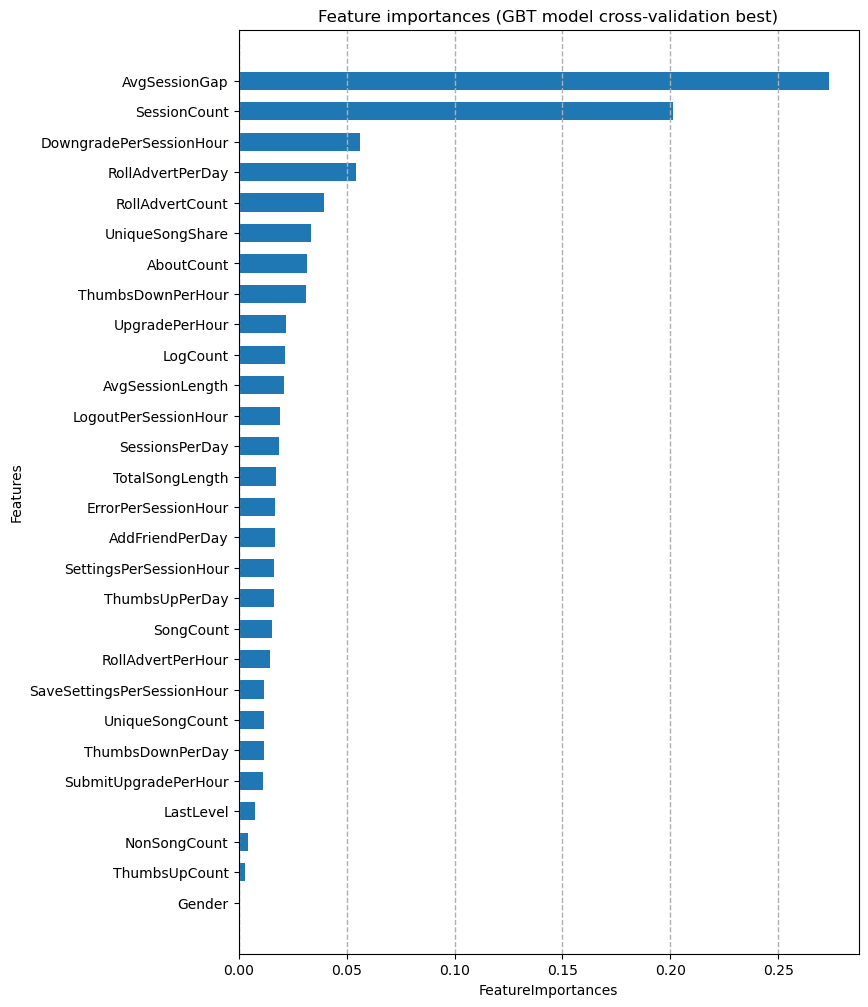

In [346]:
# Plot feature importances
plot_feature_importance(data_gbt_28, model_gbt_cvbest, 12, 'Feature importances (GBT model cross-validation best)')

### Random Forest

In [132]:
# Model's data (11 features)
data_rfc_5c = data_labels.join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

<a id="section-mini-bestmodel"></a>
#### Model #03
> - *11 features*
> - *seed 5*
> - *RandomForestClassifier*
> - *default hyperparameters*

In [332]:
classifier = RandomForestClassifier(seed=5)
model_rfc_5c, metrics_rfc_5c = fit_model(data_rfc_5c, classifier, seed=5)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


23/05/04 02:09:43 WARN Executor: Issue communicating with driver in heartbeater
java.lang.NullPointerException


Training done.


Metrics prepared.
Model fitting done (131 s).


In [333]:
metrics_rfc_5c

,metrics value
F1,0.823795
accuracy,0.845833
weighted precision,0.865686
weighted recall,0.845833
AUC,0.715909


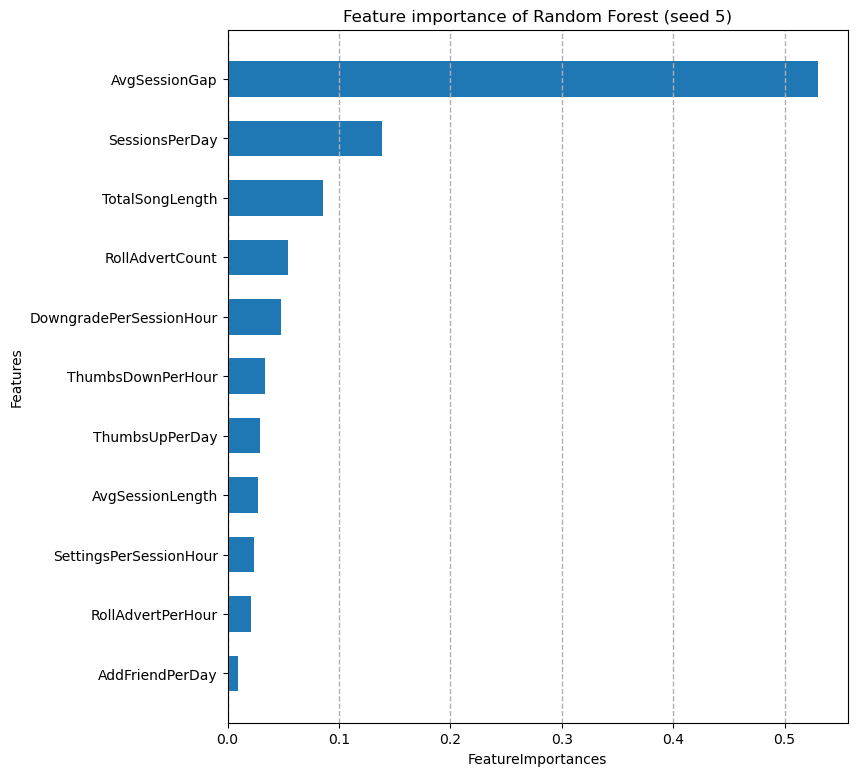

In [334]:
plot_feature_importance(data_rfc_5c, model_rfc_5c, 9, 'Feature importance of Random Forest (seed 5)')

#### Cross-Validation

In [133]:
# Model's data (29 features)
# Remark: Submit Downgrade event included
data_rfc_29 = data_labels.join(f_Gender, 'userId', 'outer') \
    .join(f_LastLevel, 'userId', 'outer') \
    .join(f_LogCount, 'userId', 'outer') \
    .join(f_SongCount, 'userId', 'outer') \
    .join(f_NonSongCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_ThumbsUpCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ErrorPerSessionHour, 'userId', 'outer') \
    .join(f_SettingsPerSessionHour, 'userId', 'outer') \
    .join(f_SaveSettingsPerSessionHour, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_SubmitDowngradePerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_SubmitUpgradePerHour, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_AddFriendPerDay, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .join(f_ThumbsUpPerDay, 'userId', 'outer') \
    .join(f_TotalSongLength, 'userId', 'outer') \
    .join(f_UniqueSongCount, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [134]:
# Create classifier
classifier = RandomForestClassifier(seed=0)

# Define ParamGrid builder
paramGrid_rfc = ParamGridBuilder() \
    .addGrid(classifier.maxDepth, [4, 5, 6]) \
    .addGrid(classifier.numTrees, [10, 20, 50]) \
    .build()

# Fit cross-validation model
model_rfc_cv, scores_rfc_cv = fit_model_cv(data_rfc_29, classifier, paramGrid_rfc)

# Show scores
scores_rfc_cv

Cross validation started. Please wait...
Train|Test data split done.
Create pipeline done.
23/05/04 02:51:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/05/04 02:54:11 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB


23/05/04 02:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1012.1 KiB


23/05/04 02:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1077.8 KiB


23/05/04 02:55:11 WARN DAGScheduler: Broadcasting large task binary with size 1012.1 KiB


23/05/04 02:55:13 WARN DAGScheduler: Broadcasting large task binary with size 1096.7 KiB


23/05/04 02:55:15 WARN DAGScheduler: Broadcasting large task binary with size 1131.9 KiB


23/05/04 02:58:06 WARN DAGScheduler: Broadcasting large task binary with size 1041.0 KiB


23/05/04 02:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB


23/05/04 02:58:37 WARN DAGScheduler: Broadcasting large task binary with size 1094.9 KiB


23/05/04 02:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB


23/05/04 02:59:10 WARN DAGScheduler: Broadcasting large task binary with size 1127.3 KiB


23/05/04 02:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1154.4 KiB


23/05/04 03:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1098.6 KiB


Cross validation done (607 s).


,maxDepth,numTrees,score
8,6,50,0.845856
7,6,20,0.838434
5,5,50,0.836057
2,4,50,0.834717
6,6,10,0.831839
3,5,10,0.825112
0,4,10,0.823051
4,5,20,0.819412
1,4,20,0.796190


#### Model #04 (best cv model)
> - *29 features*
> - *seed 0*
> - *RandomForestClassifier*
> - *maxDepth=6, numTrees=50*

In [135]:
classifier = RandomForestClassifier(seed=0, maxDepth=6, numTrees=50)
model_rfc_cvbest, metrics_rfc = fit_model(data_rfc_29, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


23/05/04 03:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1098.6 KiB


Training done.


23/05/04 03:05:36 WARN DAGScheduler: Broadcasting large task binary with size 1107.8 KiB


23/05/04 03:05:59 WARN DAGScheduler: Broadcasting large task binary with size 1107.8 KiB


23/05/04 03:06:22 WARN DAGScheduler: Broadcasting large task binary with size 1107.8 KiB


23/05/04 03:06:44 WARN DAGScheduler: Broadcasting large task binary with size 1107.8 KiB


23/05/04 03:07:08 WARN DAGScheduler: Broadcasting large task binary with size 1108.0 KiB
Metrics prepared.
Model fitting done (257 s).


In [136]:
# Show metrics
metrics_rfc

,metrics value
F1,0.840065
accuracy,0.852273
weighted precision,0.850569
weighted recall,0.852273
AUC,0.746849


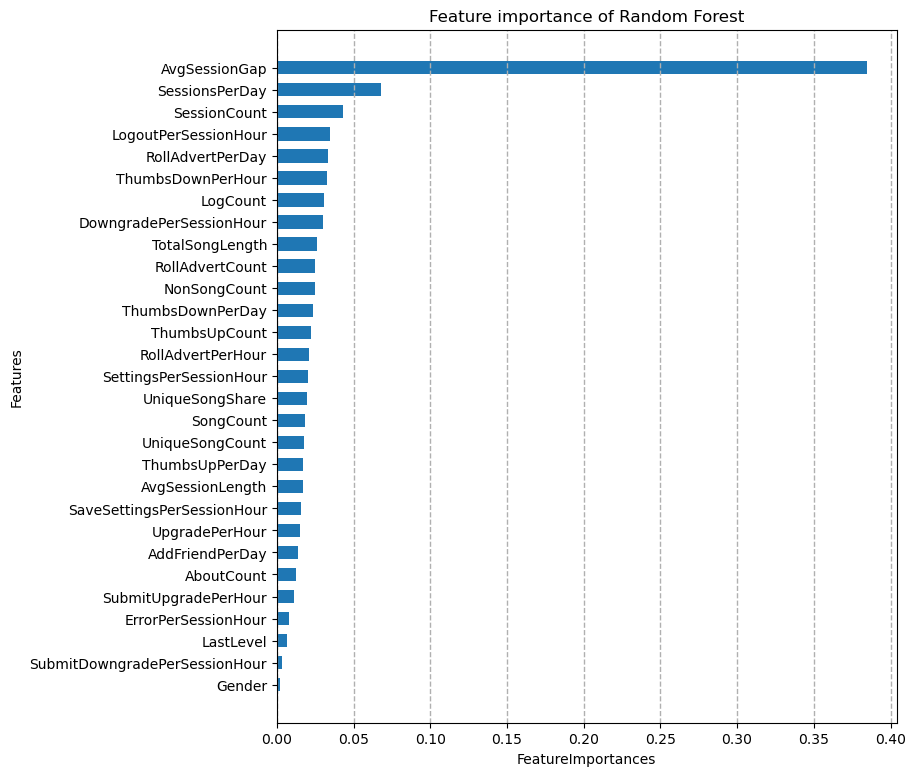

In [137]:
plot_feature_importance(data_rfc_29, model_rfc_cvbest, 9, 'Feature importance of Random Forest')

### Logistic Regression

In [138]:
# Model's data (8 features)
data_lr_8 = data_labels.join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_SessionsPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerHour, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_LogoutPerSessionHour, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_ThumbsDownPerDay, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

#### Model #05
> - *8 features*
> - *seed 0*
> - *LogisticRegression*
> - *default hyperparameters*

In [340]:
classifier = LogisticRegression(featuresCol='features', labelCol = 'label')
model_lr, metrics_lr = fit_model(data_lr_8, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


Training done.


Metrics prepared.
Model fitting done (111 s).


In [341]:
metrics_lr

,metrics value
F1,0.825059
accuracy,0.837121
weighted precision,0.830889
weighted recall,0.837121
AUC,0.731843


#### Cross-Validation

In [139]:
# Create classifier
classifier = LogisticRegression(featuresCol='features', labelCol = 'label')

# Define ParamGrid builder
paramGrid_lr = ParamGridBuilder() \
    .addGrid(classifier.maxIter, [10, 20]) \
    .addGrid(classifier.regParam, [0.0, 0.1]) \
    .addGrid(classifier.elasticNetParam, [0.0, 0.5]) \
    .build()

# Fit cross-validation model
model_lr_cv, scores_lr_cv = fit_model_cv(data_lr_8, classifier, paramGrid_lr)

# Show scores
scores_lr_cv

Cross validation started. Please wait...
Train|Test data split done.
Create pipeline done.


23/05/04 03:08:27 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/05/04 03:08:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/04 03:08:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Cross validation done (255 s).


,maxIter,regParam,elasticNetParam,score
4,20,0.0,0.0,0.843043
5,20,0.0,0.5,0.843043
0,10,0.0,0.0,0.842738
1,10,0.0,0.5,0.842738
2,10,0.1,0.0,0.807043
6,20,0.1,0.0,0.807043
3,10,0.1,0.5,0.798787
7,20,0.1,0.5,0.798787


#### Model #06 (best cv model)
> - *8 features*
> - *seed 0*
> - *LogisticRegression*
> - *elasticNetParam=0.0, maxIter=20, regParam=0.0*

In [140]:
classifier = LogisticRegression(featuresCol='features', labelCol='label', \
                                elasticNetParam=0.0, maxIter=20, regParam=0.0)
model_lr_cvbest, metrics_lr_cvbest = fit_model(data_lr_8, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


Training done.


Metrics prepared.
Model fitting done (102 s).


In [141]:
metrics_lr_cvbest

,metrics value
F1,0.825059
accuracy,0.837121
weighted precision,0.830889
weighted recall,0.837121
AUC,0.731843


#### Best model results
Here are the results of best model performance, one per learning method:

In [142]:
# Note: The metric values have been collected from the source notebook.

best_method = ['Random Forest', 'GBTClassifier', 'Logistic Regression']
best_F1 = [0.8400065, 0.863400, 0.825059]
best_accuracy = [0.852273, 0.867424, 0.837121]
best_weighted_precision = [0.850569, 0.863282, 0.830889]
best_weighted_recall = [0.852273, 0.867424, 0.837121]
best_AUC = [0.746849, 0.800270, 0.731843]

results_df = pd.DataFrame({
    'method': best_method,
    'F1': best_F1,
    'accuracy': best_accuracy,
    'weighted precision': best_weighted_precision,
    'weighted recall': best_weighted_recall,
    'AUC': best_AUC
})

results = spark.createDataFrame(results_df)
results.show(truncate=False)

+-------------------+---------+--------+------------------+---------------+--------+
|method             |F1       |accuracy|weighted precision|weighted recall|AUC     |
+-------------------+---------+--------+------------------+---------------+--------+
|Random Forest      |0.8400065|0.852273|0.850569          |0.852273       |0.746849|
|GBTClassifier      |0.8634   |0.867424|0.863282          |0.867424       |0.80027 |
|Logistic Regression|0.825059 |0.837121|0.830889          |0.837121       |0.731843|
+-------------------+---------+--------+------------------+---------------+--------+



#### Plot correlation coefficients of the best model

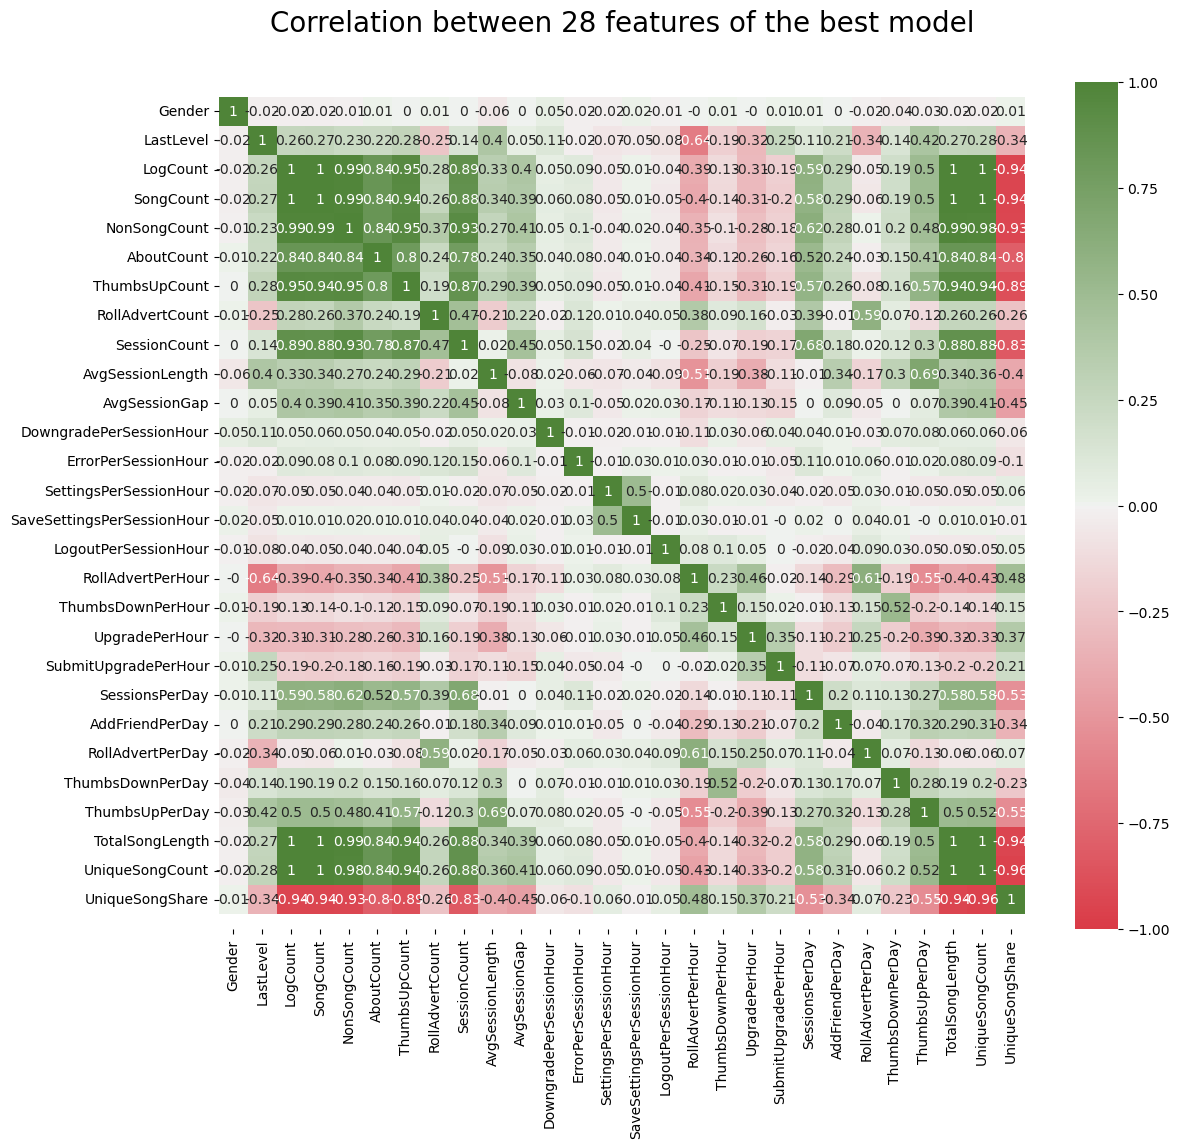

In [145]:
corr_df = data_gbt_28.toPandas()

# Plot correlation heatmap
plt.figure(figsize = [13, 11])
plt.title('Correlation between 28 features of the best model', y=1.05, size=20)
ax = sb.heatmap(corr_df.iloc[:, 1:].corr().round(2), annot=True, 
                cmap = sb.diverging_palette(10, 120, as_cmap = True),
                vmin = -1, vmax = 1)
plt.yticks(rotation = 0)

# Correct plot cut off (Note: we must fix it due to the bug in the matplotlib 3.1.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### List of correlation coefficient mean

In [146]:
# Create a list of correlation coefficient mean (using absolute values)
# ordered from weaker to stronger correlation

corr = corr_df.iloc[:, 1:].corr()
corr.apply(lambda x : np.mean(abs(x))).sort_values()

Gender                        0.052098
SaveSettingsPerSessionHour    0.069207
LogoutPerSessionHour          0.075530
DowngradePerSessionHour       0.078822
SettingsPerSessionHour        0.088915
ErrorPerSessionHour           0.090834
SubmitUpgradePerHour          0.149826
RollAdvertPerDay              0.152562
ThumbsDownPerHour             0.153860
ThumbsDownPerDay              0.176403
AddFriendPerDay               0.202666
AvgSessionGap                 0.214030
RollAdvertCount               0.226224
LastLevel                     0.247865
UpgradePerHour                0.248276
AvgSessionLength              0.261423
SessionsPerDay                0.288686
RollAdvertPerHour             0.319737
ThumbsUpPerDay                0.326295
AboutCount                    0.394323
SessionCount                  0.402114
ThumbsUpCount                 0.440996
NonSongCount                  0.451117
LogCount                      0.456208
SongCount                     0.456327
TotalSongLength          

#### Interpretation

The green zones represent the *positive correlation*: the more intense the green color, the stronger positive correlation between the variables. Similarly, the red zones represent the *negative correlation*: the more intense the red color, the stronger negative correlation between the variables. The bright grey colors represent zones with *weak correlation*.

We can find several variables with similar correlation coefficients:

> - *LogCount*
> - *NonSongCount*
> - *SongCount*

> - *TotalSongLength*
> - *UniqueSongCount*

These three variables have a **very strong relationship** with each other.

So, from the initial **28 features** of the best model in the sample dataset we remove 6 features. With the rest of **11 features** we'll exercise 4 more model fittings, one per seed, using the same classifier (*Random Forest*) from the best model.   

In [150]:
# Model's data - 11 features - based on correlation analysis of the best model
data_gbt_corr_11 = data_labels.join(f_LogCount, 'userId', 'outer') \
    .join(f_AboutCount, 'userId', 'outer') \
    .join(f_RollAdvertCount, 'userId', 'outer') \
    .join(f_SessionCount, 'userId', 'outer') \
    .join(f_AvgSessionLength, 'userId', 'outer') \
    .join(f_AvgSessionGap, 'userId', 'outer') \
    .join(f_DowngradePerSessionHour, 'userId', 'outer') \
    .join(f_ThumbsDownPerHour, 'userId', 'outer') \
    .join(f_UpgradePerHour, 'userId', 'outer') \
    .join(f_RollAdvertPerDay, 'userId', 'outer') \
    .join(f_UniqueSongShare, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [151]:
classifier = GBTClassifier()
model_gbt_corr_11, metrics_gbt_corr_11 = fit_model(data_gbt_corr_11, classifier)

Model fitting started. Please wait...
Train|Test data split done.
Create pipeline done.


Training done.


[2906.534s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 62662.0 (TID 186912): Retried waiting for GCLocker too often allocating 1048578 words
23/05/04 03:34:17 WARN TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
23/05/04 03:34:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Metrics prepared.
Model fitting done (101 s).


In [153]:
metrics_gbt_corr_11

,metrics value
F1,0.845838
accuracy,0.852273
weighted precision,0.846679
weighted recall,0.852273
AUC,0.770858


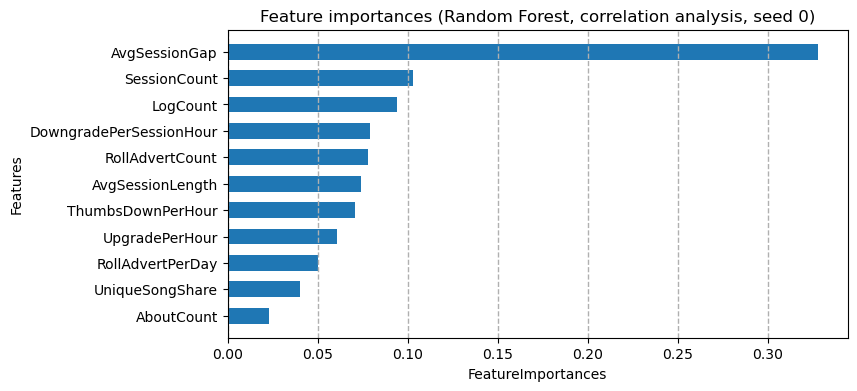

In [154]:
plot_feature_importance(data_gbt_corr_11, model_gbt_corr_11, 4, 
                        'Feature importances (Random Forest, correlation analysis, seed 0)')